In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from open_spiel.python.algorithms import random_agent

import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.validation import get_Validation, area_under_curve
from utils.environment.game_new import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment

def input_graph(graph_path,file):
    fh = open(graph_path+str(file)+".txt", "rb")
    GRAPH = nx.read_edgelist(fh)
    fh.close()
    nodes = GRAPH.nodes()
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(nx.relabel_nodes(GRAPH, map))  
    GRAPH.remove_edges_from(nx.selfloop_edges(GRAPH))
    return GRAPH, map

def implement_GNN(model,parameter_path,GRAPH):
    params = Params(parameter_path)
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    attacker = DQN(player_id=0,
                    state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features,
                   num_actions=num_actions)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    agents = [attacker]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    '''agents = [random_agent.RandomAgent(player_id=0, num_actions=num_actions),random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
        rewards_random, lcc_random, _ = eval_model(env, agents)'''
    return rewards, lcc, actions

def implement_random_GNN(agents,GRAPH):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions
    
def implement_Bench(fname,GRAPH, map):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    action_list = np.loadtxt(fname, dtype=int)
    action_list= [map.get(str(a)) for a in action_list]
    rewards, lcc, actions = EvaluateACTION(env, action_list,GRAPH)
    return rewards, lcc, actions


def visual_evaluation(graph_path,file_list,attacker_ba, attacker_mix):    
    AUC  = []
    for graph_name in file_list:
        GRAPH, map = input_graph(graph_path,graph_name)
        N = len(GRAPH)
        
        # Trained MIXED
        rewards_mix, lcc_mix, actions_mix = implement_GNN(attacker_mix[0],attacker_mix[1],GRAPH.copy())
        # Trained BA
        rewards_ba, lcc_ba, actions_ba = implement_GNN(attacker_ba[0],attacker_ba[1],GRAPH.copy())
        print(graph_name)
        print(actions_mix)
        print(actions_ba)
        
        #FINDER MODEl
        #FINDER Best Re-Trained  iteration
        path = "./FINDER/FINDER_ReTrained/"
        fname = path+graph_name+".txt"
        rewards_Finder, lcc_Finder, actions = implement_Bench(fname,GRAPH.copy(),map)
        if (len(lcc_Finder) == 0):
            lcc_Finder = None
        #CI
        path = "./CI/"
        fname = path+graph_name+".txt"
        rewards_CI, lcc_CI, actions = implement_Bench(fname,GRAPH.copy(),map)
        
        #CoreHD
        path = "./CoreHD/"
        fname = path+graph_name+".txt"
        rewards_CoreHD, lcc_CoreHD, actions =  implement_Bench(fname,GRAPH.copy(),map)
        
        '''#Random
        attacker = random_agent.RandomAgent(player_id=1, num_actions=N)
        rewards_random, lcc_random, actions_random = implement_random_GNN([attacker,attacker],GRAPH.copy())'''


        x =  np.flip(np.arange(N)[N:0:-1]/N)
        
        #Plot LCC Decrease
        plt.plot(x[:len(lcc_mix)],np.array(lcc_mix)/N, 'green',label='Trained Attacker')
        plt.plot(x[:len(lcc_ba)],np.array(lcc_ba)/N, 'red',label='Trained Attacker [BA model]')
        if lcc_Finder != None:
            plt.plot(x[:len(lcc_Finder)],np.array(lcc_Finder)/N, 'aquamarine',label='FINDER ReTrained')
        plt.plot(x[:len(lcc_CI)],np.array(lcc_CI)/N, 'pink',label='CI')
        plt.plot(x[:len(lcc_CoreHD)],np.array(lcc_CoreHD)/N, 'brown',label='CoreHD')
        #plt.plot(x[:len(lcc_random)],np.array(lcc_random)/N, 'blue',label='Random')
        plt.xlabel("Fraction of Nodes Removed")
        plt.ylabel("LCC/No. of Nodes")
        plt.legend()
        plt.title("LCC vs No. of Nodes for Agents  -"+ graph_name +" Dataset")
        plt.savefig("./Figure/LCC_vs_No_Nodes_"+graph_name)
        plt.show()
        plt.clf()
        ## Plot Reward
        plt.plot(np.cumsum(rewards_mix), 'green',label='Trained Attacker')
        plt.plot(np.cumsum(rewards_ba), 'red',label='Trained Attacker [BA model]')
        if lcc_Finder != None:
            plt.plot(np.cumsum(rewards_Finder), 'aquamarine',label='FINDER ReTrained')
        plt.plot(np.cumsum(rewards_CI), 'pink',label='CI')
        plt.plot(np.cumsum(rewards_CoreHD), 'brown',label='CoreHD')
        #plt.plot(np.cumsum(rewards_random), 'blue',label='Random')
        plt.legend()
        plt.title("Rewards for Agents -"+ graph_name +" Dataset")
        plt.savefig("./Figure/Rewards_"+graph_name)
        plt.show()
        
        #Compute Area under the curve
        auc_mix = area_under_curve(x[:len(lcc_mix)],lcc_mix)
        auc_ba =  area_under_curve(x[:len(lcc_ba)],lcc_ba)
        if lcc_Finder != None:
            auc_Finder = area_under_curve(x[:len(lcc_Finder)],lcc_Finder)
        auc_CI = area_under_curve(x[:len(lcc_CI)],lcc_CI)
        auc_CoreHD = area_under_curve(x[:len(lcc_CoreHD)],lcc_CoreHD)
        if lcc_Finder != None:
            auc_all = np.array([auc_mix,auc_ba,auc_Finder,auc_CI,auc_CoreHD],dtype='O')
        else:
            auc_all = np.array([auc_mix,auc_ba,None,auc_CI,auc_CoreHD],dtype='O')
            
        #auc_all = np.array([auc_Finder,auc_CI,auc_CoreHD],dtype='O')
        AUC.append(np.insert(auc_all,0,graph_name))
    AUC = np.array(AUC)
    return AUC

# Results

In [5]:
'''BA = 476000 #Homo 59000 #Hetero 348500#Tree 476000# Tree 299500 
MIX = 1000 # Homo 461500 #Hetero 5000 #Tree 1000 # Tree 59500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_HDgreedy_CI/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_HDgreedy_CI/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]
'''
BA = 165000 #Homo 59000 #Hetero 348500#Tree 476000# Tree 299500 
MIX = 479500 # Homo 461500 #Hetero 5000 #Tree 1000 # Tree 59500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]


# Real World Network

test
[2, 4, 3, 6, 1, 12]
[0, 3, 6, 16, 1]


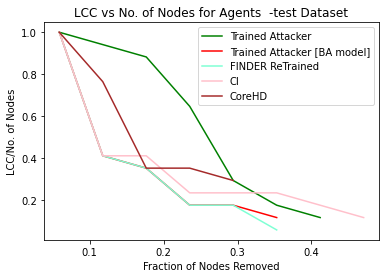

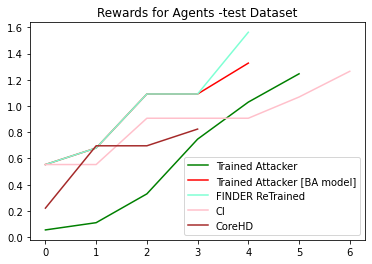

testTrain
[4, 26, 0, 8, 11, 27, 5, 19, 2, 1, 9, 33, 30, 28, 45, 39, 3, 10, 38, 32, 14, 35]
[4, 48, 49, 0, 26, 5, 8, 27, 9, 20, 3, 1, 33, 45, 32, 16, 29, 14, 10]


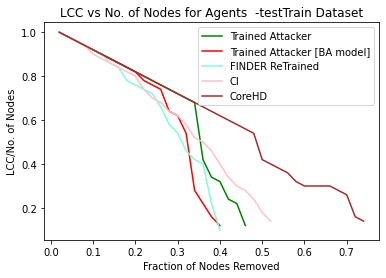

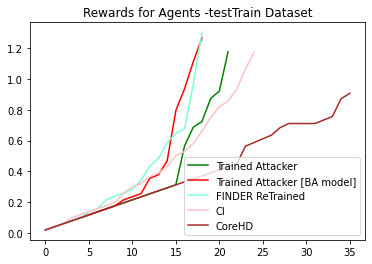

KeyboardInterrupt: 

In [39]:
file_list = ['HI-II-14','bio-grid-human']#['Digg_LCC']#['Gnutella31']
#file_list = ['GeneInteraction','ReliableInteraction']#['Gnutella31']bio-grid-human.txt
file_list = ["test","testTrain","corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience','HI-II-14']
graph_path =  "./Dataset/Real/"
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])


In [41]:
file = ['differentGraph','BAGraph','FinderReTrained','CI','Core']
print('Test Name','\t\t','Mix','\t','BA','\t','FIN','\t','CI','\t','Core','\t','BEST')
for i, element in enumerate(AUC):
    for nested_tem in element:
        if isinstance(nested_tem, str): 
            print(nested_tem, end=" => \t")
        else:
            print("{:.2f}".format(nested_tem), end=" \t")
    
    best = np.argmin(np.array(element[1:]).astype(float))
    print(file[best])
    print("")
print("===============================")

Test Name 		 Mix 	 BA 	 FIN 	 CI 	 Core 	 BEST
tree_8_80_grid_4 => 	641.86 	580.90 	610.63 	285.49 	1218.18 	CI

tree_8_100_grid_5 => 	792.61 	770.72 	784.45 	371.55 	1487.73 	CI



# Synthetic Network:- Heterogeneity and Homogeneity

heterogeneous_30
[3, 13, 20, 15, 2, 21, 10]
[8, 10, 15, 2, 21, 3, 12]


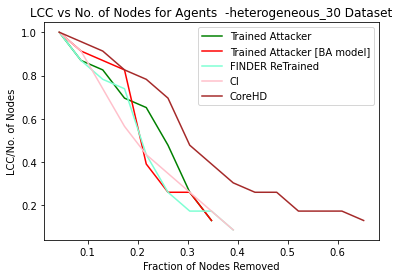

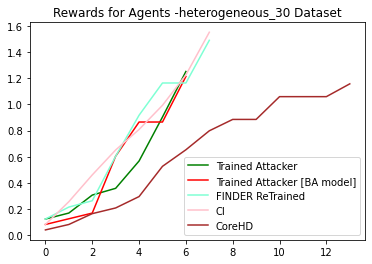

heterogeneous_50
[3, 11, 12, 29, 26, 10, 16, 22, 25, 6]
[11, 12, 35, 25, 10, 3, 16, 22, 26, 31, 6]


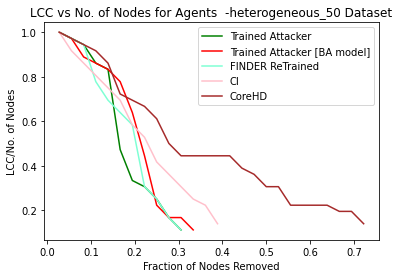

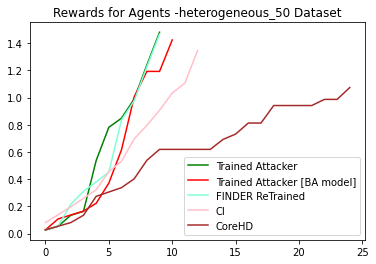

heterogeneous_100
[74, 54, 9, 71, 31, 50, 11, 29, 35, 30, 1, 13, 48, 45]
[74, 54, 31, 35, 71, 9, 14, 13, 50, 30, 11, 1, 58, 57, 48, 29]


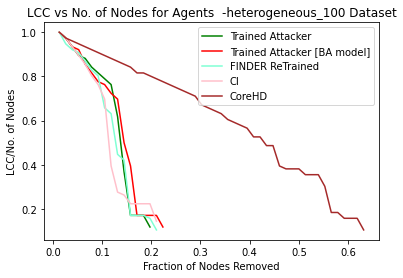

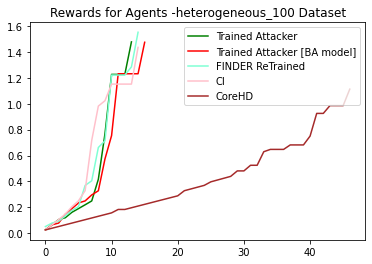

heterogeneous_500
[411, 407, 245, 103, 154, 150, 98, 109, 263, 148, 198, 152, 261, 363, 195, 254, 225, 214, 253, 260, 380, 306, 197, 281, 173, 278, 1, 338, 352, 252, 112, 286, 18, 219, 45, 107, 136, 130, 104, 129, 275, 398, 247, 34, 243, 251, 133, 2, 28, 279, 244, 264, 32, 256, 88, 383, 240, 42, 91]
[407, 411, 98, 263, 245, 198, 150, 171, 154, 261, 103, 152, 148, 214, 195, 109, 363, 260, 281, 275, 306, 253, 380, 173, 225, 1, 197, 278, 252, 112, 286, 352, 18, 129, 45, 167, 398, 34, 243, 218, 107, 64, 219, 247, 28, 244, 2, 264, 32, 279, 338, 88, 136]


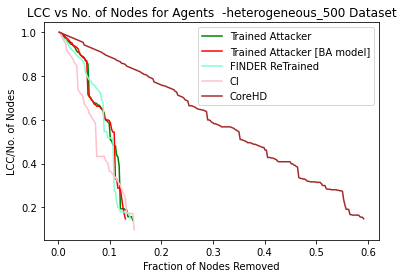

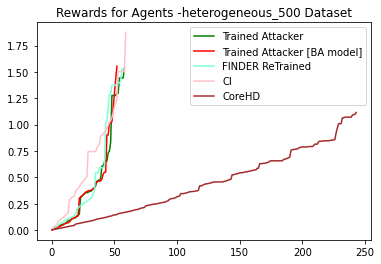

In [14]:
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['heterogeneous_30','heterogeneous_50','heterogeneous_100','heterogeneous_500']
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])


In [16]:
file = ['differentGraph','BAGraph','FinderReTrained','CI','CoreHD']
print('Test Name','\t\t','Mix','\t','BA','\t','FIN','\t','CI''\t','CoreHD''\t','BEST')
for i, element in enumerate(AUC):
    for nested_tem in element:
        if isinstance(nested_tem, str): 
            print(nested_tem, end=" => \t")
        else:
            print("{:.2f}".format(nested_tem), end=" \t")
    
    best = np.argmin(np.array(element[1:]).astype(float))
    print(file[best])
    print("")
print("===============================")

Test Name 		 Mix 	 BA 	 FIN 	 CI	 CoreHD	 BEST
heterogeneous_30 => 	4.35 	4.09 	3.98 	3.98 	6.96 	FinderReTrained

heterogeneous_50 => 	5.69 	6.53 	5.89 	7.26 	12.32 	differentGraph

heterogeneous_100 => 	8.95 	9.60 	8.66 	8.32 	28.95 	CI

heterogeneous_500 => 	38.52 	37.33 	37.12 	32.93 	147.61 	CI



homogeneous_30
[17, 26, 4, 24, 1, 3, 2, 22, 23, 21, 12, 7]
[17, 26, 3, 1, 24, 2, 4, 22, 23, 21, 7]


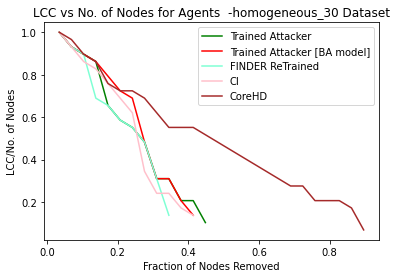

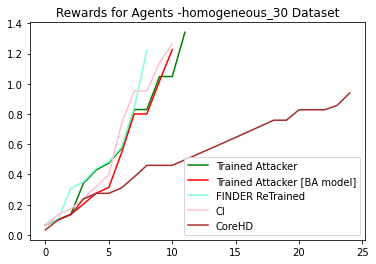

homogeneous_50
[47, 33, 1, 19, 23, 2, 40, 4, 35, 20, 29, 21, 34, 30, 3, 5]
[33, 47, 1, 23, 19, 2, 40, 35, 4, 29, 3, 20, 34, 30, 5]


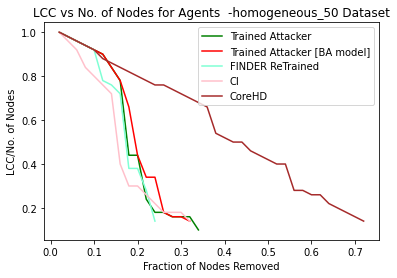

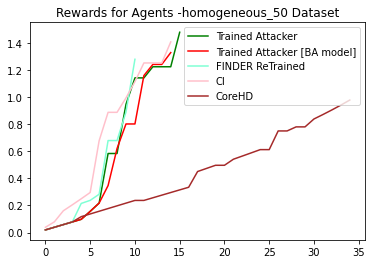

homogeneous_100
[64, 89, 63, 10, 13, 0, 49, 79, 6, 8, 14, 67, 77, 7, 85, 15, 78, 5, 60, 21, 29]
[64, 89, 78, 13, 10, 63, 5, 60, 4, 49, 61, 7, 59, 77, 6, 21, 29, 8, 85, 3, 67]


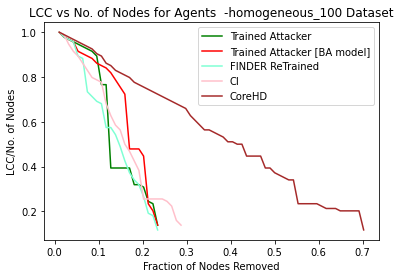

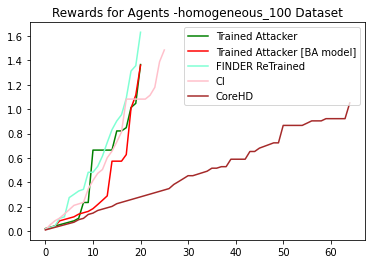

homogeneous_500
[465, 459, 63, 138, 61, 223, 88, 3, 404, 26, 412, 452, 190, 417, 1, 461, 114, 178, 272, 57, 204, 415, 167, 149, 135, 414, 345, 227, 284, 125, 384, 124, 438, 96, 374, 270, 137, 455, 2, 162, 25, 78, 372, 100, 188, 373, 50, 463, 371, 327, 219, 196, 233, 222, 170, 431, 60, 205, 252, 254, 98, 376, 450, 21, 164, 174, 207, 273, 165, 102, 343]
[355, 460, 63, 459, 138, 452, 61, 88, 26, 223, 3, 412, 404, 190, 438, 178, 417, 1, 114, 96, 345, 57, 374, 414, 135, 254, 149, 272, 167, 125, 124, 284, 204, 227, 461, 415, 25, 60, 205, 373, 219, 170, 164, 21, 463, 100, 162, 188, 174, 376, 196, 233, 381, 384, 137, 270, 78, 2, 450, 98, 327, 222, 371, 50, 455, 176, 206, 195, 234, 24, 87, 207, 439, 358, 261, 235, 99, 168, 22, 23, 169, 175, 177, 224]


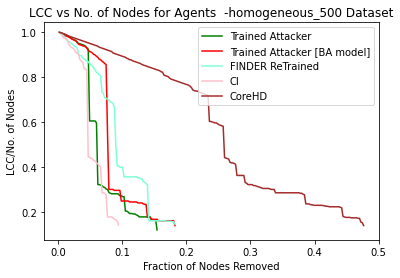

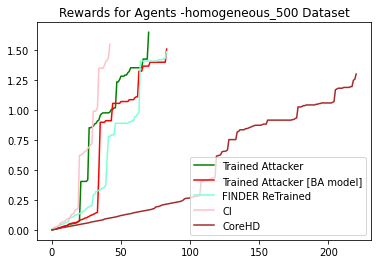

In [18]:
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['homogeneous_30','homogeneous_50','homogeneous_100','homogeneous_500']
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])

In [19]:
file = ['differentGraph','BAGraph','FinderReTrained','CI','CoreHD']
print('Test Name','\t\t','Mix','\t','BA','\t','FIN','\t','CI''\t','CoreHD''\t','BEST')
for i, element in enumerate(AUC):
    for nested_tem in element:
        if isinstance(nested_tem, str): 
            print(nested_tem, end=" => \t")
        else:
            print("{:.2f}".format(nested_tem), end=" \t")
    
    best = np.argmin(np.array(element[1:]).astype(float))
    print(file[best])
    print("")
print("===============================")

Test Name 		 Mix 	 BA 	 FIN 	 CI	 CoreHD	 BEST
homogeneous_30 => 	6.55 	6.78 	5.67 	6.26 	12.67 	FinderReTrained

homogeneous_50 => 	8.83 	9.17 	7.67 	7.59 	20.39 	CI

homogeneous_100 => 	13.02 	15.03 	12.34 	14.51 	36.62 	FinderReTrained

homogeneous_500 => 	34.47 	43.46 	46.46 	25.71 	128.49 	CI



# Synthetic with Motifs Attached

ba_300_20_house_1
[8, 6, 3, 10, 1, 0, 42, 104, 7, 2, 44, 9, 46, 105, 5, 267, 103, 143, 107, 85, 166, 12, 108, 57, 193, 219, 110, 4, 13, 51, 294, 112, 205, 11, 106, 114, 16, 119, 218, 43, 248, 169, 49, 164, 52, 303, 60, 281, 22, 86, 192, 87, 61, 56, 222, 54, 300, 14, 177, 245, 191, 95, 275, 274, 288, 146, 58, 153, 50, 307, 260, 66, 97, 59, 47, 195, 254, 63, 167, 53, 93, 136, 252, 156, 122, 96, 210, 72, 109, 236, 20, 175, 75, 26, 173, 70, 279, 208, 390, 324, 17, 90, 229, 15, 325, 323, 28, 261, 71, 115, 249, 39]
[8, 6, 3, 10, 1, 0, 42, 104, 7, 2, 44, 9, 46, 105, 5, 267, 143, 103, 107, 85, 166, 12, 108, 57, 13, 4, 193, 110, 219, 51, 205, 294, 112, 11, 16, 106, 43, 49, 218, 303, 114, 169, 52, 248, 164, 119, 60, 281, 22, 56, 87, 192, 54, 222, 86, 122, 58, 245, 260, 300, 275, 288, 177, 274, 191, 146, 286, 90, 109, 50, 254, 97, 63, 202, 307, 53, 59, 66, 195, 153, 167, 285, 15, 136, 96, 252, 210, 72, 175, 93, 20, 75, 236, 115, 186, 204, 19, 172, 315, 95, 316, 156, 138, 150, 55, 26, 208, 173, 14

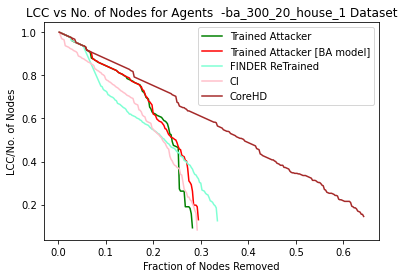

ba_300_40_house_2
[0, 7, 8, 82, 6, 15, 122, 3, 5, 12, 9, 14, 1, 23, 24, 21, 16, 127, 10, 96, 18, 102, 17, 34, 20, 213, 263, 123, 25, 211, 106, 13, 11, 107, 19, 170, 223, 124, 204, 27, 275, 148, 152, 212, 43, 187, 239, 150, 28, 171, 220, 207, 108, 103, 147, 83, 243, 131, 254, 234, 228, 173, 113, 265, 22, 89, 101, 40, 304, 36, 151, 222, 279, 232, 242, 54, 133, 132, 262, 84, 172, 98, 85, 33, 214, 72, 41, 37, 104, 87, 191, 282, 227, 188, 47, 343, 257, 301, 203, 289, 287, 281, 2, 118, 316, 129, 341, 74, 42, 197, 206, 295, 299, 335]
[0, 7, 8, 82, 6, 15, 122, 3, 5, 9, 12, 14, 1, 24, 23, 21, 16, 127, 10, 18, 96, 102, 17, 20, 34, 263, 25, 123, 213, 106, 211, 107, 11, 13, 170, 124, 223, 19, 204, 27, 275, 176, 148, 152, 43, 212, 187, 150, 103, 220, 147, 108, 234, 171, 207, 83, 243, 133, 254, 131, 228, 239, 57, 304, 121, 37, 222, 200, 101, 40, 36, 22, 44, 173, 279, 132, 265, 153, 84, 286, 113, 232, 262, 54, 98, 85, 28, 41, 72, 289, 125, 172, 227, 191, 87, 188, 104, 343, 301, 2, 69, 47, 136, 33, 42

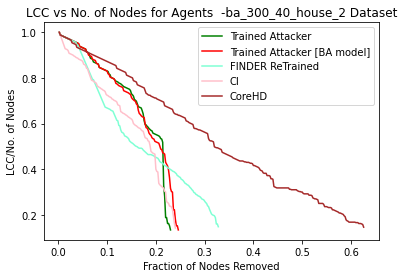

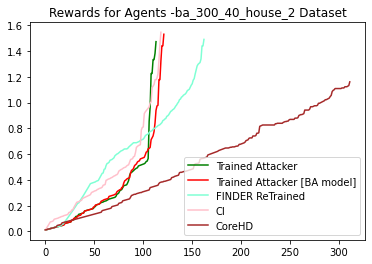

ba_300_60_house_3
[6, 7, 2, 0, 8, 12, 4, 10, 1, 76, 9, 20, 11, 14, 77, 143, 56, 58, 118, 218, 81, 26, 82, 183, 19, 61, 84, 201, 155, 187, 57, 275, 219, 13, 156, 85, 17, 209, 115, 79, 129, 90, 210, 184, 192, 254, 60, 308, 16, 232, 78, 157, 152, 273, 18, 197, 21, 295, 15, 241, 96, 64, 62, 5, 54, 265, 87, 207, 35, 296, 163, 88, 291, 225, 92, 119, 220, 246, 289, 191, 573, 356, 294, 211, 80, 248, 298, 130, 233, 284, 259, 271, 65, 135, 29, 282, 162, 188, 107, 30, 28, 327, 345, 343, 301, 128, 166, 594, 264, 338, 193, 121, 565, 194, 287, 334, 347, 348, 319, 59, 158, 358, 164]
[6, 7, 2, 0, 8, 12, 4, 10, 1, 9, 76, 20, 11, 77, 14, 56, 218, 143, 118, 58, 81, 82, 26, 183, 61, 84, 19, 187, 57, 219, 275, 155, 156, 209, 17, 13, 129, 115, 79, 85, 90, 192, 210, 3, 184, 241, 308, 88, 232, 152, 157, 254, 18, 78, 21, 197, 163, 295, 64, 96, 15, 16, 5, 35, 291, 141, 246, 119, 87, 207, 296, 54, 265, 225, 353, 51, 307, 273, 62, 220, 457, 455, 259, 356, 59, 287, 130, 29, 145, 65, 282, 271, 200, 248, 233, 191, 2

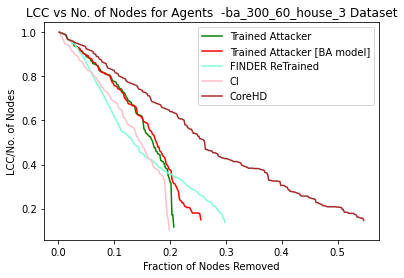

ba_300_80_house_4
[0, 2, 10, 5, 6, 9, 1, 8, 13, 19, 162, 7, 12, 20, 260, 18, 22, 14, 209, 66, 127, 139, 17, 23, 67, 15, 97, 129, 26, 98, 101, 31, 163, 29, 302, 11, 298, 3, 80, 70, 42, 141, 72, 142, 69, 27, 79, 199, 224, 38, 85, 16, 21, 106, 25, 24, 44, 30, 28, 181, 39, 146, 99, 143, 237, 184, 288, 235, 245, 241, 103, 100, 33, 214, 198, 226, 50, 264, 257, 71, 211, 130, 144, 46, 286, 193, 218, 115, 132, 189, 120, 240, 114, 369, 384, 191, 265, 253, 275, 131, 208, 213, 239, 152, 74, 297, 140, 111, 291, 35, 52, 272, 113, 151, 164, 387, 360, 382, 495, 504, 389, 355, 379, 317, 338, 357, 325, 254]
[0, 2, 5, 10, 6, 9, 1, 8, 13, 19, 162, 7, 12, 22, 260, 20, 18, 14, 67, 66, 127, 23, 139, 17, 209, 15, 97, 129, 98, 26, 101, 31, 29, 11, 302, 163, 3, 69, 141, 70, 298, 42, 199, 72, 80, 142, 27, 79, 100, 38, 16, 224, 25, 21, 28, 44, 24, 30, 106, 181, 39, 603, 286, 99, 235, 143, 288, 245, 211, 241, 184, 237, 103, 33, 50, 146, 226, 257, 71, 264, 601, 85, 198, 214, 151, 193, 46, 132, 113, 130, 144, 114, 1

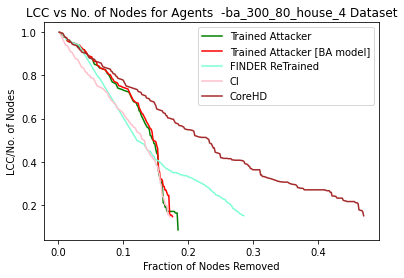

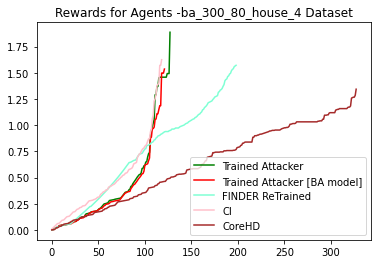

ba_300_100_house_5
[0, 105, 6, 7, 122, 18, 5, 10, 14, 4, 9, 17, 19, 8, 107, 194, 162, 249, 42, 20, 128, 3, 34, 11, 23, 30, 144, 145, 88, 92, 197, 66, 40, 124, 21, 13, 306, 231, 275, 16, 168, 130, 109, 36, 74, 146, 174, 123, 28, 86, 196, 54, 223, 183, 12, 127, 236, 200, 15, 114, 173, 229, 44, 199, 232, 32, 29, 83, 182, 47, 303, 106, 129, 75, 89, 85, 170, 283, 94, 207, 189, 150, 224, 33, 87, 22, 25, 332, 209, 285, 147, 273, 317, 257, 2, 246, 190, 389, 24, 201, 222, 327, 27, 76, 297, 383, 43, 226, 212, 335, 262, 242, 300, 274, 240, 264, 111, 363, 119, 126, 110, 165, 289, 166, 301, 256, 394, 177, 302, 38, 574, 260, 384, 125]
[0, 105, 6, 7, 10, 5, 18, 122, 4, 14, 9, 8, 19, 17, 107, 194, 162, 249, 42, 20, 128, 11, 34, 3, 23, 30, 145, 144, 92, 66, 88, 197, 196, 40, 21, 124, 16, 275, 13, 168, 306, 130, 86, 15, 109, 123, 174, 12, 36, 183, 28, 54, 231, 229, 236, 127, 74, 83, 200, 223, 114, 146, 29, 32, 199, 327, 44, 232, 303, 182, 47, 106, 170, 94, 125, 224, 85, 150, 173, 283, 222, 33, 733, 732,

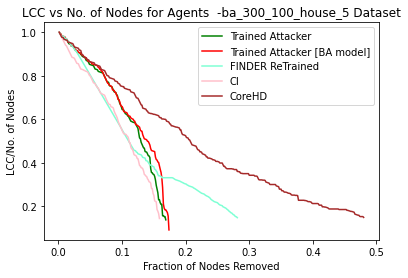

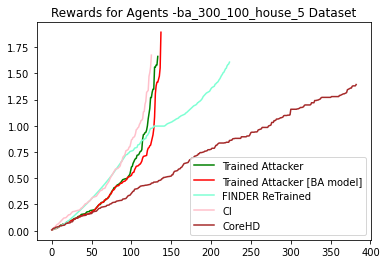

ba_300_20_fan_1
[0, 6, 3, 7, 66, 68, 14, 1, 8, 106, 10, 105, 11, 9, 71, 24, 15, 5, 134, 12, 73, 18, 67, 2, 4, 152, 145, 70, 22, 94, 265, 69, 211, 109, 13, 165, 156, 17, 95, 112, 189, 87, 23, 41, 295, 27, 29, 108, 135, 153, 218, 230, 107, 39, 125, 161, 143, 232, 110, 160, 303, 16, 32, 97, 149, 19, 74, 193, 219, 256, 36, 288, 171, 81, 239, 276, 21, 100, 197, 258, 293, 159, 229, 191, 111, 289, 38, 302, 182, 57, 163, 280, 72, 176, 88, 260, 48, 144, 96, 114, 90, 42, 76, 286, 294, 186, 259, 82, 254, 122, 271, 210, 85, 220, 246, 54]
[0, 6, 3, 7, 66, 68, 14, 1, 106, 8, 10, 105, 11, 9, 71, 15, 134, 5, 24, 12, 4, 73, 152, 67, 2, 145, 18, 70, 22, 94, 265, 69, 211, 109, 112, 13, 156, 17, 95, 189, 165, 27, 295, 87, 41, 23, 29, 108, 230, 74, 232, 218, 39, 107, 125, 36, 161, 143, 153, 19, 110, 32, 276, 197, 16, 149, 193, 97, 248, 219, 288, 171, 100, 88, 155, 144, 81, 239, 21, 258, 293, 303, 159, 289, 282, 280, 290, 38, 135, 182, 163, 160, 210, 260, 96, 114, 299, 151, 256, 186, 128, 259, 85, 72, 191, 

ba_300_40_fan_2
[8, 1, 7, 0, 131, 6, 10, 11, 223, 2, 3, 16, 96, 62, 68, 63, 110, 240, 177, 15, 56, 158, 12, 95, 18, 161, 138, 9, 99, 187, 59, 13, 133, 64, 114, 57, 273, 219, 235, 157, 241, 61, 274, 128, 127, 120, 5, 19, 206, 140, 181, 66, 17, 207, 43, 185, 70, 65, 67, 132, 22, 178, 72, 186, 224, 98, 26, 156, 20, 58, 205, 30, 117, 220, 24, 162, 160, 69, 270, 266, 142, 329, 171, 27, 60, 180, 55, 263, 4, 141, 314, 226, 25, 182, 29, 255, 107, 211, 183, 134, 124, 81, 39, 83, 199, 242, 203, 85, 76, 82, 28, 280, 290, 46, 247, 38, 278]
[8, 1, 7, 0, 131, 6, 10, 11, 223, 2, 3, 16, 62, 68, 240, 110, 63, 96, 95, 158, 177, 12, 18, 15, 13, 138, 161, 56, 9, 187, 59, 99, 57, 64, 114, 273, 133, 19, 157, 219, 278, 128, 235, 241, 274, 61, 5, 120, 127, 206, 140, 17, 186, 181, 185, 70, 65, 22, 132, 72, 67, 266, 178, 43, 66, 156, 26, 20, 207, 168, 98, 58, 55, 117, 24, 220, 142, 270, 162, 194, 69, 160, 115, 255, 328, 314, 30, 27, 180, 111, 14, 141, 263, 29, 289, 205, 171, 303, 116, 333, 85, 60, 107, 4, 25, 8

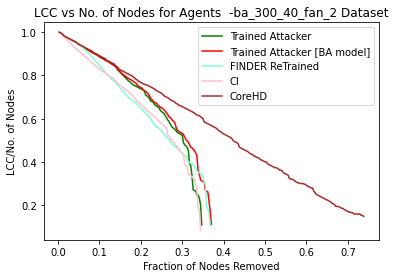

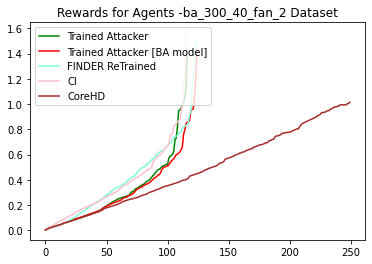

ba_300_60_fan_3
[0, 6, 10, 185, 9, 140, 86, 7, 13, 12, 14, 68, 11, 8, 69, 15, 109, 98, 85, 71, 188, 111, 2, 57, 87, 211, 3, 17, 156, 1, 90, 23, 5, 143, 27, 187, 21, 89, 281, 304, 29, 203, 70, 25, 36, 119, 31, 201, 32, 196, 272, 74, 110, 18, 186, 126, 141, 193, 283, 60, 94, 112, 291, 127, 124, 262, 77, 88, 147, 26, 28, 157, 33, 40, 43, 115, 243, 314, 20, 238, 275, 30, 241, 202, 76, 35, 251, 230, 282, 274, 205, 176, 130, 220, 250, 114, 179, 248, 135, 173, 293, 180, 142, 214, 195, 246, 310, 133, 55, 101, 161, 240, 218, 103, 227, 198, 146, 191, 264, 65, 292, 44]
[0, 6, 286, 10, 185, 9, 140, 86, 7, 13, 14, 12, 11, 68, 8, 69, 109, 98, 15, 85, 71, 188, 111, 2, 57, 87, 211, 156, 17, 90, 1, 21, 5, 143, 27, 23, 89, 187, 281, 29, 25, 203, 70, 3, 304, 36, 196, 201, 119, 32, 112, 126, 283, 186, 18, 110, 31, 127, 26, 193, 147, 94, 60, 291, 343, 267, 262, 88, 124, 77, 141, 261, 43, 40, 33, 20, 314, 243, 80, 157, 221, 195, 55, 275, 274, 220, 241, 282, 61, 214, 76, 238, 179, 154, 294, 35, 207, 272, 234

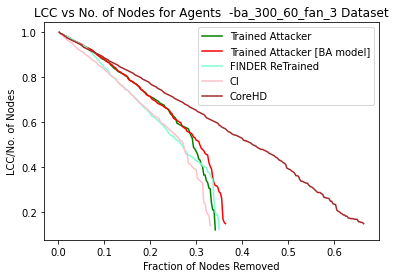

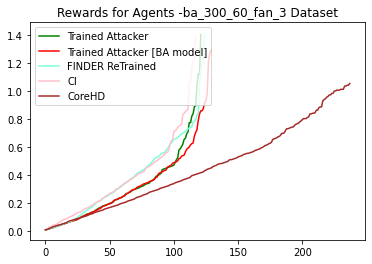

ba_300_80_fan_4
[6, 0, 9, 7, 8, 2, 5, 12, 28, 3, 14, 10, 1, 4, 86, 87, 19, 17, 68, 89, 23, 131, 88, 67, 191, 15, 91, 217, 130, 243, 26, 265, 165, 161, 11, 92, 74, 22, 16, 220, 30, 147, 36, 207, 25, 95, 110, 98, 20, 70, 193, 118, 112, 246, 290, 234, 157, 162, 303, 32, 213, 53, 116, 320, 308, 133, 264, 150, 170, 43, 29, 171, 319, 39, 120, 119, 218, 49, 169, 33, 173, 35, 40, 326, 200, 172, 309, 84, 69, 46, 13, 138, 152, 136, 270, 280, 230, 194, 111, 144, 164, 301, 263, 134, 99, 57, 38, 212, 323, 228, 235, 174, 250, 332, 286, 31, 85, 198, 208, 56, 185]
[6, 0, 9, 7, 8, 2, 5, 12, 28, 3, 14, 10, 1, 4, 86, 87, 19, 17, 68, 89, 23, 88, 131, 67, 191, 15, 91, 130, 217, 243, 26, 265, 165, 30, 92, 11, 74, 22, 220, 36, 147, 16, 207, 161, 95, 25, 110, 98, 20, 193, 70, 308, 246, 112, 162, 32, 43, 290, 53, 157, 234, 213, 303, 116, 150, 29, 133, 264, 170, 49, 319, 119, 171, 194, 138, 33, 169, 40, 35, 120, 273, 218, 353, 148, 270, 136, 250, 46, 280, 230, 237, 326, 208, 212, 198, 309, 69, 172, 185, 111, 42

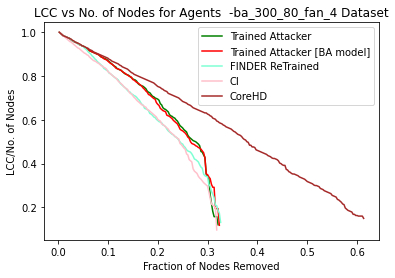

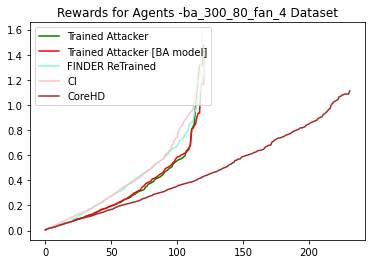

ba_300_100_fan_5
[0, 8, 6, 10, 9, 7, 12, 11, 53, 13, 151, 75, 72, 93, 55, 74, 125, 18, 76, 16, 1, 14, 2, 126, 94, 17, 79, 59, 95, 5, 219, 26, 245, 3, 204, 174, 236, 158, 203, 116, 113, 225, 32, 202, 23, 179, 15, 152, 206, 34, 207, 201, 221, 154, 25, 155, 314, 157, 247, 19, 135, 131, 99, 290, 77, 127, 28, 189, 31, 255, 275, 137, 312, 266, 129, 249, 63, 82, 54, 178, 4, 102, 380, 232, 176, 224, 246, 36, 128, 282, 121, 21, 317, 144, 262, 85, 91, 141, 118, 177, 297, 39, 276, 84, 272, 37, 304, 303, 101, 295, 27, 71, 172, 56]
[0, 8, 6, 10, 9, 7, 12, 11, 53, 13, 151, 75, 72, 93, 55, 74, 125, 18, 2, 1, 14, 16, 94, 126, 95, 5, 17, 79, 59, 76, 219, 26, 245, 204, 174, 3, 158, 236, 203, 116, 131, 23, 71, 225, 25, 202, 152, 32, 207, 201, 155, 154, 179, 243, 34, 314, 157, 15, 247, 206, 19, 135, 290, 221, 127, 272, 28, 77, 31, 137, 255, 275, 129, 312, 266, 178, 249, 189, 102, 365, 54, 63, 80, 4, 238, 20, 282, 317, 319, 232, 176, 120, 172, 246, 295, 141, 36, 21, 393, 362, 118, 253, 177, 91, 40, 70, 101

ba_300_20_clique_1
[7, 0, 10, 6, 12, 3, 13, 18, 4, 9, 2, 14, 106, 11, 131, 110, 15, 81, 230, 107, 22, 66, 67, 16, 82, 45, 89, 199, 1, 172, 44, 108, 5, 170, 222, 37, 29, 112, 171, 159, 200, 84, 158, 233, 83, 139, 211, 114, 179, 26, 265, 95, 25, 300, 100, 147, 35, 224, 86, 97, 90, 8, 245, 71, 281, 174, 138, 122, 157, 93, 59, 120, 176, 168, 36, 119, 115, 20, 212, 178, 232, 258, 24, 261, 270, 215, 34, 49, 214, 113, 228, 285, 54, 177, 17, 287, 125, 23, 80, 184, 194, 19, 269, 69, 204, 141]
[7, 0, 10, 12, 6, 13, 3, 18, 4, 9, 2, 14, 106, 11, 131, 15, 110, 81, 230, 22, 107, 66, 67, 16, 82, 89, 199, 1, 45, 172, 44, 108, 170, 5, 222, 171, 112, 37, 159, 158, 84, 29, 200, 233, 211, 83, 139, 114, 179, 26, 265, 95, 25, 224, 90, 97, 147, 300, 35, 8, 86, 245, 71, 281, 174, 122, 138, 176, 157, 93, 59, 120, 119, 258, 36, 256, 242, 208, 55, 20, 178, 24, 32, 142, 212, 115, 254, 34, 125, 54, 19, 69, 239, 80, 290, 269, 253, 111, 276, 232, 56, 68, 151, 113, 23, 168, 217, 42, 17, 133, 74, 270, 201, 292, 289, 1

ba_300_40_clique_2
[6, 7, 51, 0, 52, 11, 50, 9, 2, 137, 1, 14, 53, 4, 141, 114, 12, 3, 15, 10, 55, 78, 17, 161, 8, 133, 226, 102, 233, 16, 57, 18, 140, 25, 240, 246, 142, 160, 274, 116, 81, 58, 192, 235, 188, 22, 56, 134, 186, 115, 293, 84, 167, 100, 232, 162, 28, 135, 61, 108, 264, 152, 184, 159, 147, 164, 90, 213, 139, 36, 204, 269, 138, 13, 88, 190, 110, 278, 228, 229, 103, 144, 59, 34, 38, 111, 236, 117, 275, 170, 77, 158, 193, 243, 291, 44, 163, 227, 120, 145, 297, 252, 285, 212, 83, 29, 271, 281, 85, 37, 185, 187, 245, 238, 21, 136, 253, 79]
[6, 7, 51, 0, 52, 50, 11, 9, 2, 137, 1, 14, 53, 4, 141, 114, 3, 12, 15, 78, 55, 17, 10, 161, 8, 133, 226, 102, 233, 140, 57, 18, 16, 25, 142, 240, 246, 116, 81, 274, 160, 192, 58, 188, 235, 22, 56, 115, 186, 134, 167, 100, 152, 162, 293, 61, 232, 135, 28, 184, 108, 84, 147, 264, 213, 291, 90, 159, 139, 229, 269, 13, 110, 88, 144, 138, 164, 278, 204, 34, 103, 59, 281, 36, 190, 275, 254, 38, 109, 236, 158, 228, 77, 170, 243, 117, 202, 112, 82, 

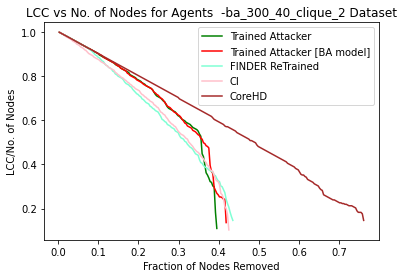

ba_300_60_clique_3
[8, 10, 53, 12, 100, 0, 6, 4, 13, 9, 76, 7, 194, 1, 24, 54, 282, 18, 11, 166, 196, 56, 264, 3, 126, 16, 135, 19, 105, 5, 2, 243, 226, 155, 274, 21, 14, 266, 195, 101, 140, 167, 17, 154, 79, 267, 209, 55, 20, 93, 85, 184, 170, 136, 157, 275, 108, 180, 200, 15, 220, 284, 162, 169, 61, 80, 31, 37, 125, 294, 219, 95, 202, 91, 242, 163, 26, 177, 199, 281, 260, 179, 293, 112, 137, 212, 59, 75, 63, 198, 146, 110, 257, 82, 83, 158, 106, 261, 276, 41, 28, 174, 205, 206, 69, 111, 249, 283, 103, 173, 122]
[8, 10, 53, 12, 272, 100, 0, 6, 4, 13, 9, 76, 7, 194, 1, 11, 54, 282, 175, 160, 166, 18, 196, 24, 56, 264, 3, 126, 135, 16, 19, 105, 274, 5, 2, 266, 243, 155, 21, 195, 101, 14, 140, 167, 226, 17, 79, 267, 209, 200, 143, 20, 55, 93, 184, 85, 137, 275, 37, 170, 180, 157, 108, 220, 61, 15, 242, 219, 169, 136, 125, 162, 294, 296, 80, 95, 260, 177, 91, 281, 199, 26, 202, 99, 284, 111, 31, 63, 106, 110, 146, 198, 163, 59, 25, 75, 154, 164, 300, 69, 212, 268, 249, 283, 205, 113, 174,

ba_300_80_clique_4
[60, 0, 2, 9, 7, 74, 6, 10, 76, 8, 75, 115, 4, 61, 254, 142, 126, 16, 11, 3, 128, 1, 20, 18, 17, 185, 5, 26, 80, 164, 252, 79, 166, 19, 203, 82, 152, 13, 118, 195, 216, 204, 81, 129, 158, 78, 127, 30, 165, 247, 92, 143, 228, 12, 83, 89, 159, 236, 299, 119, 27, 25, 250, 155, 160, 251, 276, 289, 24, 199, 287, 23, 35, 241, 178, 21, 32, 88, 15, 167, 156, 174, 235, 275, 90, 291, 42, 36, 253, 22, 290, 95, 285, 295, 191, 47, 196, 29, 101, 31, 157, 172, 270, 193, 151, 123, 269, 192, 104, 168, 77, 28, 179, 91, 110]
[60, 0, 2, 9, 7, 74, 6, 10, 76, 75, 8, 115, 4, 61, 254, 142, 126, 16, 11, 3, 128, 1, 20, 18, 80, 5, 17, 252, 203, 164, 79, 26, 19, 166, 185, 82, 152, 13, 195, 118, 216, 129, 81, 204, 158, 127, 78, 30, 165, 247, 92, 257, 143, 83, 228, 12, 89, 159, 236, 119, 155, 27, 25, 251, 160, 95, 299, 284, 289, 276, 15, 32, 42, 250, 88, 35, 178, 241, 287, 163, 24, 168, 275, 21, 235, 91, 36, 196, 47, 174, 286, 22, 90, 199, 291, 285, 31, 270, 14, 157, 101, 290, 295, 151, 104, 192,

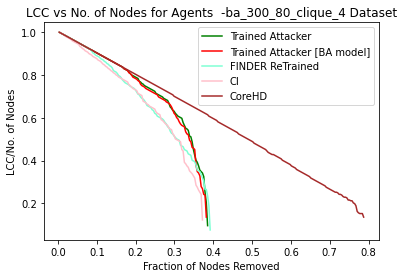

ba_300_100_clique_5
[81, 0, 6, 8, 4, 7, 119, 10, 12, 2, 84, 154, 18, 9, 120, 20, 25, 16, 19, 85, 17, 14, 185, 3, 15, 156, 33, 107, 161, 148, 86, 11, 13, 122, 194, 163, 32, 28, 123, 109, 35, 92, 90, 126, 150, 162, 186, 247, 51, 29, 167, 193, 159, 61, 111, 240, 227, 24, 118, 42, 190, 44, 254, 229, 149, 48, 27, 182, 291, 52, 157, 294, 105, 264, 235, 82, 155, 128, 134, 259, 26, 151, 183, 125, 212, 21, 121, 209, 104, 215, 216, 293, 281, 202, 30, 89, 47, 37, 98, 106, 280, 284, 289, 172, 41, 112, 184, 198, 231, 299, 165, 142, 234, 230, 195, 55, 262]
[269, 81, 0, 6, 8, 4, 7, 119, 10, 12, 2, 84, 18, 9, 154, 120, 25, 20, 16, 19, 17, 85, 14, 3, 185, 15, 148, 33, 107, 161, 156, 86, 13, 11, 122, 194, 163, 123, 28, 109, 32, 35, 126, 92, 90, 162, 186, 159, 193, 167, 29, 51, 247, 150, 61, 111, 240, 24, 42, 118, 190, 128, 48, 229, 227, 27, 149, 182, 291, 174, 26, 264, 105, 52, 82, 254, 235, 259, 134, 155, 151, 60, 157, 21, 297, 183, 198, 83, 37, 209, 277, 294, 34, 131, 121, 30, 299, 89, 293, 172, 226, 

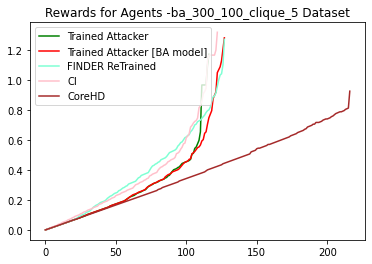

ba_300_20_diamond_1
[6, 2, 47, 0, 5, 100, 8, 64, 9, 7, 48, 11, 109, 188, 70, 138, 134, 135, 73, 77, 1, 17, 13, 67, 50, 119, 69, 66, 65, 49, 22, 21, 27, 139, 168, 169, 19, 98, 196, 101, 108, 78, 12, 15, 26, 234, 162, 232, 16, 295, 207, 137, 167, 112, 265, 111, 14, 148, 210, 61, 117, 144, 229, 28, 114, 273, 23, 267, 74, 84, 52, 33, 88, 192, 319, 307, 99, 179, 152, 4, 298, 193, 115, 24, 268, 198, 279, 274, 85, 230, 63, 240, 145, 81, 227, 251, 76, 314, 318, 322, 310, 320, 323, 308, 317, 321, 171, 297, 316, 258, 261, 213, 51, 324, 199, 271, 311, 102, 142, 222, 202, 10, 241, 250, 103, 82, 313, 325, 284, 189, 43, 264]
[6, 2, 47, 0, 5, 100, 8, 64, 9, 7, 48, 11, 109, 70, 188, 134, 138, 135, 73, 77, 1, 17, 13, 67, 50, 65, 119, 66, 69, 49, 22, 27, 21, 168, 19, 169, 139, 196, 98, 101, 108, 14, 78, 137, 26, 207, 16, 12, 15, 234, 167, 265, 295, 267, 111, 148, 28, 112, 61, 114, 33, 84, 144, 229, 23, 273, 198, 117, 52, 210, 74, 99, 115, 192, 90, 152, 24, 243, 307, 202, 174, 190, 232, 193, 268, 282, 28

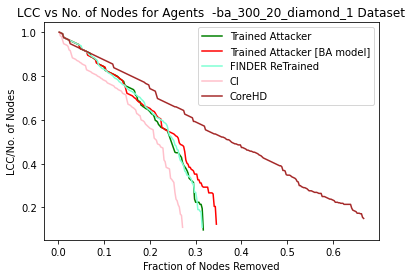

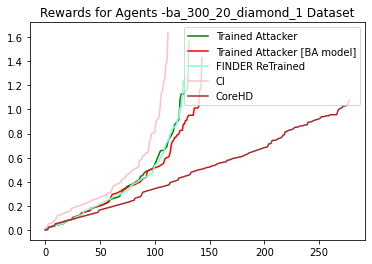

ba_300_40_diamond_2
[0, 6, 13, 101, 12, 1, 11, 2, 10, 4, 9, 7, 102, 78, 75, 128, 80, 76, 31, 249, 8, 28, 149, 175, 17, 32, 15, 20, 23, 148, 27, 193, 268, 130, 122, 5, 107, 77, 103, 18, 129, 253, 109, 123, 79, 151, 212, 162, 126, 54, 38, 177, 229, 37, 53, 21, 124, 250, 263, 29, 176, 22, 209, 267, 150, 191, 81, 254, 118, 132, 156, 207, 307, 324, 87, 88, 309, 190, 171, 24, 86, 55, 111, 134, 104, 36, 178, 44, 217, 202, 25, 73, 200, 232, 152, 215, 280, 451, 526, 482, 481, 509, 416, 323, 342, 333, 336, 305, 329, 312, 313, 372, 331, 279, 343, 327, 338, 330, 335, 337, 110, 347, 106, 167, 240, 112, 208, 291, 160, 271, 64, 276, 227, 264, 234, 218, 238, 260, 56, 40, 143, 251]
[0, 6, 101, 13, 1, 12, 11, 2, 10, 4, 9, 7, 75, 78, 102, 128, 80, 8, 28, 31, 249, 149, 76, 175, 17, 15, 32, 20, 23, 148, 193, 27, 268, 156, 122, 18, 107, 5, 77, 250, 129, 79, 130, 212, 29, 253, 123, 151, 109, 54, 38, 37, 263, 229, 124, 103, 21, 162, 177, 231, 126, 176, 25, 267, 22, 191, 81, 73, 200, 209, 53, 307, 190, 88, 184

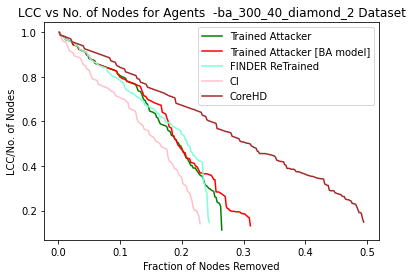

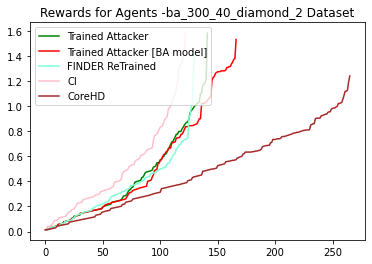

ba_300_60_diamond_3
[0, 7, 2, 8, 156, 6, 10, 68, 69, 5, 67, 1, 9, 72, 14, 70, 15, 127, 158, 142, 159, 17, 12, 13, 39, 97, 247, 26, 139, 128, 20, 33, 206, 71, 130, 275, 30, 224, 138, 100, 19, 98, 11, 189, 129, 74, 27, 262, 106, 239, 164, 76, 105, 82, 29, 91, 16, 52, 40, 111, 44, 250, 289, 93, 165, 25, 171, 94, 73, 58, 184, 37, 157, 103, 110, 280, 241, 222, 286, 41, 259, 4, 144, 343, 166, 28, 367, 351, 355, 153, 102, 207, 99, 174, 277, 238, 31, 191, 216, 268, 187, 233, 109, 132, 90, 236, 186, 228, 303, 231, 205, 391, 526, 491, 432, 335, 120, 293, 359, 433, 360, 288, 271, 364, 329, 292, 337, 346, 341, 496, 328, 574, 345, 256, 192, 332, 365, 317, 327, 350, 352, 357, 362, 334, 18, 366, 356, 272, 314, 338]
[0, 7, 2, 8, 6, 156, 10, 5, 67, 68, 69, 1, 9, 72, 127, 70, 15, 14, 142, 158, 17, 159, 12, 13, 26, 39, 97, 139, 247, 128, 33, 20, 130, 206, 224, 275, 30, 71, 138, 100, 19, 189, 98, 129, 11, 106, 76, 74, 239, 164, 105, 262, 29, 27, 82, 44, 16, 40, 289, 91, 250, 303, 165, 25, 184, 171, 166, 7

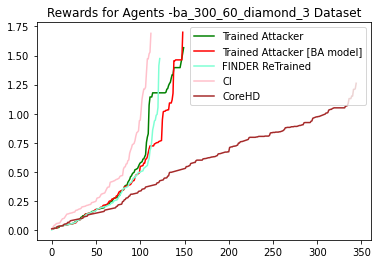

ba_300_80_diamond_4
[6, 0, 7, 4, 86, 8, 76, 5, 15, 12, 203, 10, 87, 121, 11, 225, 9, 138, 90, 192, 13, 117, 230, 24, 17, 119, 20, 118, 23, 75, 140, 77, 29, 25, 141, 216, 124, 61, 81, 41, 59, 139, 181, 78, 35, 206, 33, 99, 2, 240, 97, 263, 269, 150, 80, 85, 229, 111, 294, 100, 281, 94, 127, 1, 158, 83, 120, 177, 16, 91, 194, 151, 88, 671, 74, 104, 132, 95, 45, 14, 204, 47, 175, 670, 361, 737, 377, 107, 221, 38, 34, 147, 179, 145, 40, 49, 257, 130, 161, 144, 39, 200, 22, 634, 635, 591, 592, 742, 474, 691, 564, 163, 31, 383, 378, 279, 18, 42, 110, 376, 355, 360, 367, 320, 93, 342, 390, 349, 316, 129, 3, 297, 123, 317, 385, 341, 235, 226, 382, 101, 373, 384, 292, 387, 311, 381, 318, 391, 307, 364, 347, 305, 250, 336, 334, 338, 223, 283, 63, 345, 159, 27, 171, 331, 363, 330, 238, 350, 234, 178]
[6, 0, 7, 4, 8, 86, 76, 5, 15, 11, 203, 12, 10, 87, 121, 225, 138, 9, 13, 192, 90, 117, 24, 230, 17, 118, 119, 140, 23, 75, 77, 20, 29, 25, 141, 216, 124, 61, 181, 41, 59, 139, 81, 78, 33, 206, 99, 2

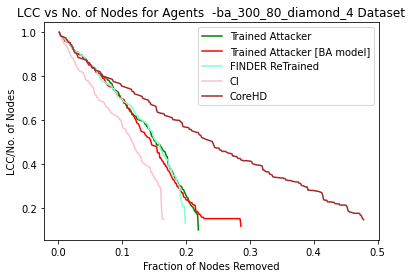

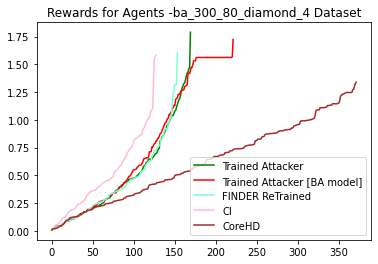

ba_300_100_diamond_5
[0, 6, 63, 9, 187, 13, 1, 144, 64, 96, 2, 11, 3, 16, 4, 10, 8, 72, 223, 7, 69, 17, 19, 252, 148, 238, 15, 153, 5, 117, 12, 152, 119, 253, 66, 97, 309, 14, 240, 178, 73, 162, 22, 255, 120, 228, 118, 204, 98, 74, 254, 154, 23, 209, 68, 217, 28, 274, 78, 132, 169, 43, 18, 121, 201, 276, 200, 30, 199, 218, 155, 304, 41, 32, 83, 107, 54, 205, 183, 135, 79, 197, 286, 202, 293, 320, 37, 379, 250, 166, 123, 402, 355, 67, 256, 248, 147, 188, 31, 161, 87, 207, 109, 397, 264, 81, 851, 871, 663, 840, 518, 651, 893, 839, 788, 873, 55, 436, 463, 381, 268, 314, 668, 405, 334, 400, 341, 232, 346, 366, 371, 376, 384, 392, 385, 348, 367, 386, 165, 294, 407, 112, 327, 340, 390, 247, 383, 398, 145, 324, 350, 351, 321, 368, 156, 116, 401, 171, 85, 387, 182]
[0, 6, 63, 187, 9, 1, 13, 144, 64, 96, 11, 2, 3, 16, 10, 4, 8, 72, 223, 7, 17, 19, 69, 252, 5, 153, 15, 238, 117, 12, 152, 119, 148, 253, 309, 97, 66, 14, 73, 162, 240, 22, 178, 204, 120, 228, 255, 74, 23, 98, 118, 154, 254, 197, 28

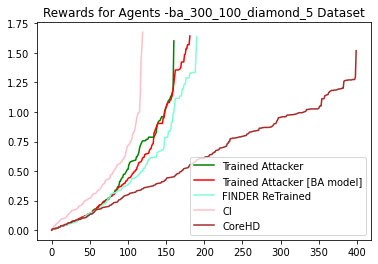

ba_300_20_cycle_1
[43, 3, 143, 2, 111, 6, 0, 44, 1, 7, 10, 9, 46, 75, 8, 50, 4, 48, 180, 212, 116, 242, 15, 45, 12, 11, 47, 145, 115, 52, 184, 78, 122, 118, 182, 283, 114, 17, 203, 146, 179, 110, 53, 14, 163, 295, 79, 34, 221, 76, 254, 144, 234, 112, 49, 230, 243, 217, 55, 181, 187, 54, 132, 80, 84, 92, 235, 94, 85, 119, 59, 171, 157, 88, 31, 57, 51, 28, 227, 298, 244, 208, 22, 169, 159, 124, 135, 93, 275, 279, 154, 214, 158, 89, 201, 161, 102, 226, 241, 218, 251, 20, 58, 232, 95, 175, 274, 262, 67, 16, 263, 137]
[43, 3, 2, 143, 111, 6, 0, 44, 1, 7, 10, 9, 46, 75, 8, 50, 4, 48, 180, 212, 116, 242, 15, 45, 11, 12, 145, 115, 47, 52, 78, 69, 184, 122, 182, 118, 146, 53, 114, 203, 283, 179, 110, 14, 17, 163, 295, 79, 34, 76, 254, 221, 144, 49, 234, 230, 243, 181, 55, 217, 112, 54, 187, 92, 80, 132, 235, 84, 85, 94, 274, 275, 171, 159, 51, 157, 88, 31, 57, 28, 208, 279, 67, 20, 256, 169, 268, 60, 22, 201, 95, 59, 124, 135, 89, 58, 330, 178, 93, 63, 263, 222, 304, 119, 265, 26, 161, 202, 66,

ba_300_40_cycle_2
[6, 0, 8, 9, 2, 7, 10, 180, 109, 3, 12, 56, 55, 4, 219, 94, 14, 16, 13, 196, 91, 11, 54, 90, 164, 112, 93, 244, 95, 59, 142, 114, 113, 111, 186, 60, 27, 18, 22, 189, 230, 129, 110, 70, 181, 15, 62, 206, 98, 21, 63, 132, 145, 25, 166, 120, 33, 168, 263, 137, 247, 97, 292, 146, 68, 165, 268, 61, 269, 64, 231, 140, 92, 278, 205, 220, 5, 265, 252, 77, 221, 257, 99, 259, 75, 209, 66, 136, 254, 279, 249, 197, 169, 302, 39, 82, 171, 119, 29, 250, 72, 122, 289, 299, 324, 238, 47, 130, 143, 152, 19, 139, 213]
[6, 0, 8, 9, 2, 7, 10, 180, 109, 56, 3, 12, 55, 4, 219, 94, 14, 16, 13, 91, 196, 11, 54, 244, 112, 164, 90, 93, 59, 95, 60, 114, 111, 142, 113, 186, 27, 230, 18, 129, 189, 22, 25, 110, 70, 15, 181, 145, 62, 166, 63, 21, 98, 33, 206, 120, 132, 168, 247, 263, 97, 137, 292, 165, 146, 269, 61, 68, 268, 231, 64, 220, 75, 40, 5, 205, 278, 92, 240, 252, 155, 259, 99, 136, 254, 257, 209, 140, 279, 197, 249, 53, 236, 324, 242, 169, 80, 66, 152, 299, 302, 211, 29, 265, 82, 39, 47, 

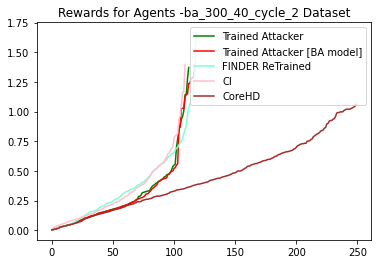

ba_300_60_cycle_3
[0, 9, 10, 2, 11, 7, 77, 6, 12, 161, 78, 138, 67, 13, 3, 17, 118, 160, 114, 84, 223, 26, 113, 81, 140, 8, 139, 1, 162, 217, 79, 25, 71, 183, 185, 134, 117, 115, 88, 14, 277, 268, 85, 243, 254, 15, 186, 116, 34, 184, 164, 50, 238, 40, 4, 281, 232, 82, 31, 24, 70, 309, 166, 269, 247, 191, 192, 16, 103, 83, 230, 149, 135, 104, 97, 38, 128, 20, 195, 68, 204, 153, 224, 127, 143, 291, 100, 207, 146, 320, 120, 169, 91, 86, 27, 271, 229, 45, 270, 189, 290, 35, 225, 174, 252, 144, 171, 181, 145, 231, 256, 239, 44, 150]
[0, 9, 10, 11, 2, 7, 77, 6, 161, 12, 78, 138, 67, 13, 118, 17, 3, 160, 114, 84, 223, 26, 113, 81, 140, 8, 71, 139, 162, 217, 25, 1, 79, 185, 134, 183, 115, 117, 15, 88, 309, 16, 186, 85, 243, 254, 277, 184, 116, 164, 232, 166, 268, 82, 128, 281, 50, 191, 34, 103, 31, 238, 269, 14, 247, 192, 40, 4, 24, 83, 70, 270, 195, 287, 20, 230, 204, 135, 45, 174, 233, 291, 329, 69, 100, 127, 146, 231, 252, 320, 224, 97, 120, 307, 250, 95, 359, 105, 181, 27, 216, 90, 256, 24

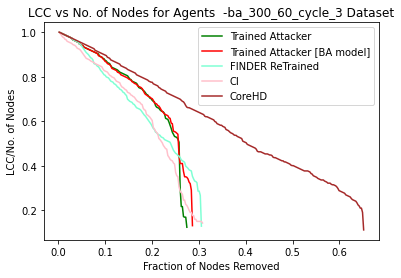

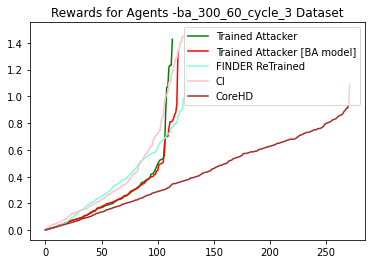

ba_300_80_cycle_4
[0, 8, 2, 76, 18, 9, 15, 7, 14, 4, 10, 13, 21, 26, 5, 80, 6, 130, 38, 37, 169, 144, 235, 19, 33, 12, 77, 31, 23, 78, 241, 30, 3, 157, 155, 296, 22, 79, 11, 261, 84, 86, 29, 34, 135, 90, 39, 242, 275, 32, 110, 280, 236, 214, 221, 178, 35, 234, 123, 215, 172, 120, 266, 16, 247, 216, 36, 20, 83, 146, 40, 87, 173, 28, 170, 209, 91, 305, 294, 163, 281, 111, 314, 145, 25, 74, 138, 200, 94, 185, 99, 156, 230, 27, 82, 115, 50, 24, 118, 121, 180, 211, 73, 47, 160, 93, 60, 319, 148, 278, 229, 48, 222, 55]
[0, 8, 2, 76, 18, 9, 15, 14, 7, 26, 5, 21, 4, 10, 13, 80, 6, 130, 37, 38, 169, 235, 144, 19, 79, 33, 77, 23, 31, 78, 30, 22, 12, 3, 157, 155, 296, 261, 11, 86, 241, 34, 84, 29, 135, 90, 39, 275, 242, 236, 32, 28, 214, 110, 178, 123, 234, 359, 36, 120, 16, 215, 216, 40, 221, 172, 247, 35, 156, 263, 83, 87, 170, 25, 266, 91, 20, 211, 49, 118, 145, 305, 163, 111, 314, 281, 209, 180, 74, 383, 138, 185, 27, 415, 121, 126, 115, 291, 99, 230, 222, 24, 200, 158, 48, 82, 75, 319, 229, 

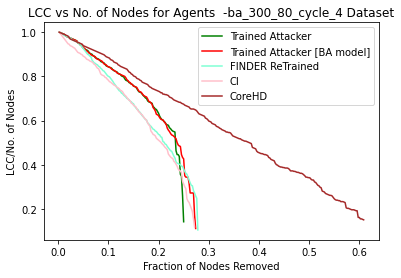

ba_300_20_star_1
[6, 0, 7, 55, 5, 56, 9, 3, 1, 77, 14, 12, 4, 58, 62, 13, 104, 20, 141, 23, 65, 8, 122, 57, 140, 64, 258, 103, 63, 212, 106, 196, 11, 211, 19, 126, 21, 17, 198, 22, 255, 18, 213, 283, 61, 109, 221, 31, 78, 300, 231, 37, 83, 286, 38, 27, 110, 128, 238, 113, 26, 105, 244, 47, 288, 107, 270, 282, 197, 10, 59, 75, 281, 34, 203, 185, 182, 60, 134, 116, 87, 130, 43, 32, 275, 146, 125, 99, 149, 115, 2, 139, 268, 269, 132, 202, 303, 124, 297, 159, 143, 289, 152, 88, 249, 260, 184, 294, 90, 200, 118, 188, 131, 155, 127, 285, 44, 193, 204, 271]
[6, 0, 7, 55, 5, 56, 9, 3, 14, 77, 12, 1, 4, 58, 62, 13, 104, 20, 141, 8, 122, 65, 23, 57, 64, 140, 258, 103, 212, 196, 63, 106, 11, 19, 211, 126, 59, 17, 198, 18, 255, 61, 250, 21, 213, 283, 31, 78, 282, 231, 37, 300, 83, 238, 26, 286, 113, 38, 128, 221, 109, 105, 110, 244, 22, 27, 288, 107, 47, 197, 10, 270, 177, 34, 134, 203, 60, 264, 75, 281, 167, 92, 182, 294, 275, 43, 132, 93, 87, 285, 297, 185, 184, 139, 131, 124, 88, 269, 143, 159,

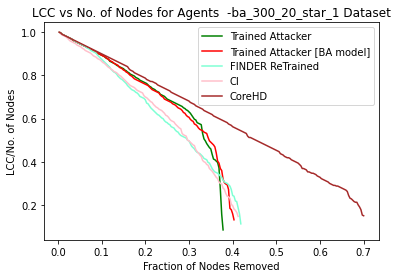

ba_300_40_star_2
[0, 7, 11, 6, 8, 10, 12, 2, 71, 4, 92, 16, 234, 17, 91, 1, 5, 9, 14, 95, 15, 3, 126, 112, 249, 98, 207, 159, 18, 72, 75, 94, 227, 97, 244, 28, 206, 79, 78, 262, 178, 26, 182, 131, 205, 96, 192, 127, 160, 146, 93, 235, 32, 149, 46, 161, 165, 83, 317, 13, 31, 276, 245, 21, 186, 167, 104, 29, 166, 139, 210, 134, 211, 19, 147, 184, 177, 213, 33, 45, 48, 157, 222, 253, 306, 292, 277, 212, 179, 57, 53, 302, 191, 271, 328, 250, 180, 114, 183, 242, 99, 163, 73, 209, 52, 20, 35, 133]
[0, 7, 11, 8, 6, 10, 12, 71, 92, 4, 2, 16, 234, 91, 17, 1, 5, 9, 15, 14, 95, 3, 126, 112, 249, 75, 207, 159, 72, 18, 98, 227, 94, 97, 244, 32, 206, 182, 79, 78, 146, 205, 26, 131, 96, 262, 127, 161, 178, 192, 28, 93, 317, 235, 149, 160, 46, 165, 83, 13, 31, 276, 21, 245, 186, 167, 104, 134, 211, 139, 19, 210, 166, 177, 329, 184, 147, 101, 175, 200, 29, 285, 45, 44, 52, 157, 48, 179, 306, 222, 277, 50, 212, 209, 27, 253, 269, 30, 236, 116, 292, 35, 183, 73, 99, 302, 250, 20, 191, 283, 242]


ba_300_60_star_3
[0, 6, 8, 1, 20, 5, 9, 13, 75, 2, 10, 17, 7, 16, 12, 14, 181, 125, 133, 72, 34, 205, 214, 73, 168, 74, 11, 179, 78, 260, 26, 180, 100, 32, 130, 23, 103, 101, 76, 218, 172, 25, 151, 80, 149, 267, 234, 160, 156, 24, 127, 33, 87, 124, 178, 22, 132, 150, 152, 231, 37, 352, 310, 15, 30, 121, 47, 237, 77, 134, 169, 84, 70, 140, 79, 81, 219, 108, 236, 286, 82, 188, 224, 109, 63, 206, 171, 43, 250, 4, 123, 170, 215, 53, 227, 94, 42, 200, 107, 105, 185, 83, 45, 271, 183, 290, 86, 306, 261, 229, 313, 157, 98, 216, 131, 257, 202, 146, 186, 291]
[0, 6, 8, 1, 20, 5, 13, 9, 75, 2, 10, 17, 7, 16, 12, 14, 125, 133, 72, 181, 34, 205, 214, 73, 168, 74, 11, 26, 78, 260, 179, 180, 100, 23, 130, 32, 103, 172, 25, 151, 80, 160, 267, 218, 101, 24, 149, 76, 156, 234, 127, 33, 124, 87, 178, 150, 22, 152, 132, 231, 37, 215, 30, 77, 47, 121, 237, 185, 81, 107, 252, 53, 131, 84, 188, 98, 169, 108, 79, 43, 126, 82, 236, 186, 286, 63, 123, 109, 250, 140, 171, 275, 42, 227, 232, 105, 200, 15, 94, 29

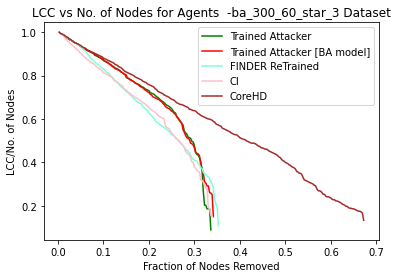

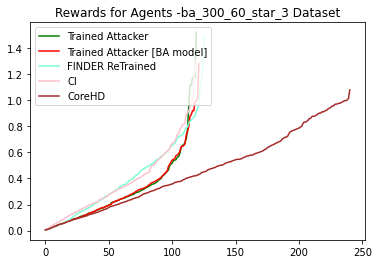

ba_300_80_star_4
[8, 0, 5, 6, 9, 10, 18, 12, 21, 4, 2, 1, 111, 84, 99, 100, 130, 162, 161, 7, 20, 13, 25, 124, 112, 85, 86, 17, 88, 219, 137, 19, 133, 3, 228, 118, 26, 247, 87, 367, 15, 206, 185, 189, 16, 117, 105, 11, 89, 140, 23, 129, 114, 280, 29, 67, 274, 177, 207, 116, 127, 234, 139, 131, 66, 65, 115, 78, 121, 186, 210, 299, 153, 172, 97, 35, 268, 14, 102, 211, 90, 307, 257, 239, 375, 30, 69, 135, 339, 93, 141, 31, 132, 165, 143, 138, 288, 281, 48, 63, 168, 314, 119, 287, 33, 190, 273, 142, 170, 213, 251, 47, 212, 103, 134, 34, 301]
[8, 0, 5, 6, 9, 10, 18, 12, 21, 4, 84, 1, 2, 111, 100, 99, 130, 162, 161, 7, 20, 13, 25, 124, 112, 85, 17, 86, 88, 219, 133, 3, 137, 118, 189, 228, 15, 26, 247, 129, 87, 16, 105, 117, 140, 11, 89, 185, 23, 206, 280, 29, 114, 274, 67, 116, 127, 19, 177, 207, 250, 78, 299, 134, 257, 172, 65, 102, 115, 121, 149, 141, 93, 288, 131, 186, 142, 97, 14, 307, 35, 211, 268, 139, 90, 106, 165, 63, 48, 339, 210, 31, 69, 239, 281, 138, 66, 143, 132, 135, 220, 313, 

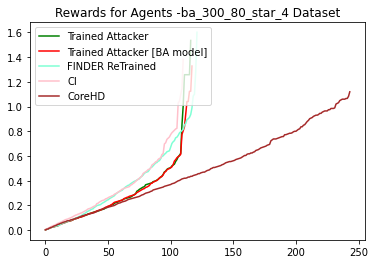

ba_300_100_star_5
[0, 6, 8, 7, 2, 105, 11, 10, 58, 1, 81, 20, 57, 17, 56, 12, 5, 132, 59, 130, 16, 25, 129, 247, 13, 119, 9, 3, 177, 85, 88, 26, 237, 84, 208, 19, 222, 157, 27, 86, 18, 29, 106, 82, 203, 64, 97, 24, 87, 306, 162, 317, 90, 83, 32, 232, 62, 327, 133, 70, 213, 227, 316, 191, 36, 66, 22, 109, 355, 176, 89, 91, 15, 207, 312, 92, 146, 63, 166, 65, 96, 67, 60, 265, 224, 30, 275, 69, 131, 156, 272, 211, 329, 178, 196, 78, 71, 278, 292, 241, 257, 94, 172, 291, 135, 134, 244, 72, 256, 113, 223, 37, 212, 259, 184, 121]
[6, 0, 8, 7, 2, 105, 11, 10, 58, 1, 81, 20, 17, 57, 56, 5, 12, 59, 132, 130, 16, 25, 129, 247, 13, 119, 9, 177, 85, 3, 88, 26, 237, 208, 86, 19, 157, 222, 27, 82, 29, 84, 18, 106, 203, 83, 87, 32, 62, 306, 162, 64, 232, 24, 97, 156, 15, 134, 327, 66, 213, 191, 36, 70, 92, 133, 89, 109, 22, 65, 140, 312, 227, 207, 146, 285, 166, 278, 224, 176, 30, 91, 275, 60, 316, 211, 69, 35, 39, 67, 78, 241, 197, 178, 329, 96, 292, 291, 265, 172, 71, 196, 94, 72, 272, 113, 256, 22

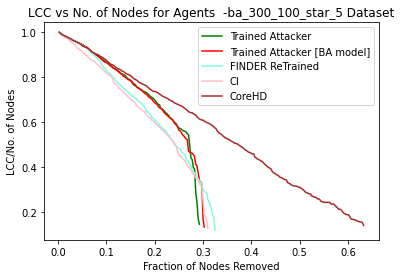

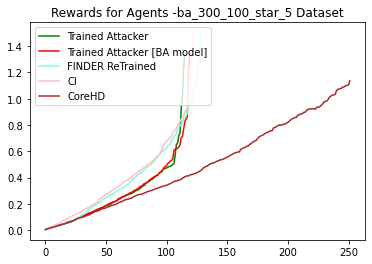

ba_300_20_grid_1
[4, 10, 0, 1, 9, 15, 8, 6, 101, 153, 129, 12, 104, 7, 13, 85, 57, 170, 19, 52, 14, 50, 168, 102, 155, 235, 156, 17, 105, 169, 172, 205, 154, 276, 2, 106, 68, 111, 143, 131, 220, 243, 142, 22, 88, 112, 58, 11, 171, 96, 56, 245, 158, 21, 122, 62, 145, 209, 239, 247, 34, 230, 130, 59, 290, 33, 64, 3, 140, 110, 87, 161, 141, 266, 86, 55, 76, 53, 54, 279, 189, 66, 258, 298, 267, 283, 159, 211, 18, 113, 246, 51, 291, 36, 30, 277, 117, 107, 262, 192, 16, 175, 70, 238, 194, 257, 449, 332, 310, 315, 264, 177, 71, 195, 280, 148, 201, 284, 281, 121, 286]
[4, 10, 0, 1, 9, 15, 8, 6, 101, 153, 129, 12, 7, 104, 13, 57, 85, 170, 14, 19, 52, 50, 168, 102, 155, 235, 156, 17, 56, 169, 172, 205, 105, 2, 154, 68, 111, 276, 106, 143, 245, 22, 96, 243, 220, 88, 59, 239, 58, 171, 62, 11, 21, 158, 145, 142, 51, 130, 230, 112, 54, 33, 18, 290, 131, 246, 140, 110, 211, 117, 3, 86, 30, 53, 141, 76, 209, 66, 45, 64, 114, 279, 36, 303, 298, 264, 201, 283, 267, 277, 225, 107, 177, 262, 187, 253, 291

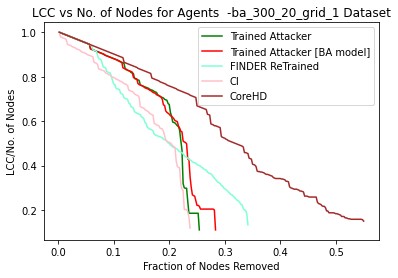

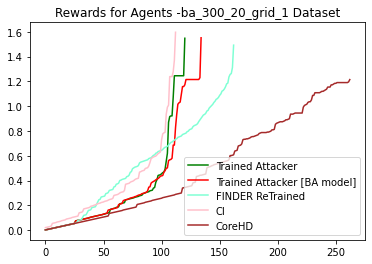

ba_300_40_grid_2
[6, 0, 7, 9, 86, 8, 11, 16, 1, 127, 12, 53, 85, 87, 121, 84, 10, 4, 3, 13, 18, 57, 56, 26, 77, 120, 76, 101, 122, 247, 55, 202, 163, 90, 224, 104, 181, 14, 272, 263, 30, 22, 166, 15, 131, 25, 54, 17, 274, 95, 102, 233, 124, 199, 221, 261, 137, 134, 201, 89, 23, 24, 78, 21, 162, 258, 169, 190, 29, 28, 229, 43, 167, 133, 66, 303, 248, 281, 299, 318, 81, 94, 152, 204, 125, 198, 130, 164, 165, 147, 73, 135, 345, 348, 216, 173, 286, 126, 91, 276, 311, 239, 215, 88, 75, 132, 256, 214, 2, 240, 277, 228, 40, 328, 316, 483, 390, 294, 509, 421, 531, 606, 631, 524, 569, 654, 500, 591, 553, 598, 623, 477, 584, 352, 360, 374, 382, 391, 406, 414, 431, 445, 453, 461, 469, 545, 561, 576, 615, 638, 646, 189, 210, 157, 34, 541, 487, 287, 397, 312, 508, 280, 607]
[6, 0, 7, 9, 86, 8, 11, 16, 1, 127, 12, 53, 121, 87, 85, 84, 10, 4, 3, 13, 18, 57, 26, 56, 120, 77, 76, 122, 101, 55, 202, 247, 90, 104, 163, 224, 181, 14, 131, 17, 22, 272, 166, 263, 274, 15, 25, 54, 30, 95, 134, 158, 124, 102,

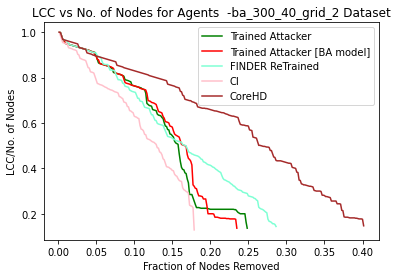

ba_300_60_grid_3
[0, 59, 6, 8, 3, 2, 9, 7, 5, 76, 14, 12, 78, 60, 113, 107, 75, 159, 1, 18, 4, 11, 61, 77, 17, 237, 230, 250, 10, 163, 156, 19, 22, 208, 105, 106, 130, 239, 28, 16, 128, 126, 39, 166, 110, 30, 188, 112, 274, 26, 13, 139, 270, 276, 32, 181, 34, 38, 111, 182, 23, 141, 127, 140, 15, 301, 174, 167, 263, 207, 209, 287, 242, 252, 285, 62, 161, 186, 35, 82, 46, 171, 27, 92, 273, 251, 131, 81, 170, 68, 121, 211, 176, 205, 63, 157, 254, 308, 625, 235, 431, 114, 275, 246, 565, 155, 79, 183, 261, 245, 315, 31, 123, 93, 255, 279, 234, 648, 175, 256, 580, 376, 495, 416, 472, 480, 560, 593, 642, 712, 757, 772, 795, 803, 749, 719, 697, 158, 602, 552, 682, 568, 617, 704, 666, 826, 726, 811, 408, 658]
[0, 59, 6, 8, 3, 2, 9, 7, 5, 76, 14, 12, 60, 78, 107, 113, 75, 159, 1, 18, 11, 4, 22, 77, 237, 208, 250, 17, 10, 156, 163, 19, 61, 106, 239, 28, 130, 105, 16, 126, 128, 166, 181, 30, 110, 188, 139, 39, 274, 13, 26, 141, 270, 276, 32, 182, 23, 35, 15, 255, 111, 38, 287, 174, 140, 167, 301, 

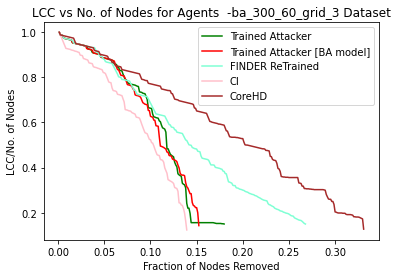

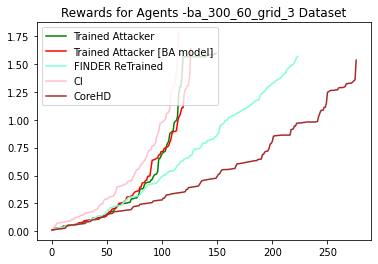

ba_300_80_grid_4
[6, 8, 1, 0, 121, 120, 7, 49, 9, 2, 10, 14, 55, 48, 101, 51, 50, 13, 52, 122, 269, 212, 102, 3, 23, 11, 133, 64, 143, 173, 104, 17, 12, 215, 254, 5, 223, 274, 259, 271, 148, 56, 278, 185, 189, 103, 27, 16, 229, 21, 26, 249, 62, 251, 177, 191, 57, 132, 172, 174, 293, 184, 195, 74, 22, 150, 24, 204, 187, 280, 19, 214, 266, 135, 252, 149, 255, 225, 136, 270, 125, 18, 186, 243, 175, 290, 228, 164, 152, 306, 86, 140, 85, 144, 25, 59, 154, 717, 428, 387, 362, 498, 437, 245, 237, 236, 272, 111, 188, 66, 124, 83, 72, 282, 36, 334, 54, 41, 53, 235, 257]
[6, 8, 1, 0, 121, 120, 7, 2, 9, 49, 10, 55, 14, 48, 101, 51, 50, 269, 13, 52, 122, 212, 3, 102, 23, 11, 133, 64, 12, 173, 104, 17, 143, 215, 5, 223, 254, 274, 259, 56, 148, 271, 185, 103, 278, 191, 26, 16, 21, 229, 189, 27, 249, 251, 177, 62, 174, 119, 172, 168, 57, 233, 132, 136, 195, 187, 74, 204, 22, 18, 19, 280, 144, 24, 186, 150, 252, 214, 125, 255, 270, 44, 149, 135, 184, 40, 243, 63, 235, 222, 164, 175, 154, 266, 86, 290,

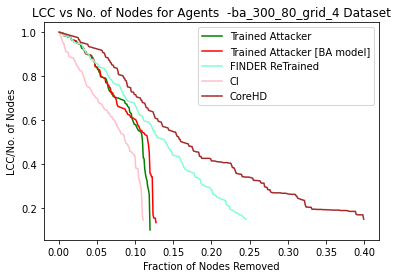

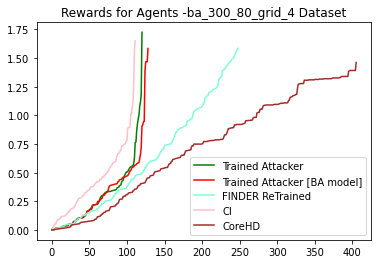

ba_300_100_grid_5
[6, 8, 7, 13, 0, 61, 148, 77, 9, 112, 96, 53, 113, 4, 18, 11, 111, 5, 293, 14, 78, 3, 10, 12, 98, 32, 172, 209, 22, 17, 239, 62, 16, 208, 230, 54, 33, 227, 229, 24, 259, 27, 63, 297, 176, 95, 117, 38, 173, 228, 84, 150, 214, 175, 274, 125, 67, 2, 121, 87, 273, 260, 290, 119, 68, 15, 155, 25, 268, 49, 315, 101, 108, 185, 85, 55, 50, 288, 166, 277, 19, 136, 151, 154, 47, 114, 205, 70, 240, 26, 157, 299, 242, 156, 122, 179, 149, 302, 35, 503, 127, 245, 152, 383, 248, 304, 289, 244, 52, 167, 140, 181, 310, 94, 132, 105, 21, 104, 89, 196, 321, 247, 235, 83, 215, 591, 1084]
[6, 8, 7, 13, 0, 61, 148, 77, 9, 112, 96, 53, 113, 4, 18, 11, 111, 5, 293, 14, 78, 12, 3, 10, 98, 32, 172, 22, 209, 17, 62, 239, 16, 54, 208, 230, 227, 33, 229, 50, 24, 15, 63, 176, 259, 27, 85, 173, 297, 95, 125, 67, 150, 117, 228, 87, 55, 75, 121, 84, 290, 260, 86, 273, 38, 25, 155, 83, 68, 288, 119, 215, 49, 154, 108, 109, 101, 277, 57, 166, 114, 157, 242, 56, 167, 2, 268, 52, 80, 185, 299, 102, 181, 

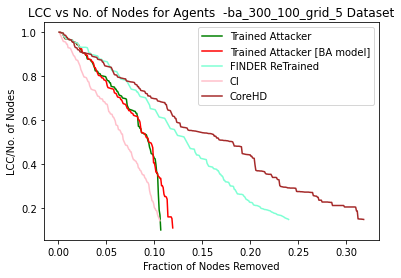

In [3]:
# 'ba_300_100_cycle_5',
file_list = ['ba_300_20_house_1', 'ba_300_40_house_2', 'ba_300_60_house_3', 'ba_300_80_house_4', 'ba_300_100_house_5', 'ba_300_20_fan_1', 'ba_300_40_fan_2', 'ba_300_60_fan_3', 'ba_300_80_fan_4', 'ba_300_100_fan_5', 'ba_300_20_clique_1', 'ba_300_40_clique_2', 'ba_300_60_clique_3', 'ba_300_80_clique_4', 'ba_300_100_clique_5', 'ba_300_20_diamond_1', 'ba_300_40_diamond_2', 'ba_300_60_diamond_3', 'ba_300_80_diamond_4', 'ba_300_100_diamond_5', 'ba_300_20_cycle_1', 'ba_300_40_cycle_2', 'ba_300_60_cycle_3', 'ba_300_80_cycle_4', 'ba_300_20_star_1', 'ba_300_40_star_2', 'ba_300_60_star_3', 'ba_300_80_star_4', 'ba_300_100_star_5', 'ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5']
graph_path = "./Dataset/Validation/Motifs_Attached/BA/"
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])


In [4]:
file = ['differentGraph','BAGraph','FinderReTrained','CI','CoreHD']
print('Test Name','\t\t','Mix','\t','BA','\t','FIN','\t','CI''\t','CoreHD''\t','BEST')
for i, element in enumerate(AUC):
    for nested_tem in element:
        if isinstance(nested_tem, str): 
            print(nested_tem, end=" => \t")
        else:
            print("{:.2f}".format(nested_tem), end=" \t")
    
    best = np.argmin(np.array(element[1:]).astype(float))
    print(file[best])
    print("")
print("===============================")

Test Name 		 Mix 	 BA 	 FIN 	 CI	 CoreHD	 BEST
ba_300_20_house_1 => 	81.42 	84.30 	80.98 	75.61 	149.69 	CI

ba_300_40_house_2 => 	85.84 	88.27 	90.13 	77.71 	171.56 	CI

ba_300_60_house_3 => 	88.36 	95.98 	93.36 	77.84 	172.16 	CI

ba_300_80_house_4 => 	87.57 	88.07 	102.37 	76.98 	171.29 	CI

ba_300_100_house_5 => 	91.46 	95.50 	108.95 	79.70 	186.53 	CI

ba_300_20_fan_1 => 	87.64 	89.32 	84.45 	82.92 	138.65 	CI

ba_300_40_fan_2 => 	85.67 	90.01 	82.43 	79.64 	141.01 	CI

ba_300_60_fan_3 => 	89.16 	92.83 	84.85 	80.98 	141.75 	CI

ba_300_80_fan_4 => 	87.21 	87.32 	81.79 	79.81 	137.74 	CI

ba_300_100_fan_5 => 	85.07 	89.00 	84.26 	77.00 	141.15 	CI

ba_300_20_clique_1 => 	80.50 	85.48 	77.70 	76.78 	137.15 	CI

ba_300_40_clique_2 => 	88.15 	90.68 	86.28 	86.34 	137.30 	FinderReTrained

ba_300_60_clique_3 => 	83.78 	86.30 	81.66 	77.89 	137.95 	CI

ba_300_80_clique_4 => 	86.88 	85.87 	81.55 	78.48 	140.35 	CI

ba_300_100_clique_5 => 	87.99 	91.97 	85.50 	84.22 	134.82 	CI

ba_300_20_

tree_8_20_house_1
[248, 552, 195, 60, 13, 56, 57, 43, 183, 278, 19, 22, 50, 69, 2, 167, 21, 23, 531, 260, 145, 16, 67, 55, 17, 205, 143, 65, 88, 246, 277, 164, 419, 414, 222, 173, 204, 196, 170, 151, 368, 89, 148, 239, 68, 236, 543, 564, 80, 146, 225, 52, 604, 94, 59, 122, 265, 537, 70, 249, 166, 221, 201, 176, 3, 12, 532, 53, 14, 58, 54, 10]
[248, 60, 195, 57, 21, 427, 111, 357, 531, 278, 145, 239, 43, 249, 273, 68, 23, 167, 69, 196, 201, 50, 236, 55, 65, 260, 80, 2, 22, 17, 222, 246, 368, 205, 164, 543, 19, 538, 277, 83, 148, 265, 151, 94, 534, 537, 89, 564, 3, 532, 533, 540, 63, 183, 62, 58, 53, 64, 18, 259, 170, 175, 54, 174, 59]


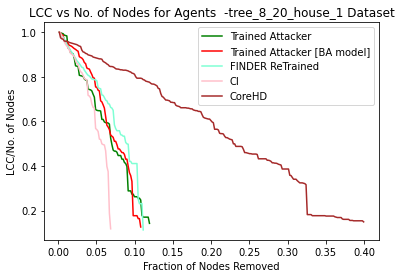

tree_8_40_house_2
[23, 98, 130, 94, 570, 95, 555, 257, 215, 164, 2, 615, 87, 203, 195, 247, 13, 180, 40, 199, 227, 571, 557, 177, 63, 243, 187, 37, 211, 42, 663, 80, 552, 54, 55, 235, 16, 68, 69, 14, 550, 33, 574, 25, 169, 229, 256, 261, 196, 285, 287, 175, 554, 93, 556, 627, 159, 216, 271, 600, 561, 53, 139, 56, 422, 314, 146, 162, 221, 562, 201, 217, 272, 708, 208, 230, 564, 76, 259, 329, 207, 147, 551, 553, 77, 197, 57, 22, 567, 255, 61, 548, 426, 566, 5]
[570, 95, 130, 555, 215, 87, 188, 257, 164, 113, 80, 203, 247, 557, 325, 552, 550, 554, 197, 28, 169, 218, 229, 196, 135, 37, 63, 243, 42, 177, 33, 220, 55, 271, 7, 175, 261, 285, 560, 27, 147, 548, 207, 31, 48, 40, 216, 565, 273, 631, 25, 256, 162, 93, 214, 230, 139, 3, 559, 255, 287, 452, 116, 564, 549, 563, 505, 567, 242, 158, 667, 426, 660, 10, 688, 708, 60, 174, 39, 62, 199, 22, 24, 36, 38]


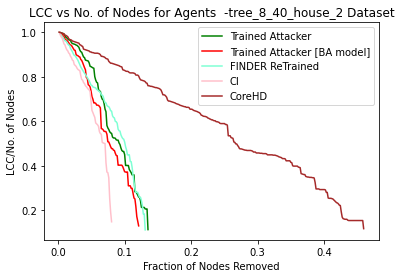

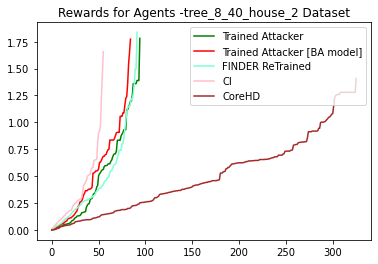

tree_8_60_house_3
[763, 188, 342, 56, 194, 137, 241, 217, 60, 171, 131, 155, 187, 159, 236, 733, 13, 111, 567, 331, 257, 1, 55, 9, 181, 272, 6, 11, 36, 45, 61, 279, 93, 49, 21, 254, 258, 126, 245, 280, 37, 33, 593, 50, 577, 70, 264, 569, 227, 19, 81, 82, 239, 208, 231, 203, 163, 212, 175, 34, 638, 174, 172, 435, 580, 636, 46, 62, 63, 588, 221, 736, 156, 189, 40, 43, 145, 150, 283, 164, 226, 296, 207, 570, 51, 214, 571, 244, 486, 196, 158, 183, 153, 579, 52, 573, 178, 53, 295, 16]
[188, 342, 56, 241, 194, 60, 137, 171, 585, 155, 187, 217, 111, 258, 567, 21, 236, 93, 331, 272, 156, 593, 577, 569, 159, 282, 153, 183, 227, 142, 245, 181, 211, 251, 50, 11, 146, 64, 588, 1, 255, 172, 37, 61, 34, 55, 203, 80, 175, 264, 231, 603, 218, 283, 212, 280, 62, 279, 149, 333, 15, 254, 208, 221, 332, 82, 206, 40, 572, 173, 540, 81, 566, 573, 578, 583, 570, 580, 574, 747, 7, 385, 95, 571, 599, 591, 582, 601, 575, 576, 470, 471, 120, 584, 590, 589, 552, 553, 12, 564, 141]


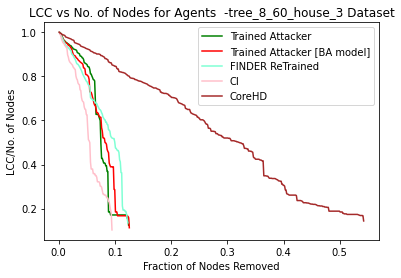

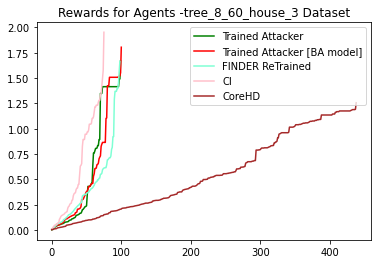

tree_8_80_house_4
[10, 97, 101, 773, 448, 423, 59, 208, 596, 46, 638, 28, 170, 186, 497, 156, 271, 117, 13, 267, 822, 471, 14, 406, 146, 38, 221, 22, 98, 222, 285, 1, 79, 277, 63, 174, 577, 255, 44, 216, 49, 111, 179, 606, 628, 250, 205, 658, 143, 584, 64, 239, 56, 57, 589, 43, 181, 147, 637, 258, 275, 184, 244, 153, 228, 830, 148, 688, 605, 194, 187, 8, 155, 599, 823, 167, 281, 192, 45, 616, 630, 125, 699, 590, 54, 854, 578, 209, 9, 900, 607, 591, 166, 175, 795, 176, 238, 169, 151, 579, 839, 144, 60, 627, 273, 631, 224, 180, 592, 612, 582, 624, 52, 593, 908, 885, 294, 234, 615, 323, 262, 168, 572, 284, 207, 625, 583, 585, 586, 587, 602, 614, 621, 182, 48]
[101, 423, 59, 10, 97, 240, 208, 117, 638, 170, 46, 156, 497, 271, 267, 406, 589, 471, 98, 577, 628, 606, 584, 285, 56, 275, 186, 181, 43, 28, 49, 258, 38, 229, 221, 175, 277, 255, 13, 293, 216, 160, 64, 180, 239, 250, 167, 205, 184, 70, 1, 57, 174, 153, 244, 148, 168, 187, 194, 125, 660, 192, 222, 14, 281, 44, 179, 211, 626, 254, 29

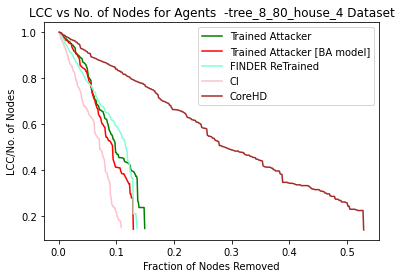

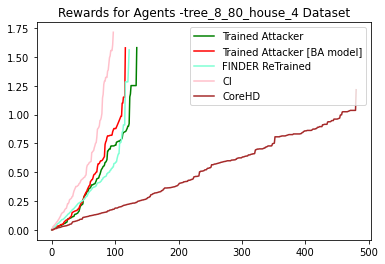

tree_8_100_house_5
[11, 307, 9, 42, 36, 211, 43, 218, 108, 120, 271, 248, 39, 135, 197, 319, 91, 611, 828, 288, 293, 603, 170, 255, 959, 543, 38, 226, 111, 623, 225, 191, 47, 284, 69, 909, 159, 185, 180, 249, 167, 221, 855, 6, 195, 282, 27, 926, 590, 31, 296, 222, 55, 627, 256, 194, 604, 405, 561, 581, 472, 583, 291, 582, 124, 733, 738, 427, 224, 461, 216, 175, 593, 205, 172, 219, 50, 254, 127, 277, 160, 118, 266, 26, 679, 615, 260, 35, 585, 642, 202, 589, 169, 231, 66, 190, 944, 610, 285, 360, 259, 3, 243, 609, 605, 290, 587, 864, 247, 638, 215, 62, 591, 63, 74, 287, 619, 647, 435, 639, 637, 18, 75, 51, 948, 601, 803, 227, 933, 588, 613, 586, 183, 634, 89, 891, 595, 363, 709, 152, 181, 251, 173, 217, 643, 7]
[11, 307, 42, 36, 211, 43, 218, 182, 271, 120, 248, 39, 108, 319, 135, 197, 611, 363, 828, 288, 623, 293, 167, 405, 111, 990, 604, 256, 543, 603, 191, 627, 583, 581, 582, 226, 116, 158, 244, 183, 180, 284, 170, 254, 221, 296, 47, 955, 624, 225, 236, 6, 124, 169, 224, 27, 282, 715,

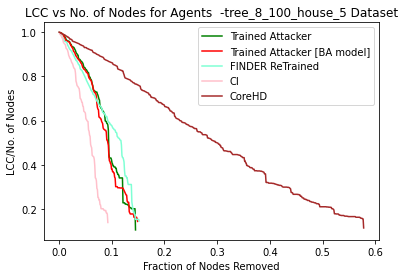

tree_8_20_fan_1
[55, 61, 110, 83, 143, 105, 165, 53, 22, 56, 153, 157, 24, 60, 200, 236, 5, 21, 127, 29, 243, 146, 139, 244, 252, 259, 96, 74, 185, 103, 255, 274, 180, 218, 144, 270, 23, 160, 245, 191, 33, 20, 31, 8, 37, 30, 36, 93, 150, 69, 184, 57, 10]
[55, 61, 110, 83, 143, 165, 153, 243, 230, 105, 56, 60, 21, 53, 200, 268, 248, 236, 24, 22, 157, 139, 74, 259, 245, 1, 96, 180, 160, 252, 103, 29, 185, 274, 33, 270, 47, 218, 68, 37, 36, 30, 246, 27, 48, 40, 192, 150, 8, 38]


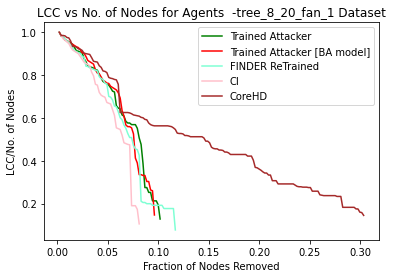

tree_8_40_fan_2
[180, 58, 6, 83, 67, 253, 40, 53, 28, 105, 4, 70, 18, 19, 125, 30, 150, 49, 73, 44, 190, 196, 127, 137, 131, 68, 266, 71, 110, 128, 152, 97, 276, 209, 259, 457, 124, 200, 236, 182, 280, 108, 43, 116, 36, 117, 17, 46, 12]
[180, 58, 6, 83, 105, 253, 67, 242, 53, 40, 70, 36, 30, 93, 196, 49, 162, 28, 11, 71, 259, 209, 73, 68, 152, 214, 175, 182, 150, 236, 256, 190, 137, 97, 276, 457, 110, 87, 117, 108, 124, 200, 128, 280, 277, 126, 46, 268, 9, 56, 265, 45, 226, 16, 37, 48, 43, 327, 0, 193, 34, 66, 44]


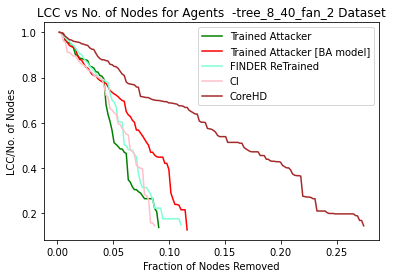

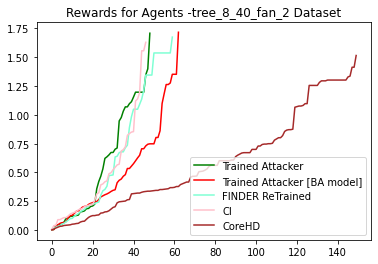

tree_8_60_fan_3
[215, 61, 168, 74, 5, 34, 138, 8, 66, 228, 132, 226, 199, 270, 48, 22, 20, 26, 57, 54, 30, 38, 119, 242, 248, 246, 157, 104, 210, 235, 278, 62, 217, 99, 166, 0, 79, 232, 141, 149, 170, 111, 92, 36, 100, 101, 247, 64, 244, 190, 12, 277, 261, 214, 70, 49, 229, 174, 176, 167]
[138, 8, 61, 5, 66, 228, 132, 270, 216, 104, 119, 158, 48, 208, 20, 210, 57, 154, 217, 248, 22, 26, 278, 54, 30, 38, 182, 241, 99, 244, 261, 277, 141, 149, 190, 166, 246, 62, 170, 157, 101, 111, 79, 74, 226, 64, 174, 47, 240, 51, 72, 198, 234, 18, 43, 55, 67, 566, 181, 49, 70, 199, 164, 235, 187, 247, 194, 179, 176, 71, 178, 16, 42]


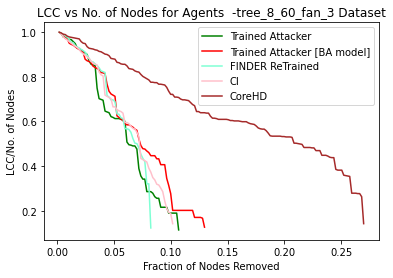

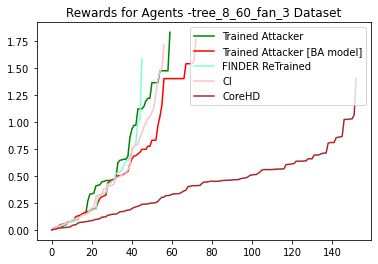

tree_8_80_fan_4
[47, 179, 32, 123, 104, 144, 253, 97, 157, 33, 149, 267, 20, 165, 232, 12, 40, 53, 273, 11, 246, 218, 239, 270, 95, 259, 137, 13, 8, 130, 50, 120, 54, 30, 38, 37, 59, 193, 52, 60, 82, 256, 34, 88, 185, 93, 75, 248, 279, 156, 90, 285, 503, 7]
[179, 47, 32, 123, 137, 246, 253, 149, 95, 273, 259, 193, 157, 88, 232, 53, 34, 267, 40, 213, 154, 54, 52, 60, 30, 165, 185, 67, 37, 50, 20, 239, 248, 13, 120, 256, 168, 104, 134, 285, 7, 131, 80, 231, 75, 93, 156, 97, 141, 206, 238, 90, 144, 186, 503, 171, 36, 173, 200, 218, 225, 223, 48, 10, 279, 35]


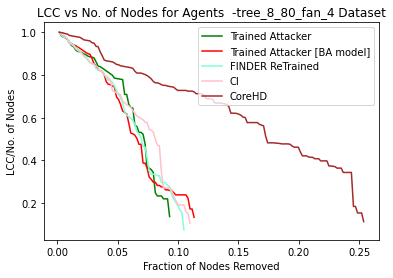

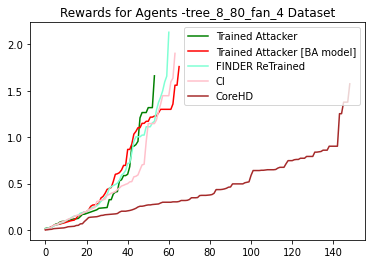

tree_8_100_fan_5
[44, 30, 214, 254, 39, 12, 192, 229, 163, 61, 263, 10, 198, 31, 11, 48, 37, 478, 19, 95, 32, 68, 178, 56, 71, 290, 93, 332, 118, 223, 243, 107, 165, 145, 6, 155, 50, 245, 49, 140, 190, 256, 85, 134, 283, 158, 222, 169, 123, 450, 268, 230, 264, 225, 236, 129, 151, 181, 568, 112, 231, 209, 186, 203, 252, 38, 47]
[44, 214, 30, 39, 192, 12, 229, 263, 10, 198, 32, 43, 225, 163, 49, 191, 95, 68, 223, 31, 61, 23, 56, 256, 48, 71, 237, 37, 156, 169, 178, 290, 246, 231, 203, 278, 165, 186, 243, 209, 268, 6, 222, 118, 264, 85, 129, 181, 134, 236, 158, 107, 283, 145, 112, 450, 140, 155, 245, 252, 151, 230, 284, 240, 258, 179, 9, 177, 221, 176, 493, 302, 41, 579, 47, 38]


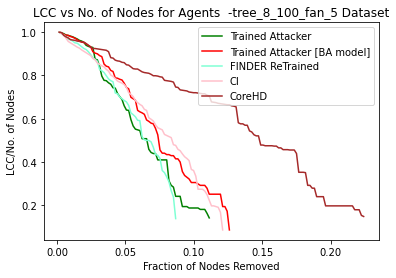

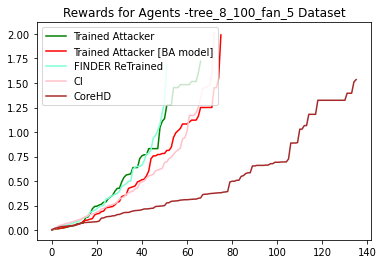

tree_8_20_clique_1
[211, 3, 13, 56, 260, 219, 185, 137, 187, 238, 49, 159, 1, 8, 16, 221, 9, 62, 169, 209, 64, 65, 156, 59, 47, 216, 174, 41, 134, 194, 235, 200, 193, 171, 257, 167, 184, 140, 15, 186, 42, 40, 75, 60, 35, 36, 43, 61, 12, 52, 58, 10, 37]
[3, 56, 260, 185, 41, 187, 238, 167, 49, 22, 59, 209, 216, 137, 65, 47, 200, 62, 235, 174, 169, 6, 19, 184, 78, 134, 194, 171, 129, 140, 198, 48, 255, 192, 42, 36, 256, 10, 60, 28, 50, 406, 39, 18, 27, 46, 58, 57, 67, 44, 43, 248, 61, 45, 186, 202, 193, 218, 257, 211, 206, 38, 246, 9]


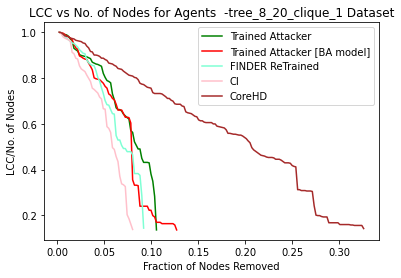

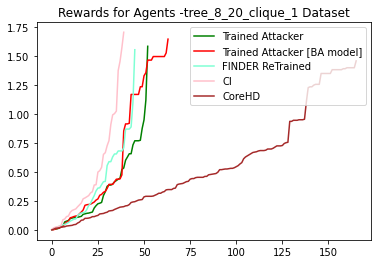

tree_8_40_clique_2
[3, 222, 21, 131, 224, 51, 163, 75, 47, 8, 35, 16, 61, 62, 241, 169, 6, 185, 201, 189, 5, 135, 234, 207, 263, 117, 209, 156, 252, 165, 155, 159, 261, 110, 30, 141, 116, 137, 63, 81, 202, 212, 245, 36, 37, 87, 44, 66]
[3, 21, 131, 224, 75, 163, 124, 209, 47, 222, 185, 51, 234, 35, 266, 207, 155, 6, 201, 189, 116, 7, 159, 120, 245, 252, 165, 122, 5, 223, 134, 117, 110, 137, 261, 156, 212, 52, 313, 315, 37]


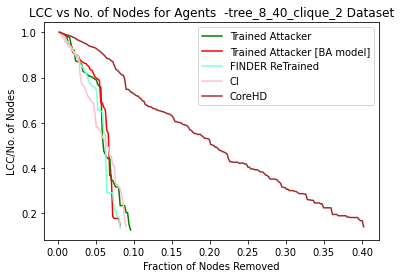

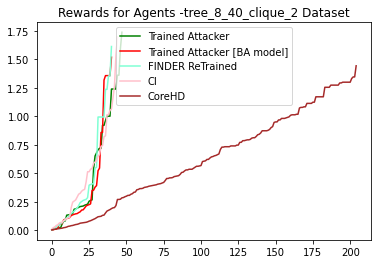

tree_8_60_clique_3
[3, 6, 26, 27, 254, 153, 263, 265, 9, 23, 66, 42, 13, 61, 40, 49, 41, 36, 140, 68, 62, 195, 189, 264, 256, 155, 267, 248, 104, 111, 115, 235, 270, 188, 73, 113, 174, 172, 193, 63, 112, 38, 11, 239, 39, 47, 242, 16, 15]
[3, 26, 27, 254, 153, 265, 263, 235, 195, 41, 68, 66, 62, 176, 189, 140, 36, 42, 256, 49, 23, 61, 9, 267, 113, 155, 248, 6, 104, 115, 174, 270, 193, 73, 112, 63, 162, 250, 251, 500, 47, 71, 171, 238, 38, 35, 40, 67, 43, 172, 48]


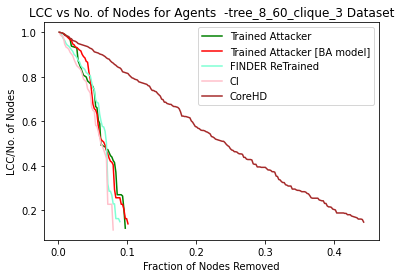

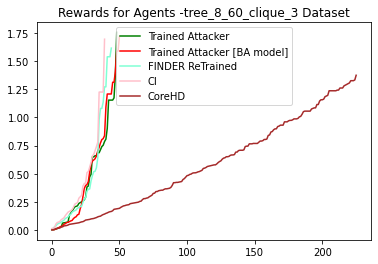

tree_8_80_clique_4
[3, 19, 255, 147, 264, 9, 226, 121, 12, 21, 99, 44, 176, 32, 49, 33, 68, 241, 199, 48, 208, 73, 267, 265, 96, 145, 138, 1, 85, 112, 163, 242, 185, 123, 141, 197, 150, 34, 104, 207, 128, 15, 107, 54, 29, 60, 243, 237, 41, 257, 22, 100]
[3, 19, 119, 255, 99, 226, 123, 98, 170, 267, 264, 176, 208, 44, 242, 68, 48, 33, 21, 265, 197, 185, 145, 1, 112, 150, 202, 243, 163, 9, 96, 85, 138, 73, 141, 128, 54, 64, 58, 211, 43, 53, 29, 31, 32, 69, 34, 249, 42, 47, 41, 45, 59, 49]


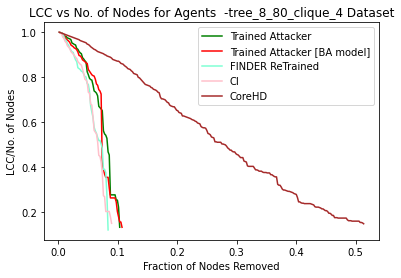

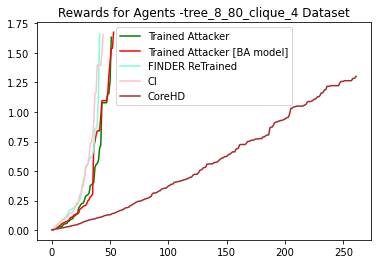

tree_8_100_clique_5
[231, 3, 76, 6, 11, 108, 187, 53, 31, 143, 109, 226, 13, 63, 7, 35, 61, 211, 52, 51, 125, 8, 36, 179, 264, 174, 30, 10, 29, 142, 110, 62, 251, 242, 267, 165, 79, 237, 260, 158, 219, 111, 54, 261, 89, 172, 195, 271, 9, 41, 72, 254, 73, 43, 170, 159, 151, 153, 47, 48, 122]
[3, 76, 6, 143, 109, 62, 51, 124, 108, 187, 179, 35, 237, 219, 10, 61, 29, 36, 8, 264, 172, 271, 104, 251, 261, 242, 267, 122, 11, 158, 165, 260, 142, 111, 102, 125, 79, 226, 195, 44, 206, 72, 46, 48, 40, 42, 59]


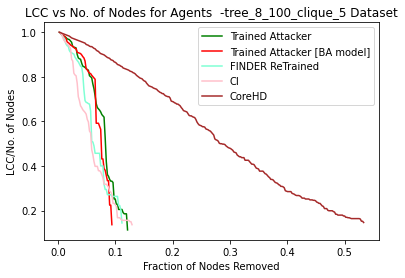

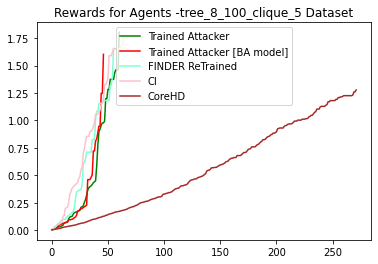

tree_8_20_diamond_1
[160, 172, 56, 15, 275, 260, 254, 102, 128, 458, 378, 533, 599, 532, 150, 261, 155, 202, 23, 4, 279, 274, 222, 69, 169, 29, 248, 546, 50, 246, 2, 177, 539, 536, 41, 71, 170, 548, 259, 278, 220, 200, 58, 64, 1, 168, 210, 535, 221, 179, 225, 118, 3, 262, 53, 537, 541, 320, 543, 265, 154, 59, 547, 544, 277, 25, 256, 232, 629, 268, 49, 17, 61, 14, 54, 131, 180, 214, 191, 62, 52, 55]
[172, 56, 532, 15, 463, 464, 128, 458, 150, 102, 378, 261, 590, 454, 248, 548, 275, 246, 4, 535, 547, 537, 557, 63, 539, 545, 543, 107, 544, 28, 108, 225, 118, 1, 2, 3, 533, 277, 232, 536, 541, 222, 202, 274, 180, 139, 169, 27, 36, 256, 13, 69, 78, 23, 226, 64, 154, 29, 170, 219, 58, 187, 71, 193, 542, 546, 538, 386, 99, 540, 156, 188, 41, 157, 242, 200, 253, 553, 50, 194, 189, 190, 49, 562, 572, 577, 264, 278, 131, 586, 594, 599, 390, 607, 614, 619, 62, 24, 60]


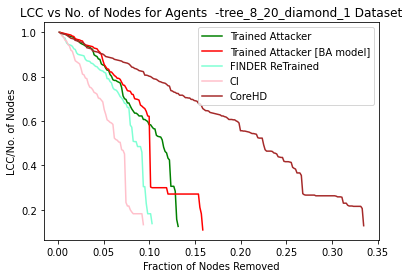

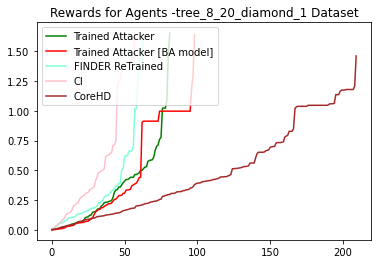

tree_8_40_diamond_2
[208, 143, 253, 122, 313, 248, 76, 29, 587, 190, 558, 68, 592, 31, 171, 168, 532, 178, 373, 552, 241, 41, 153, 154, 312, 46, 1, 226, 62, 269, 194, 218, 566, 2, 15, 16, 245, 57, 19, 148, 149, 256, 561, 198, 169, 556, 219, 160, 609, 565, 107, 203, 11, 258, 571, 230, 176, 549, 193, 560, 179, 554, 12, 200, 242, 3, 547, 270, 235, 249, 204, 184, 261, 166, 222, 50, 568, 548, 555, 557, 562, 569, 573, 616, 656, 550, 563, 18, 113, 206, 45, 346, 214, 575, 229, 17, 75, 66, 65, 43, 237, 167, 239, 551, 150, 259, 158, 195, 61, 48, 228, 47, 67, 266, 567, 272, 267, 24, 216, 186, 182, 72, 69, 220, 189]
[143, 208, 313, 122, 248, 554, 148, 532, 396, 154, 62, 149, 46, 552, 373, 312, 171, 31, 29, 241, 226, 567, 37, 139, 140, 575, 169, 558, 374, 375, 565, 1, 127, 128, 33, 192, 566, 609, 194, 568, 557, 549, 547, 3, 113, 573, 562, 548, 179, 569, 555, 556, 58, 468, 616, 551, 656, 622, 8, 34, 398, 563, 461, 550, 222, 116, 491, 193, 270, 348, 723, 571, 161, 517, 200, 45, 201, 230, 150, 166, 21

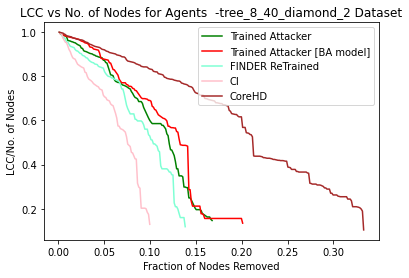

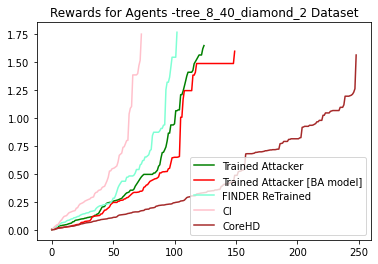

tree_8_60_diamond_3
[110, 274, 620, 7, 27, 28, 81, 289, 625, 158, 173, 214, 199, 600, 65, 592, 254, 499, 611, 242, 621, 36, 148, 608, 229, 241, 279, 6, 212, 84, 599, 602, 185, 119, 743, 583, 237, 164, 324, 400, 628, 230, 66, 306, 42, 587, 193, 216, 782, 631, 580, 257, 222, 197, 9, 35, 512, 218, 240, 207, 596, 147, 194, 202, 226, 215, 22, 281, 204, 238, 597, 639, 263, 151, 172, 49, 591, 90, 13, 576, 127, 294, 69, 232, 265, 601, 616, 244, 285, 478, 276, 260, 189, 614, 44, 61, 585, 626, 593, 235, 248, 236, 177, 603, 195, 590, 203, 663, 288, 259, 280, 211, 272, 395, 201, 45, 174, 213, 277, 153, 578, 605, 184, 53, 223, 584, 594, 598, 261, 39, 258, 181, 606, 610, 615, 607, 609, 613, 619, 624, 269, 629, 41, 773, 179, 196, 278, 198, 623, 579, 292, 664, 47, 186, 299, 62, 283, 169, 297, 12]
[110, 620, 625, 28, 81, 608, 602, 600, 592, 611, 621, 599, 400, 583, 177, 6, 163, 173, 324, 416, 103, 113, 158, 148, 65, 36, 185, 603, 241, 230, 221, 119, 237, 307, 166, 73, 588, 271, 593, 622, 626, 627, 601,

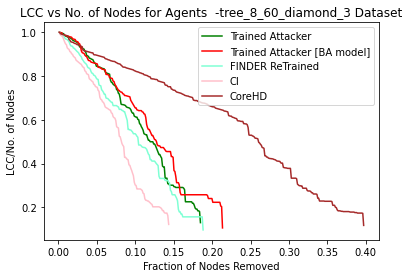

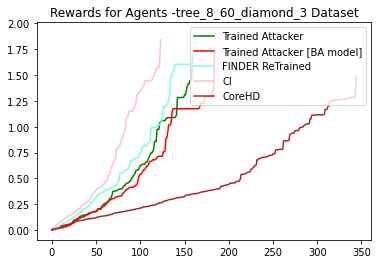

tree_8_80_diamond_4
[107, 351, 56, 80, 132, 716, 717, 272, 275, 52, 366, 96, 221, 362, 420, 185, 524, 315, 113, 166, 323, 233, 290, 304, 644, 726, 194, 624, 423, 767, 225, 728, 257, 402, 86, 206, 231, 153, 607, 118, 663, 247, 289, 205, 263, 237, 365, 488, 640, 630, 27, 629, 197, 609, 196, 183, 695, 612, 53, 222, 223, 611, 324, 127, 347, 13, 90, 295, 279, 87, 424, 292, 73, 202, 626, 186, 43, 209, 282, 174, 215, 429, 298, 824, 297, 301, 432, 631, 180, 199, 276, 189, 294, 162, 634, 14, 203, 813, 643, 178, 605, 238, 245, 182, 177, 165, 71, 281, 169, 645, 168, 707, 625, 167, 599, 72, 17, 15, 598, 602, 179, 604, 216, 637, 42, 748, 187, 214, 627, 188, 608, 278, 218, 284, 64, 261, 621, 119, 711, 65, 66, 191, 689, 701, 804, 130, 131, 67, 296, 201, 614, 287, 212, 211, 613, 184, 600, 428, 258, 597, 603, 267, 3, 606, 610, 619, 260, 622, 636, 642, 648, 270, 175, 195, 47, 638, 652, 246, 163, 228, 649, 690, 62, 650, 51, 41]
[351, 96, 132, 319, 320, 80, 206, 488, 366, 185, 402, 646, 644, 267, 86, 212,

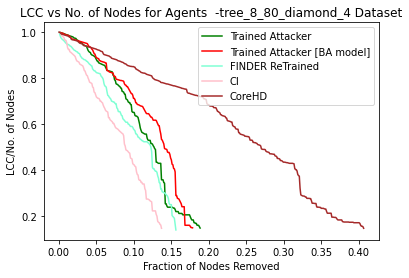

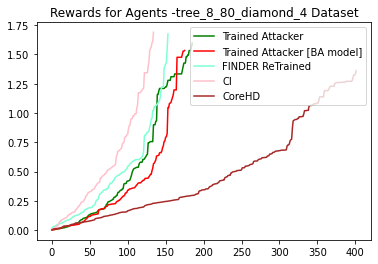

tree_8_100_diamond_5
[11, 48, 314, 685, 50, 146, 51, 190, 52, 6, 260, 0, 263, 308, 658, 656, 302, 355, 160, 294, 123, 777, 621, 616, 197, 681, 676, 741, 728, 426, 13, 60, 140, 406, 44, 255, 293, 819, 675, 36, 315, 171, 652, 313, 686, 211, 617, 69, 272, 273, 178, 274, 502, 479, 627, 645, 223, 365, 243, 195, 109, 182, 650, 469, 275, 465, 169, 655, 608, 680, 257, 887, 91, 231, 288, 669, 166, 228, 286, 344, 253, 882, 278, 20, 21, 653, 192, 38, 269, 519, 262, 501, 244, 270, 739, 22, 778, 89, 1063, 678, 59, 196, 127, 207, 747, 217, 55, 811, 259, 53, 303, 170, 622, 623, 149, 92, 80, 241, 173, 210, 468, 451, 626, 214, 8, 684, 54, 208, 277, 216, 625, 247, 564, 661, 607, 292, 287, 279, 238, 296, 200, 280, 281, 58, 201, 74, 299, 237, 283, 174, 753, 657, 65, 261, 180, 242, 220, 264]
[146, 685, 406, 355, 44, 60, 189, 49, 140, 38, 11, 187, 52, 23, 675, 658, 656, 247, 676, 273, 491, 686, 313, 149, 564, 681, 502, 725, 92, 819, 365, 967, 882, 617, 234, 109, 211, 93, 94, 652, 532, 171, 650, 465, 256, 22

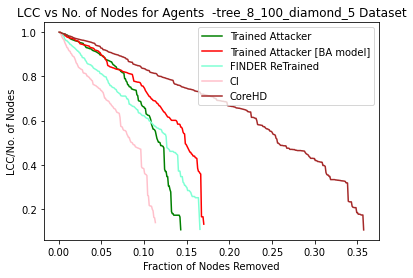

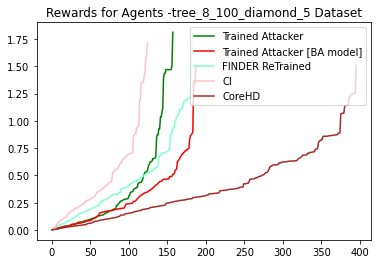

tree_8_20_cycle_1
[54, 14, 52, 53, 24, 2, 235, 22, 261, 187, 25, 23, 212, 227, 259, 156, 183, 21, 79, 81, 82, 5, 59, 208, 50, 67, 73, 234, 31, 16, 17, 63, 65, 20]
[54, 53, 5, 261, 235, 150, 82, 316, 79, 2, 156, 417, 104, 183, 259, 187, 208, 19, 59, 17, 15, 118, 38, 14, 50, 57, 63, 66, 51, 60, 58, 62, 18, 22, 23]


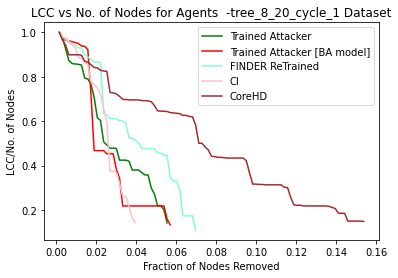

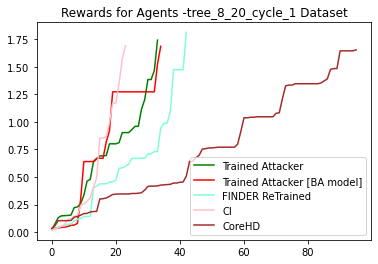

tree_8_40_cycle_2
[9, 179, 6, 182, 22, 15, 102, 39, 40, 37, 63, 64, 24, 38, 746, 266, 25, 242, 216, 192, 170, 243, 27, 154, 246, 268, 270, 208, 140, 178, 65, 194, 254, 56, 118, 167, 228, 8, 87, 151, 165, 33, 23, 203, 116, 10]
[102, 365, 366, 90, 64, 154, 266, 40, 38, 208, 22, 51, 170, 243, 242, 216, 116, 228, 268, 140, 192, 254, 270, 152, 226, 322, 80, 178, 463, 115, 13, 25, 513, 514, 127, 204, 65, 632, 193, 8, 14, 44, 35, 61, 42, 46, 165, 640, 23]


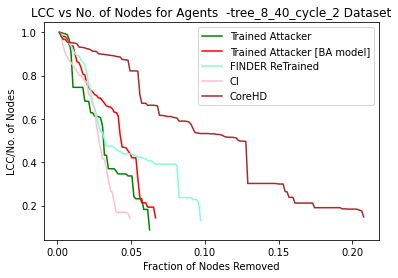

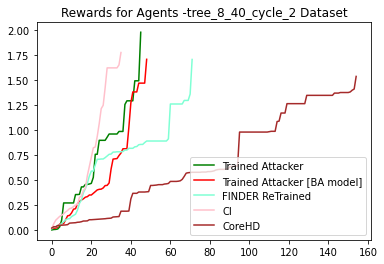

tree_8_60_cycle_3
[231, 13, 52, 53, 17, 18, 19, 16, 66, 11, 44, 12, 48, 45, 15, 62, 29, 63, 75, 80, 163, 567, 56]
[231, 250, 110, 268, 19, 196, 180, 215, 37, 151, 143, 48, 233, 63, 66, 45, 29, 160, 35, 163, 223, 205, 244, 142, 278, 27, 277, 170, 188, 436, 108, 473, 117, 258, 178, 213, 1, 249, 171, 207, 275, 46, 241, 224, 69, 736, 251, 36, 65, 51, 43, 446, 49, 47, 16]


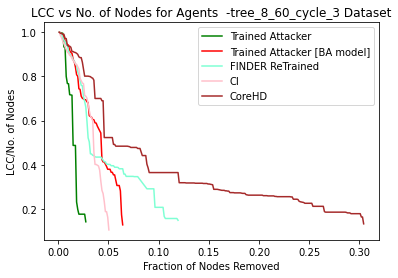

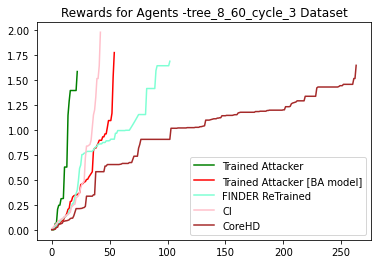

tree_8_80_cycle_4
[244, 4, 60, 14, 21, 61, 58, 7, 22, 28, 34, 11, 47, 48, 35, 113, 258, 918, 251, 114, 181, 201, 18, 272, 13, 53, 54, 73, 202, 208, 74, 84, 237, 195, 59, 79, 242, 277, 167, 164, 264, 154, 173, 63, 249, 254, 196, 187, 221, 256, 214, 12]
[244, 61, 22, 222, 67, 58, 54, 272, 113, 258, 208, 202, 148, 195, 41, 4, 48, 251, 462, 28, 141, 35, 7, 201, 181, 243, 14, 196, 174, 147, 188, 154, 368, 91, 160, 142, 254, 257, 215, 264, 355, 87, 270, 381, 382, 94, 328, 329, 80, 114, 84, 437, 107, 237, 283, 26, 738, 815, 39, 249, 166, 742, 797, 33, 37]


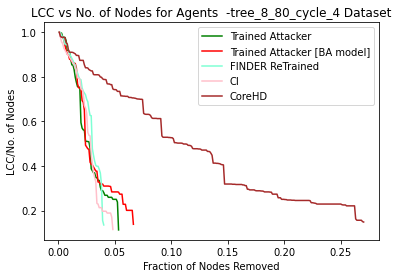

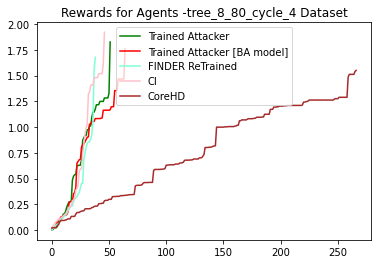

tree_8_100_cycle_5
[111, 112, 10, 44, 45, 245, 250, 164, 11, 51, 7, 0, 31, 17, 49, 33, 6, 9, 40, 256, 652, 267, 56, 12, 57, 34, 228, 54, 28, 15, 66, 832, 234, 261, 221, 76, 216, 177, 977, 647]
[45, 245, 250, 164, 216, 267, 54, 17, 63, 49, 215, 28, 256, 40, 51, 234, 239, 69, 177, 57, 146, 66, 198, 159, 76, 221, 11, 34, 111, 228, 647, 152, 187, 255, 272, 278, 266, 182, 209, 162, 233, 176, 252, 261, 612, 397, 99, 22, 297, 73, 327, 81, 549, 138, 112, 556, 140, 372, 373, 92, 244, 6, 417, 418, 105, 204, 77, 289, 193, 42]


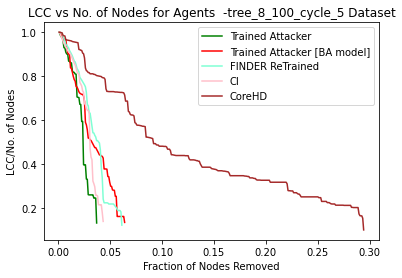

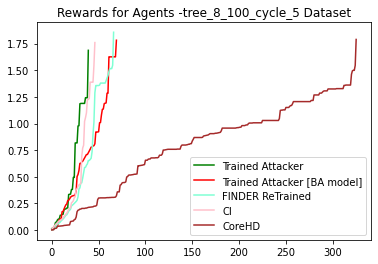

tree_8_20_star_1
[225, 224, 21, 71, 30, 59, 219, 271, 166, 245, 142, 149, 50, 158, 66, 1, 37, 46, 96, 168, 16, 220, 7, 259, 27, 9, 237, 210, 163, 109, 11, 104, 47, 125, 48, 266, 230, 17, 192, 145, 188, 101, 68, 39, 156, 67, 72, 205]
[225, 71, 21, 30, 59, 142, 245, 149, 168, 27, 50, 37, 66, 15, 220, 20, 210, 46, 185, 16, 109, 259, 163, 104, 1, 237, 125, 271, 190, 219, 192, 188, 230, 224, 165, 217, 47, 144, 40, 53, 247, 42, 39, 68, 70, 48, 55, 67, 57, 72, 145, 139, 69, 170, 49, 52]


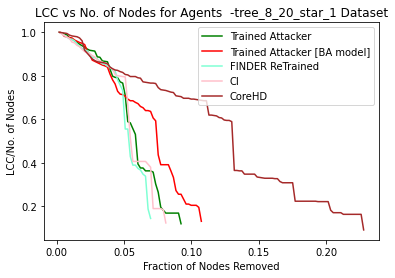

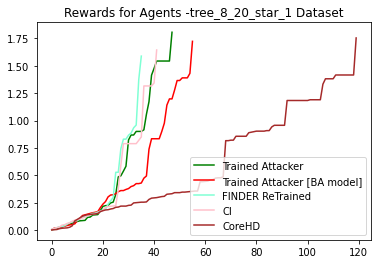

tree_8_40_star_2
[130, 28, 43, 0, 254, 150, 187, 125, 92, 53, 57, 16, 41, 240, 98, 238, 15, 215, 55, 83, 64, 65, 27, 71, 183, 67, 186, 22, 88, 190, 18, 152, 158, 177, 200, 163, 89, 189, 266, 87, 4, 237, 159, 202, 39, 227, 105, 40, 276, 13, 149, 54, 50, 259, 180, 235, 62, 220, 136, 48, 10]
[130, 28, 43, 92, 4, 16, 55, 98, 238, 215, 83, 158, 71, 174, 57, 244, 65, 67, 152, 186, 53, 159, 41, 15, 18, 190, 150, 22, 200, 178, 0, 227, 240, 187, 266, 87, 237, 389, 105, 125, 189, 39, 154, 163, 52, 253, 60, 47, 68, 50, 62, 535, 54, 72, 69, 542, 38, 40, 73, 48, 149, 202, 63, 27, 12]


tree_8_60_star_3
[80, 227, 107, 235, 209, 268, 9, 218, 116, 45, 126, 271, 142, 172, 200, 42, 43, 36, 54, 64, 22, 27, 176, 193, 17, 90, 275, 266, 263, 240, 253, 99, 119, 72, 210, 160, 141, 278, 228, 283, 124, 191, 134, 150, 18, 104, 279, 97, 7, 30, 158, 25, 70, 15, 181, 152, 81, 69, 59, 24, 63, 5, 65]
[80, 227, 107, 126, 200, 235, 142, 172, 218, 271, 193, 176, 210, 45, 268, 43, 64, 42, 36, 54, 22, 244, 27, 160, 275, 17, 266, 283, 228, 99, 124, 9, 209, 240, 90, 280, 278, 253, 97, 116, 134, 141, 150, 72, 18, 152, 191, 181, 38, 7, 30, 52, 328, 330, 262, 157, 11, 70, 50, 329, 331, 269, 63, 241, 51, 69, 81, 233, 170, 173, 188, 206, 211, 264, 281, 6]


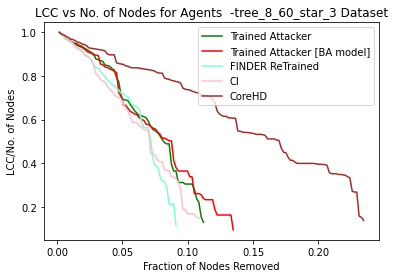

tree_8_80_star_4
[51, 7, 217, 55, 133, 281, 174, 155, 29, 278, 41, 23, 97, 21, 218, 50, 36, 34, 67, 27, 28, 31, 132, 33, 91, 160, 90, 112, 191, 215, 85, 149, 228, 262, 157, 240, 177, 120, 214, 126, 140, 252, 98, 8, 173, 147, 201, 37, 188, 231, 92, 221, 70, 48, 11, 151, 45, 166, 63, 213, 162, 53, 189, 14, 68, 211, 59, 323, 40, 0]
[51, 41, 217, 7, 97, 55, 133, 174, 281, 278, 258, 155, 63, 21, 207, 33, 214, 36, 180, 48, 265, 50, 34, 241, 27, 254, 28, 157, 231, 222, 85, 277, 67, 177, 160, 215, 149, 126, 188, 221, 173, 120, 92, 140, 98, 166, 147, 240, 228, 69, 200, 152, 57, 233, 251, 52, 38, 46, 270, 153, 68, 49, 10, 35, 201, 42, 471, 65, 45, 218, 275, 8]


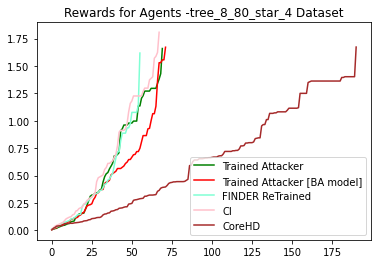

tree_8_100_star_5
[28, 67, 120, 293, 89, 11, 65, 377, 69, 95, 284, 184, 87, 62, 17, 44, 154, 39, 218, 201, 118, 602, 213, 55, 254, 266, 20, 567, 50, 147, 176, 261, 22, 294, 159, 129, 71, 73, 6, 134, 123, 156, 287, 106, 200, 78, 111, 100, 241, 170, 94, 84, 212, 275, 216, 230, 353, 274, 177, 15, 63, 48, 109, 68, 271, 207, 278]
[247, 28, 187, 293, 67, 87, 159, 201, 254, 154, 261, 176, 294, 147, 65, 17, 278, 55, 44, 50, 266, 184, 39, 69, 120, 269, 84, 219, 22, 62, 207, 156, 216, 225, 200, 149, 287, 11, 106, 20, 218, 241, 118, 6, 170, 289, 123, 71, 111, 78, 183, 100, 212, 134, 275, 95, 177, 165, 274, 230, 191, 271, 34, 213, 237, 285, 48, 148, 63, 56, 228, 192, 40]


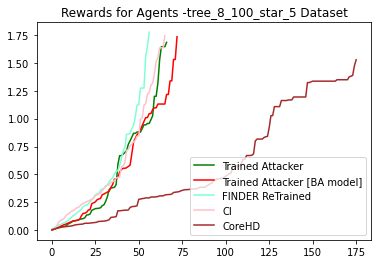

tree_8_20_grid_1
[244, 477, 589, 261, 595, 854, 160, 191, 43, 566, 98, 1176, 1016, 1038, 216, 577, 560, 1039, 648, 618, 125, 901, 548, 594, 771, 19, 60, 817, 792, 708, 517, 710, 952, 709, 315, 164, 247, 590, 588, 1082, 495, 431, 755, 928, 828, 696, 824, 570, 787, 794, 801, 1065, 1074, 998, 277, 52, 583, 990, 976, 933, 982, 596, 807, 811, 813, 764, 139, 571, 1142, 768, 185, 563, 1213, 984, 940, 1121, 1072, 587, 62, 721, 730, 1021, 14, 653, 1023, 444, 881, 352, 177, 833, 943, 567, 1079, 791, 597, 831, 837, 193, 242, 157, 558, 246, 36, 147, 1013, 562, 997, 695, 142, 948, 677, 1045, 607, 1050, 750, 780, 150, 136, 751, 726, 891, 1154, 1201, 917, 28, 1224, 657, 953, 619, 686, 250, 1159, 896, 1183, 4, 18, 22, 12, 924, 568, 701, 203, 955, 422, 616, 270, 804, 731, 738, 1113, 650, 893, 55, 347, 1198, 865, 672, 992, 853, 272, 1189, 1128, 575, 872, 1207, 215, 201, 186, 226, 604, 840, 287, 410, 1095, 926, 688, 959, 1161, 1219, 564, 847, 635, 1134, 230, 220, 165, 784, 799, 724, 719, 239, 561, 814, 1

tree_8_40_grid_2
[251, 627, 310, 837, 250, 624, 1022, 295, 781, 763, 198, 672, 205, 789, 127, 191, 1659, 804, 597, 716, 793, 611, 1278, 639, 1142, 249, 919, 817, 48, 840, 532, 157, 178, 600, 843, 1282, 704, 1357, 629, 1823, 482, 32, 1085, 1776, 1252, 136, 610, 625, 1453, 64, 307, 857, 87, 654, 720, 648, 167, 1621, 89, 768, 592, 954, 264, 710, 824, 841, 1679, 634, 981, 728, 740, 1346, 350, 605, 1105, 1108, 1075, 1524, 1000, 1398, 1034, 586, 651, 593, 1898, 641, 1727, 1258, 615, 1415, 1595, 1592, 1597, 1338, 1590, 846, 827, 1706, 91, 1247, 687, 1279, 1285, 1316, 1041, 588, 1028, 712, 994, 957, 901, 297, 718, 267, 66, 252, 1347, 1465, 1466, 325, 1321, 616, 1249, 1255, 864, 612, 659, 236, 637, 1066, 1043, 1046, 1677, 220, 649, 204, 603, 1295, 1121, 1540, 63, 202, 601, 1176, 1183, 1876, 866, 872, 875, 16, 1068, 199, 598, 1497, 1501, 632, 993, 299, 910, 19, 262, 633, 5, 797, 1078, 1086, 972, 977, 644, 58, 1140, 645, 635, 636, 422, 1507, 1104, 614, 623, 275, 640, 698, 1906, 1361, 1150, 1767, 

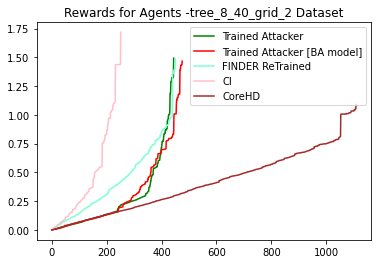

tree_8_60_grid_3
[148, 383, 1453, 758, 735, 780, 313, 1156, 943, 283, 852, 813, 691, 1197, 1418, 621, 604, 100, 2261, 1733, 1098, 1110, 952, 675, 1356, 200, 1161, 2298, 856, 1188, 1317, 2274, 1800, 16, 1592, 40, 204, 173, 1998, 151, 746, 122, 631, 824, 742, 1915, 972, 946, 509, 214, 187, 414, 152, 1215, 770, 617, 1136, 1942, 783, 198, 808, 271, 1028, 1036, 218, 48, 220, 1084, 1721, 1300, 2555, 186, 1736, 1262, 662, 159, 169, 1560, 827, 797, 698, 767, 694, 1029, 651, 640, 1472, 45, 1851, 1157, 1374, 2415, 175, 652, 1741, 145, 1155, 1587, 626, 826, 959, 298, 692, 1928, 928, 2297, 782, 1060, 1799, 1198, 33, 1987, 657, 248, 823, 215, 696, 1159, 1250, 2217, 2357, 636, 1295, 961, 951, 963, 970, 1530, 1598, 1174, 1368, 1039, 1645, 1176, 1299, 685, 975, 279, 1246, 1247, 1257, 699, 24, 1340, 630, 887, 476, 676, 659, 2499, 1756, 1005, 247, 1207, 1214, 1218, 1222, 909, 912, 1780, 1407, 1876, 1395, 1805, 432, 2469, 2465, 885, 246, 1264, 469, 1611, 2585, 261, 673, 664, 759, 764, 166, 864, 293, 1270

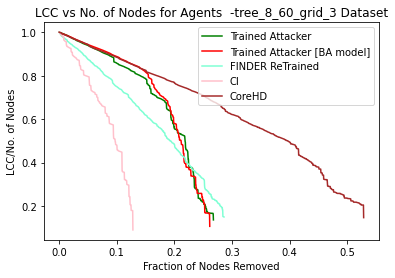

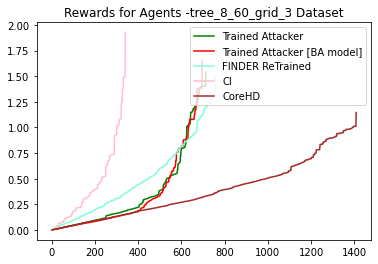

tree_8_80_grid_4
[1131, 1066, 122, 368, 367, 763, 2562, 276, 707, 218, 295, 717, 635, 792, 222, 2784, 3096, 3016, 1032, 1638, 1758, 1761, 2374, 555, 1009, 1558, 2287, 886, 2269, 2279, 1905, 2281, 1617, 674, 875, 758, 881, 787, 2312, 605, 318, 6, 27, 28, 899, 1467, 72, 1154, 1919, 1924, 727, 1454, 1626, 1631, 1174, 1175, 1095, 672, 1926, 785, 803, 220, 1797, 1354, 46, 1475, 1482, 1286, 1799, 1011, 2293, 1614, 170, 2187, 1671, 628, 2008, 1849, 390, 2300, 812, 2709, 2340, 2060, 747, 253, 41, 301, 722, 839, 248, 1622, 697, 230, 693, 691, 1623, 261, 725, 1248, 2320, 2142, 1138, 80, 1070, 157, 907, 909, 2807, 618, 191, 227, 249, 1180, 726, 1001, 1693, 2248, 202, 676, 651, 15, 1581, 2577, 1621, 386, 816, 2788, 2240, 1205, 798, 212, 1706, 1701, 29, 74, 811, 1042, 210, 1633, 2291, 2865, 2375, 1512, 2803, 761, 234, 685, 1105, 613, 250, 679, 197, 152, 665, 1690, 512, 2045, 2252, 533, 530, 2401, 1290, 1192, 2046, 140, 2169, 827, 1807, 694, 3215, 1808, 1371, 2370, 1506, 2812, 2143, 2324, 347, 105, 

tree_8_100_grid_5
[1237, 2584, 2648, 2733, 73, 1486, 1488, 1416, 1355, 668, 2355, 1067, 1843, 887, 892, 1012, 2902, 1061, 1248, 1048, 1105, 3856, 1489, 306, 2315, 1265, 1249, 921, 1417, 2186, 1509, 643, 813, 59, 2082, 3091, 3093, 1119, 1666, 310, 194, 1307, 2484, 1693, 796, 1016, 816, 786, 793, 801, 1253, 4075, 730, 779, 1889, 1114, 196, 1443, 2538, 3169, 113, 1262, 2569, 726, 646, 161, 626, 1400, 2701, 2556, 2266, 280, 417, 2374, 2269, 862, 648, 58, 1277, 1259, 1268, 561, 315, 3921, 3455, 213, 2913, 745, 1440, 1989, 1606, 2164, 2173, 1470, 1902, 1220, 3466, 664, 763, 1673, 1793, 172, 278, 1238, 1736, 3431, 1088, 927, 81, 3396, 2298, 253, 1256, 2193, 418, 245, 195, 2191, 805, 343, 5, 22, 71, 2879, 1672, 1454, 3390, 1491, 1799, 2250, 953, 1024, 929, 60, 676, 2794, 1276, 1031, 1051, 821, 1492, 2228, 2237, 2240, 3220, 4065, 2026, 974, 1639, 2078, 625, 2506, 2246, 414, 1990, 1985, 868, 1883, 1086, 677, 1387, 1712, 2482, 1006, 2006, 260, 282, 3353, 2923, 2815, 2617, 2612, 2458, 3254, 2535, 

In [6]:
file_list = ['tree_8_20_house_1', 'tree_8_40_house_2', 'tree_8_60_house_3', 'tree_8_80_house_4', 'tree_8_100_house_5', 'tree_8_20_fan_1', 'tree_8_40_fan_2', 'tree_8_60_fan_3', 'tree_8_80_fan_4', 'tree_8_100_fan_5', 'tree_8_20_clique_1', 'tree_8_40_clique_2', 'tree_8_60_clique_3', 'tree_8_80_clique_4', 'tree_8_100_clique_5', 'tree_8_20_diamond_1', 'tree_8_40_diamond_2', 'tree_8_60_diamond_3', 'tree_8_80_diamond_4', 'tree_8_100_diamond_5', 'tree_8_20_cycle_1', 'tree_8_40_cycle_2', 'tree_8_60_cycle_3', 'tree_8_80_cycle_4', 'tree_8_100_cycle_5', 'tree_8_20_star_1', 'tree_8_40_star_2', 'tree_8_60_star_3', 'tree_8_80_star_4', 'tree_8_100_star_5', 'tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3','tree_8_80_grid_4', 'tree_8_100_grid_5']
graph_path ="./Dataset/Validation/Motifs_Attached/Tree/" 
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])

In [7]:
file = ['differentGraph','BAGraph','FinderReTrained','CI','CoreHD']
print('Test Name','\t\t','Mix','\t','BA','\t','FIN','\t','CI''\t','CoreHD''\t','BEST')
for i, element in enumerate(AUC):
    for nested_tem in element:
        if isinstance(nested_tem, str): 
            print(nested_tem, end=" => \t")
        else:
            print("{:.2f}".format(nested_tem), end=" \t")
    
    best = np.argmin(np.array(element[1:]).astype(float))
    print(file[best])
    print("")
print("===============================")

Test Name 		 Mix 	 BA 	 FIN 	 CI	 CoreHD	 BEST
tree_8_20_house_1 => 	42.21 	43.09 	46.11 	29.81 	137.65 	CI

tree_8_40_house_2 => 	61.71 	54.11 	61.16 	39.90 	192.78 	CI

tree_8_60_house_3 => 	60.99 	62.76 	67.08 	44.80 	244.77 	CI

tree_8_80_house_4 => 	88.02 	78.44 	85.30 	59.03 	277.59 	CI

tree_8_100_house_5 => 	93.54 	91.18 	98.86 	56.91 	311.23 	CI

tree_8_20_fan_1 => 	35.84 	35.10 	35.46 	29.13 	79.77 	CI

tree_8_40_fan_2 => 	30.25 	40.35 	34.64 	31.20 	85.98 	differentGraph

tree_8_60_fan_3 => 	35.02 	41.70 	33.68 	37.03 	100.96 	FinderReTrained

tree_8_80_fan_4 => 	37.20 	38.54 	38.05 	40.60 	97.03 	differentGraph

tree_8_100_fan_5 => 	39.02 	46.20 	36.06 	45.96 	85.00 	FinderReTrained

tree_8_20_clique_1 => 	38.56 	37.40 	32.93 	27.02 	97.11 	CI

tree_8_40_clique_2 => 	31.23 	30.04 	28.36 	29.33 	110.15 	FinderReTrained

tree_8_60_clique_3 => 	33.01 	33.33 	30.98 	27.86 	125.56 	CI

tree_8_80_clique_4 => 	37.79 	37.11 	31.11 	30.90 	144.94 	CI

tree_8_100_clique_5 => 	39.78 	

# New Synthetic Mortif

ba_60_10_house_1
[6, 0, 12, 9, 11, 8, 16, 19, 10, 5, 2, 24, 13, 44, 43, 46, 45, 1, 56, 54, 15, 21, 38, 40, 64, 70, 69]
[0, 6, 12, 9, 11, 8, 16, 19, 13, 5, 2, 24, 10, 46, 44, 43, 38, 1, 21, 45, 15, 54, 56, 64, 69, 71, 70]


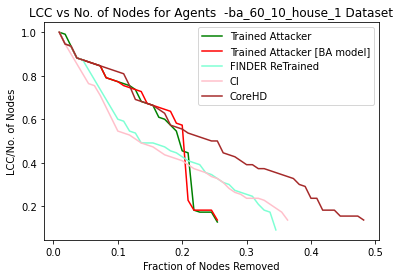

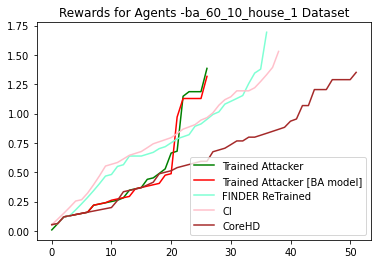

ba_60_20_house_2
[0, 47, 6, 1, 9, 8, 11, 10, 51, 7, 17, 59, 25, 2, 48, 61, 3, 5, 13, 74, 70, 76, 19, 78, 71, 79, 80, 66, 73, 146, 29, 14, 67, 42, 128, 72]
[0, 47, 6, 1, 9, 8, 11, 7, 10, 51, 17, 61, 25, 59, 3, 48, 13, 2, 5, 74, 146, 29, 72, 78, 67, 79, 66, 71, 73, 68, 80]


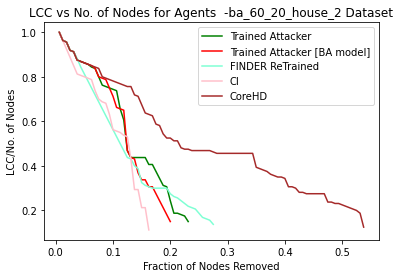

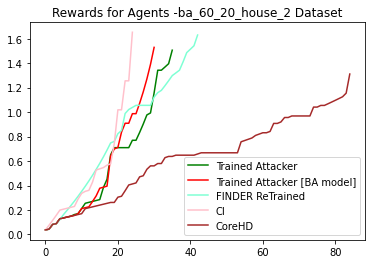

ba_60_30_house_3
[0, 6, 11, 7, 9, 36, 2, 12, 15, 1, 28, 29, 45, 5, 8, 13, 16, 24, 27, 53, 14, 41, 46, 43, 52, 47, 34, 114, 18, 37, 78, 82, 86, 35, 74, 44]
[0, 6, 11, 36, 9, 7, 28, 45, 1, 46, 15, 12, 8, 37, 27, 29, 13, 43, 2, 44, 52, 47, 34, 64, 4, 139, 5, 32, 208]


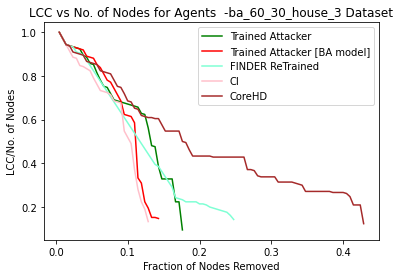

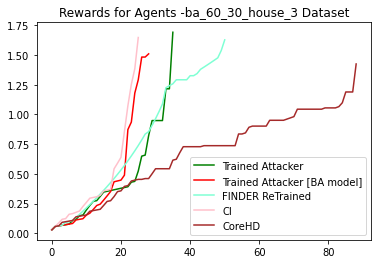

ba_60_10_fan_1
[0, 7, 5, 6, 44, 10, 22, 12, 35, 17, 9, 13, 24, 42, 11, 26, 47, 8, 32, 20, 45, 14, 48, 15, 55, 25, 1, 3, 40, 39]
[0, 7, 5, 6, 44, 10, 22, 9, 17, 35, 12, 13, 8, 42, 24, 48, 14, 11, 45, 26, 32, 47, 20, 15, 28, 3]


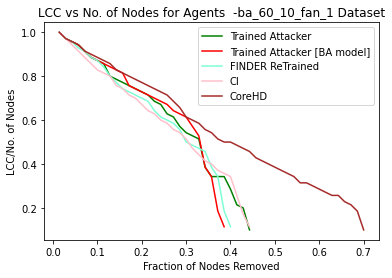

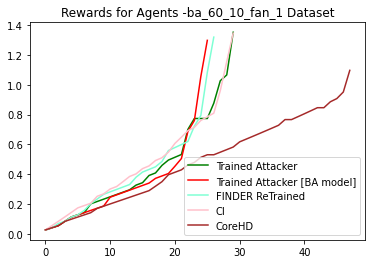

ba_60_20_fan_2
[0, 6, 12, 11, 40, 32, 10, 8, 38, 2, 7, 34, 13, 43, 17, 16, 9, 20, 41, 28, 14, 5, 4, 70, 18, 15, 55, 42, 29, 3]
[0, 6, 12, 32, 8, 11, 40, 10, 38, 2, 4, 7, 13, 34, 17, 43, 20, 16, 9, 63, 70, 28, 19, 18, 22, 29, 15]


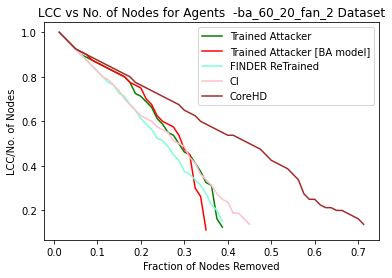

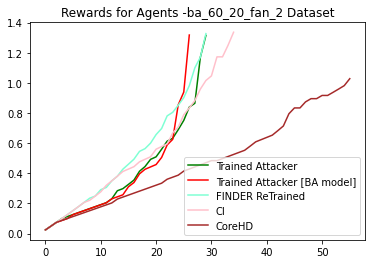

ba_60_30_fan_3
[6, 7, 2, 0, 8, 26, 9, 11, 46, 1, 35, 23, 12, 38, 25, 10, 48, 17, 13, 54, 3, 55, 50, 15, 14, 61, 53, 52]
[6, 2, 7, 0, 8, 26, 9, 1, 46, 11, 23, 35, 12, 25, 3, 38, 13, 54, 17, 55, 50, 10, 49, 64, 14, 48]


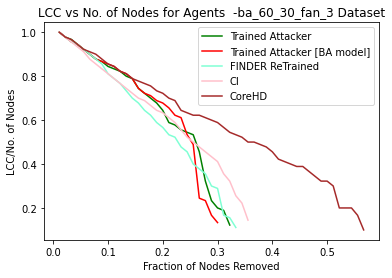

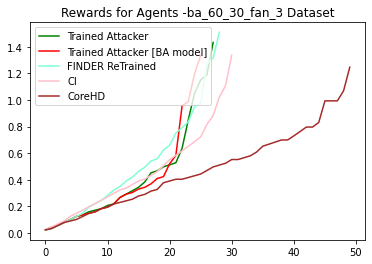

ba_60_10_clique_1
[6, 37, 0, 3, 1, 5, 11, 38, 8, 10, 25, 49, 23, 7, 15, 58, 39, 27, 28, 44, 56, 18, 14, 42, 2, 40]
[6, 37, 0, 3, 5, 1, 11, 38, 8, 10, 49, 25, 23, 7, 27, 58, 39, 15, 28, 22, 42, 14, 12, 40, 18]


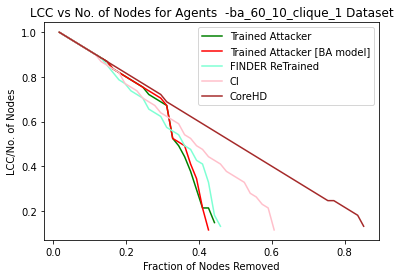

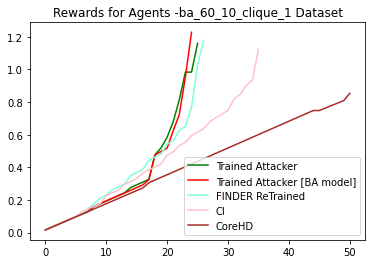

ba_60_20_clique_2
[9, 6, 20, 21, 47, 0, 23, 8, 2, 1, 3, 25, 7, 10, 40, 50, 13, 12, 38, 35, 48, 36, 54, 46, 43, 26, 51, 55, 41, 14, 32, 60, 58, 16]
[9, 6, 0, 23, 20, 21, 8, 1, 2, 3, 7, 40, 25, 10, 13, 12, 46, 38, 35, 36, 50, 48, 14, 54, 16, 55, 26, 11]


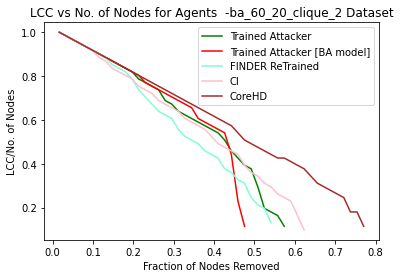

ba_60_30_clique_3
[20, 6, 7, 8, 23, 9, 0, 10, 13, 2, 11, 36, 22, 48, 21, 60, 52, 4, 56, 16, 34, 57, 15, 14, 19, 18, 58, 54, 5]
[6, 20, 7, 8, 9, 23, 0, 10, 2, 13, 11, 36, 22, 48, 60, 21, 52, 19, 58, 34, 4, 40, 16, 56, 14, 53, 35, 55]


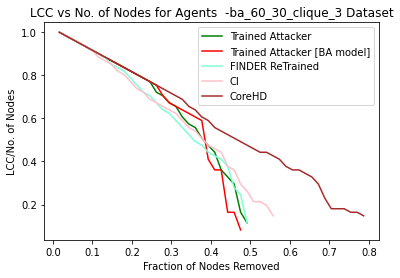

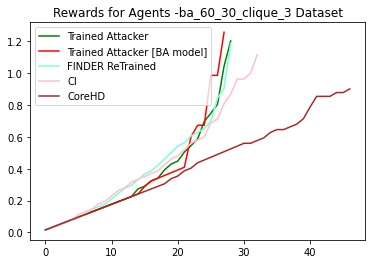

ba_60_10_diamond_1
[7, 0, 45, 3, 6, 10, 43, 8, 27, 9, 15, 36, 13, 5, 44, 12, 11, 30, 26, 34, 69, 2, 63, 70, 67, 110, 68, 65, 72, 71, 81, 17, 16, 66, 91, 96, 105, 114, 119, 52, 80, 60, 86, 55]
[7, 0, 3, 45, 10, 6, 8, 43, 27, 9, 36, 15, 5, 13, 44, 51, 2, 114, 12, 71, 26, 78, 34, 69, 96, 70, 110, 11, 91, 105, 30, 60, 66, 68, 63, 65, 67, 16, 72, 86, 81, 79, 119, 17, 49]


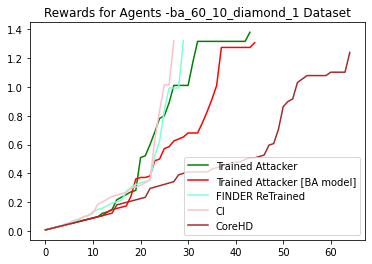

ba_60_20_diamond_2
[6, 13, 11, 8, 0, 22, 23, 45, 7, 15, 5, 10, 36, 61, 4, 9, 26, 1, 14, 42, 57, 30, 73, 76, 82, 117, 67, 63, 69, 28, 72, 74, 31, 47, 59, 79, 80, 83, 21, 84, 141, 93, 107, 49, 98, 122, 50, 99, 137, 146, 66, 112, 165, 170, 171, 179, 70, 127, 71, 75, 132, 151, 77, 155, 78, 160, 18, 41]
[6, 13, 11, 8, 0, 45, 22, 7, 23, 15, 5, 10, 36, 61, 4, 9, 26, 14, 35, 88, 57, 81, 73, 67, 137, 165, 179, 28, 63, 74, 80, 21, 49, 50, 66, 69, 70, 133, 71, 75, 78, 79, 82, 53, 42, 30, 43, 155, 38, 140, 87, 99, 93, 98, 107, 112, 117, 122, 127, 132, 146, 151, 160, 170, 174, 134, 77, 68, 1]


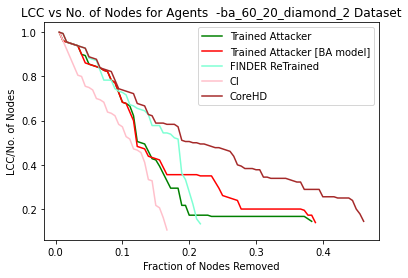

ba_60_30_diamond_3
[0, 2, 7, 8, 10, 6, 9, 1, 4, 16, 30, 28, 40, 34, 12, 5, 14, 11, 27, 3, 18, 45, 66, 43, 32, 31, 76, 74, 85, 91, 87, 70, 77, 89, 197, 81, 84, 67, 29, 234, 90, 222, 51, 38, 13]
[0, 2, 8, 10, 7, 6, 1, 9, 4, 16, 28, 30, 11, 40, 14, 12, 34, 66, 43, 45, 106, 31, 153, 54, 176, 234, 85, 87, 67, 79, 91, 89, 83, 74, 70, 77, 80, 84, 174, 90, 26, 48, 51, 56, 61, 63, 65, 71, 72, 73, 75, 78, 81, 133, 60]


ba_60_10_star_1
[2, 24, 6, 0, 10, 7, 14, 4, 12, 11, 8, 30, 27, 20, 48, 28, 50, 19, 13, 43, 35, 16, 33, 61, 9, 42, 40, 51]
[2, 6, 24, 0, 10, 7, 4, 14, 20, 12, 27, 8, 30, 11, 28, 48, 13, 50, 19, 43, 61, 16, 33, 35, 38]


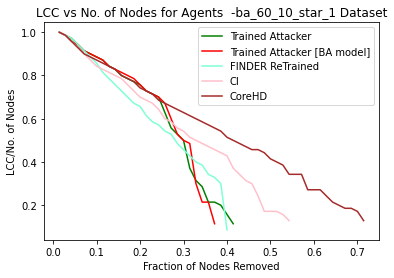

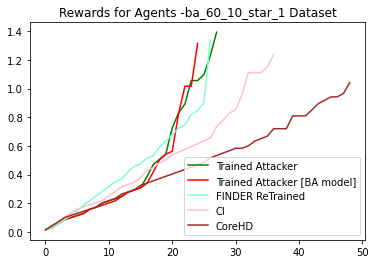

ba_60_20_star_2
[6, 7, 0, 8, 38, 11, 10, 3, 14, 45, 30, 31, 13, 63, 9, 49, 2, 53, 41, 52, 17, 16, 28, 19, 62, 47, 57, 58]
[6, 7, 0, 8, 38, 10, 11, 45, 14, 3, 30, 31, 49, 55, 62, 2, 63, 68, 9, 54, 53, 13, 4, 28, 41, 17]


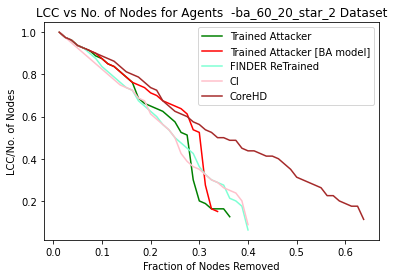

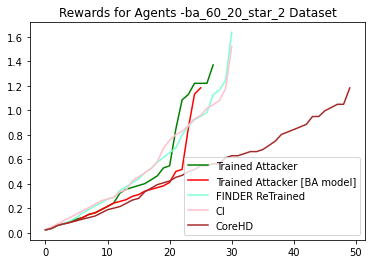

ba_60_30_star_3
[0, 5, 17, 1, 14, 9, 7, 3, 6, 8, 36, 18, 51, 10, 35, 42, 46, 19, 16, 55, 63, 22, 24, 59, 13, 45, 2, 31, 48, 52, 54]
[0, 5, 7, 14, 1, 17, 9, 3, 6, 51, 8, 18, 36, 10, 42, 35, 46, 65, 19, 16, 54, 63, 45, 41, 33, 2, 20, 48, 24, 22]


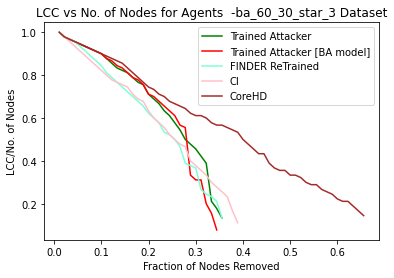

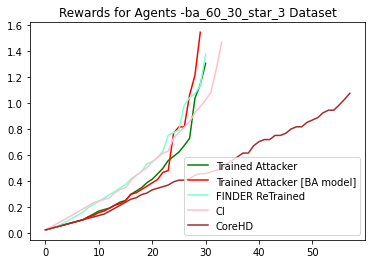

ba_60_10_grid_1
[7, 25, 1, 0, 6, 23, 42, 39, 24, 12, 40, 28, 26, 11, 9, 14, 10, 19, 8, 51, 120, 20, 41, 32, 70, 31, 4, 47]
[7, 25, 1, 6, 0, 23, 42, 39, 24, 12, 9, 40, 41, 28, 11, 10, 26, 19, 20, 8, 51, 31, 120, 70, 47, 89, 14, 129, 137, 114, 74, 81, 98, 106, 27, 17]


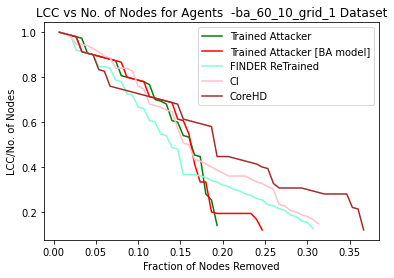

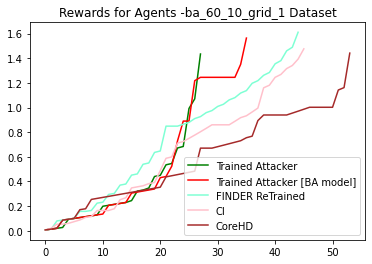

ba_60_20_grid_2
[0, 9, 29, 7, 13, 5, 17, 20, 21, 24, 18, 28, 32, 6, 10, 4, 12, 16, 14, 19, 27, 26, 2, 15, 33, 35, 50, 177, 3, 34, 53, 48, 178, 8, 61, 80, 55, 58, 45]
[0, 32, 5, 29, 6, 10, 7, 9, 4, 35, 27, 33, 55, 26, 38, 15, 40, 8, 12, 25, 51, 41, 61, 85, 87, 89, 121, 80, 203, 31, 92, 219, 211, 195, 116, 234, 164, 156, 226, 187, 100, 108, 132, 140, 148, 172, 179, 11, 3, 123, 39, 50]


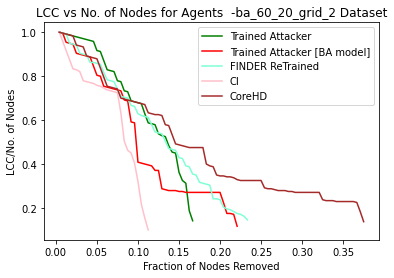

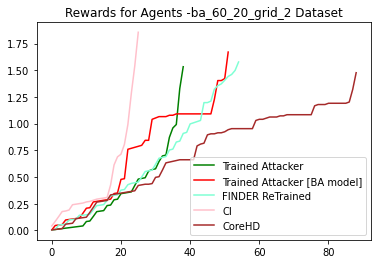

ba_60_30_grid_3
[0, 4, 5, 6, 2, 3, 7, 1, 8, 9, 10, 13, 33, 34, 43, 44, 54, 51, 14, 17, 26, 23, 27, 28, 31, 15, 20, 35, 57, 46, 37, 56, 45, 58, 69, 11, 48, 80, 55, 19, 42]
[6, 0, 5, 7, 8, 26, 43, 2, 1, 4, 27, 10, 9, 35, 31, 64, 49, 13, 20, 37, 91, 33, 203, 40, 45, 52, 42, 117, 138, 316, 253, 284, 245, 197, 189, 206, 167, 324, 214, 292, 229, 261, 159, 276, 94, 102, 109, 118, 126, 143, 151, 181, 237, 300, 308, 30]


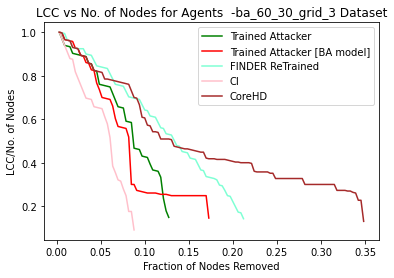

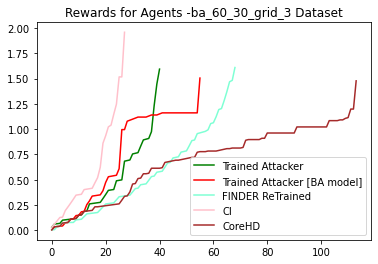

In [27]:
#file_list =['ba_60_10_house_1', 'ba_60_20_house_2', 'ba_60_30_house_3', 'ba_60_10_fan_1', 'ba_60_20_fan_2', 'ba_60_30_fan_3', 'ba_60_10_clique_1', 'ba_60_20_clique_2', 'ba_60_30_clique_3', 'ba_60_10_diamond_1', 'ba_60_20_diamond_2', 'ba_60_30_diamond_3', 'ba_60_10_cycle_1', 'ba_60_20_cycle_2', 'ba_60_30_cycle_3', 'ba_60_10_star_1', 'ba_60_20_star_2', 'ba_60_30_star_3', 'ba_60_10_grid_1', 'ba_60_20_grid_2', 'ba_60_30_grid_3']
file_list =['ba_60_10_house_1', 'ba_60_20_house_2', 'ba_60_30_house_3', 'ba_60_10_fan_1', 'ba_60_20_fan_2', 'ba_60_30_fan_3', 'ba_60_10_clique_1', 'ba_60_20_clique_2', 'ba_60_30_clique_3', 'ba_60_10_diamond_1', 'ba_60_20_diamond_2', 'ba_60_30_diamond_3', 'ba_60_10_star_1', 'ba_60_20_star_2', 'ba_60_30_star_3', 'ba_60_10_grid_1', 'ba_60_20_grid_2', 'ba_60_30_grid_3']
graph_path = "./Dataset/Validation/GNNexplanation/New/"
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])

tree_4_10_house_1
[40, 7, 47, 4, 11, 13, 8, 43, 35, 41, 46, 51, 3, 12, 10, 14, 42]
[40, 18, 4, 47, 11, 2, 13, 16, 12, 43, 3, 41, 57]


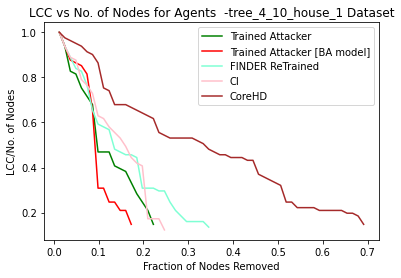

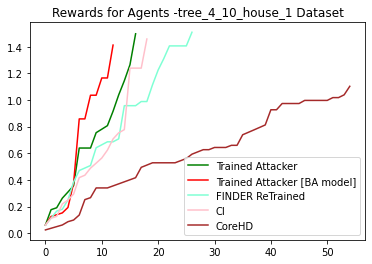

tree_4_20_house_2
[18, 26, 9, 29, 35, 16, 38, 93, 92, 14, 56, 5, 54, 51, 50, 10, 19, 46, 52, 42, 0, 7, 47, 53]
[26, 18, 23, 29, 0, 56, 20, 14, 7, 21, 17, 52, 15, 51, 19, 50, 22, 10, 16, 5]


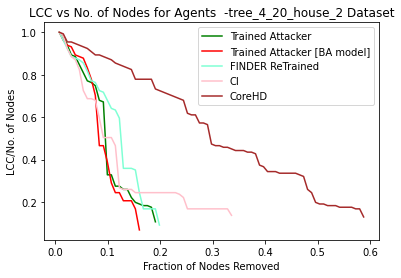

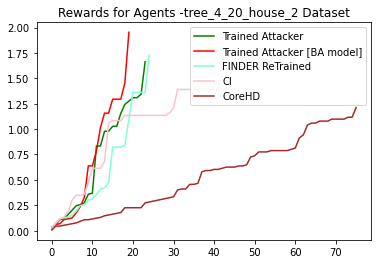

tree_4_30_house_3
[30, 20, 180, 65, 19, 6, 15, 9, 101, 24, 60, 121, 16, 113, 17, 50, 64, 11, 62, 52, 14, 56, 59, 63, 97, 61, 54, 55, 3, 48, 12, 136]
[20, 30, 65, 18, 6, 9, 19, 15, 24, 97, 52, 12, 16, 27, 17, 33, 60, 63, 50, 49, 3, 61, 57, 59, 62, 54, 55, 21, 64, 56, 1]


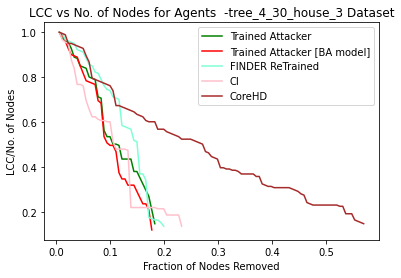

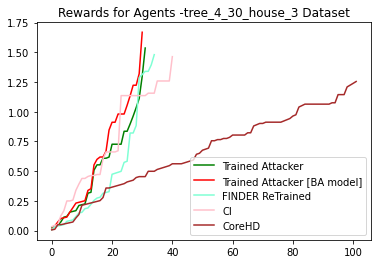

tree_4_10_fan_1
[8, 7, 14, 11, 9, 34, 12, 0]
[8, 14, 11, 7, 9, 0, 12]


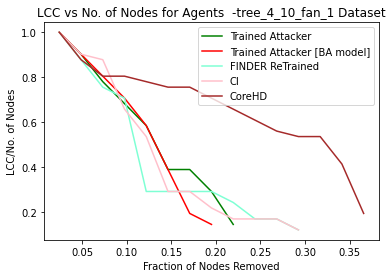

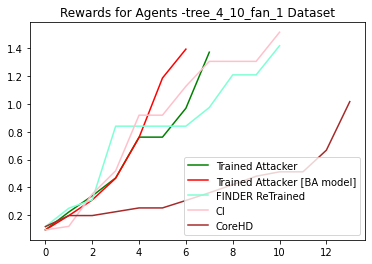

tree_4_20_fan_2
[16, 13, 19, 17, 15, 12, 18, 1, 14, 20, 11, 21, 3]
[10, 16, 1, 17, 19, 15, 12, 14, 11, 18, 20, 3]


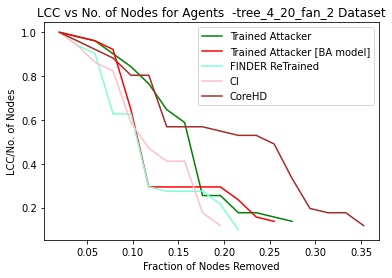

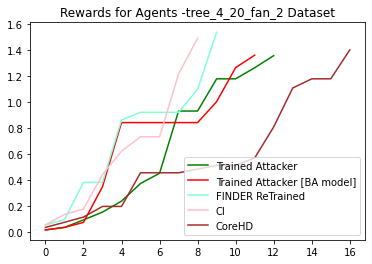

tree_4_30_fan_3
[13, 16, 10, 20, 14, 17, 1, 11, 21, 8, 3, 19]
[15, 10, 16, 13, 21, 2, 1, 19]


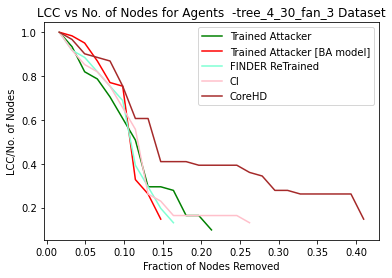

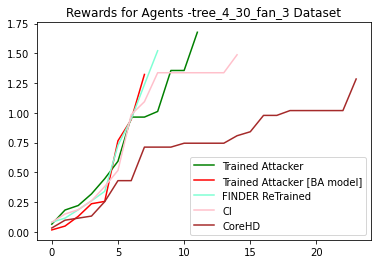

tree_4_10_clique_1
[3, 4, 16, 14, 11, 15, 2, 12, 6]
[3, 16, 4, 14, 11, 2, 12, 13]


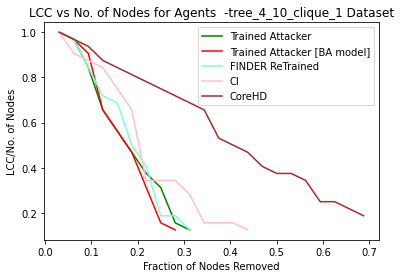

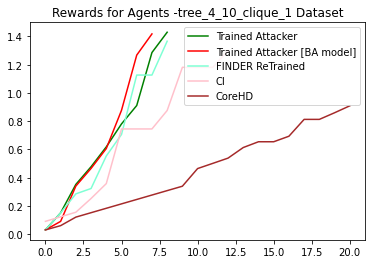

tree_4_20_clique_2
[3, 16, 9, 13, 8, 14, 11, 2, 15, 12, 0]
[3, 16, 9, 1, 2, 13, 14, 15, 11, 8, 23]


tree_4_30_clique_3
[3, 10, 13, 15, 9, 11, 1, 12, 2, 8, 6]
[3, 10, 2, 1, 16, 9, 14, 11, 8]


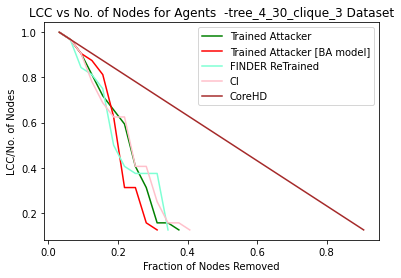

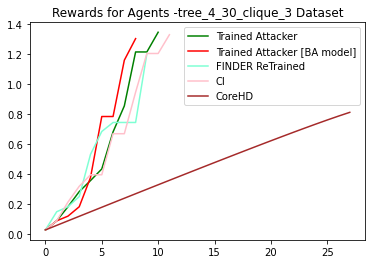

tree_4_10_diamond_1
[36, 4, 14, 43, 29, 10, 46, 70, 35, 44, 58, 20, 11, 52, 3, 75, 41, 12, 7, 47, 64, 57, 83, 90, 18, 13, 19]
[14, 65, 29, 46, 4, 43, 11, 36, 59, 10, 35, 3, 44, 41, 42, 47, 12, 8, 7]


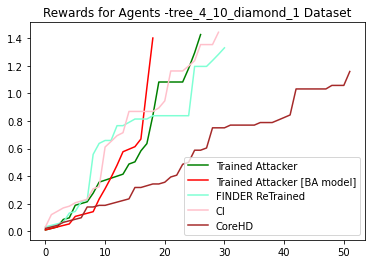

tree_4_20_diamond_2
[32, 117, 35, 85, 38, 22, 6, 3, 31, 53, 96, 108, 107, 52, 5, 63, 125, 56, 55, 66, 131, 44, 140, 49, 137, 51, 12, 84, 77, 75, 74, 48, 21, 2, 11]
[35, 6, 63, 52, 85, 22, 108, 121, 107, 31, 62, 38, 3, 76, 143, 92, 125, 53, 12, 50, 140, 54, 48, 102, 44, 51, 56, 66, 9, 49, 96, 5, 103, 18, 10, 150, 80, 15, 78, 117, 11, 21]


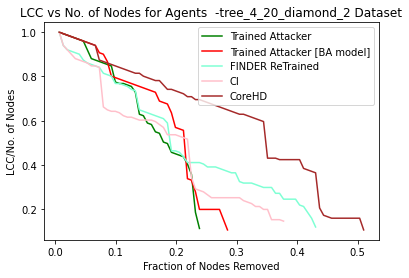

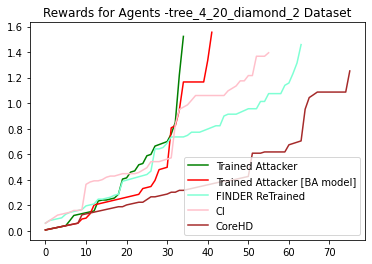

tree_4_30_diamond_3
[160, 19, 13, 29, 61, 162, 86, 63, 15, 27, 78, 18, 6, 60, 143, 45, 16, 144, 52, 8, 65, 79, 96, 12, 30, 125, 53, 101, 38, 9, 3, 69, 136, 56, 71, 55, 119, 26, 205, 70, 189, 200, 201, 17, 68, 72, 67, 145, 54, 62]
[19, 79, 78, 29, 162, 27, 61, 143, 190, 18, 15, 60, 13, 192, 63, 45, 86, 53, 201, 65, 54, 56, 52, 124, 9, 156, 69, 2, 16, 22, 12, 3, 70, 58, 23, 30, 117, 33, 42, 160, 55, 177, 71, 125, 144, 145, 103, 176, 67, 68, 133, 17, 72, 104, 88, 20, 10, 1]


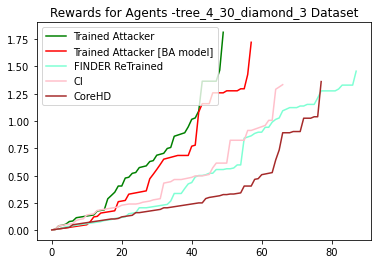

tree_4_10_cycle_1
[8, 36, 37, 7, 11, 33, 46, 47, 39, 40, 42, 41, 9, 12, 43, 1, 10, 13, 14]
[7, 8, 11, 14, 1, 9, 44]


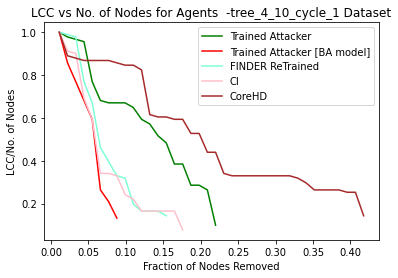

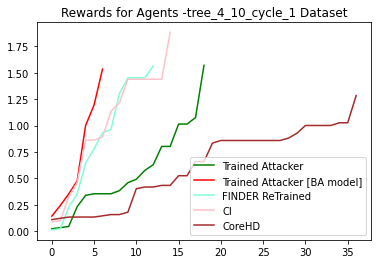

tree_4_20_cycle_2
[21, 17, 2, 14, 18, 15, 60, 4, 22, 23, 20, 19, 59, 16, 1, 3, 58, 24, 137, 55]
[17, 21, 14, 2, 1, 12, 20, 60, 11, 15]


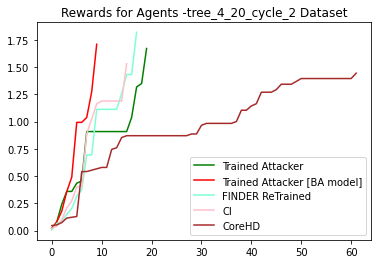

tree_4_30_cycle_3
[7, 2, 23, 68, 69, 21, 22, 4, 67, 5, 39, 70, 66, 18, 3, 6, 187, 62, 17, 61, 53, 12, 54, 59, 35, 60, 151, 24, 52]
[2, 18, 21, 1, 12, 15, 22, 17, 14, 11, 64]


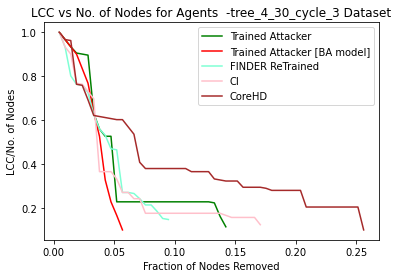

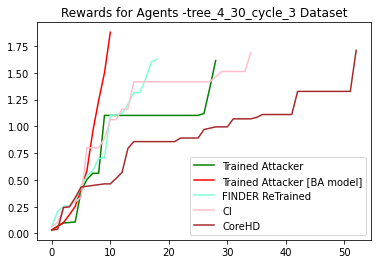

tree_4_10_star_1
[4, 15, 12, 7, 14, 22, 0]
[4, 15, 7, 12, 14, 38, 13]


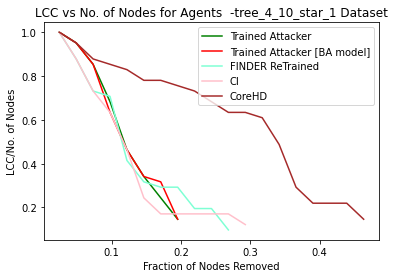

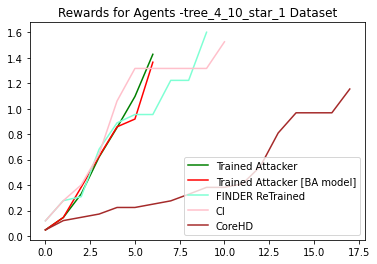

tree_4_20_star_2
[10, 19, 16, 14, 17, 1, 2, 11, 13]
[10, 19, 18, 15, 16, 14, 17, 11, 2, 13]


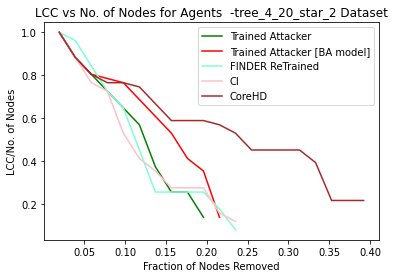

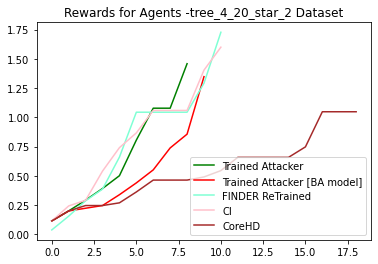

tree_4_30_star_3
[20, 10, 16, 13, 19, 14, 1, 2, 17, 21]
[20, 10, 16, 13, 2, 17, 11, 14, 1, 19, 38]


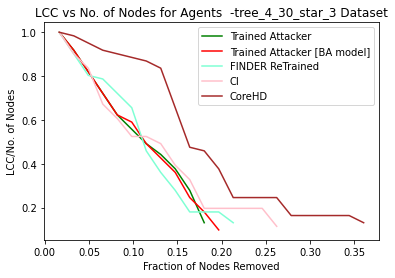

tree_4_10_grid_1
[191, 346, 342, 125, 345, 348, 275, 48, 353, 140, 276, 303, 349, 64, 11, 25, 241, 128, 36, 211, 263, 38, 231, 208, 198, 327, 46, 318, 50, 155, 60, 109, 153, 66, 302, 39, 58, 86, 386, 150, 376, 139, 382, 137, 148, 149, 145, 133, 154, 136, 7, 14, 69, 8, 9, 80, 77, 59, 53, 49, 339, 199, 45, 44, 55, 193, 185, 174, 171, 175, 170, 179, 188, 197, 258, 159, 93, 270, 123, 47, 131, 267, 251, 285, 291, 279, 287, 293, 288, 216, 365, 372, 374, 385, 239, 81, 234, 233, 162, 224, 329, 320, 307, 304, 310, 236, 91, 124, 20, 121, 104, 113, 96, 388, 373, 324, 147, 308, 190, 316, 334, 132, 206, 41, 43, 3, 151, 187, 203, 296, 325, 12, 115, 65, 366]
[125, 128, 42, 276, 140, 81, 60, 205, 258, 11, 48, 263, 145, 50, 16, 192, 327, 318, 46, 212, 208, 109, 58, 136, 231, 345, 130, 211, 106, 86, 148, 379, 251, 161, 316, 112, 377, 175, 91, 292, 118, 45, 53, 374, 131, 365, 383, 280, 321, 93, 228, 307, 120, 294, 355, 9, 185, 69, 233, 286, 267, 236, 170, 55, 96, 156, 310, 342, 159, 149, 239, 270, 77, 22

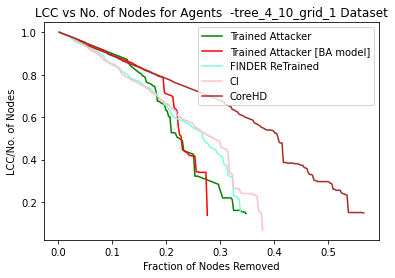

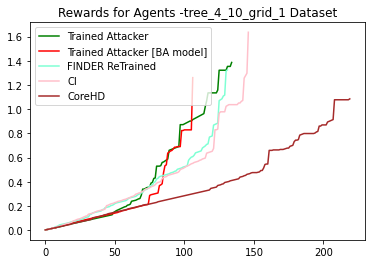

tree_4_20_grid_2
[433, 567, 702, 119, 135, 114, 426, 356, 554, 395, 108, 695, 285, 136, 130, 56, 212, 129, 546, 187, 735, 87, 401, 733, 257, 153, 443, 737, 739, 614, 508, 59, 484, 20, 102, 580, 17, 730, 152, 38, 149, 151, 14, 49, 560, 270, 177, 175, 163, 446, 142, 133, 121, 682, 221, 307, 438, 469, 52, 435, 380, 231, 605, 278, 300, 525, 103, 320, 74, 204, 76, 349, 69, 254, 550, 422, 269, 201, 348, 457, 218, 210, 224, 208, 227, 215, 226, 363, 679, 373, 678, 673, 378, 194, 720, 120, 107, 113, 125, 111, 6, 104, 118, 477, 465, 464, 474, 470, 472, 615, 743, 16, 294, 388, 485, 663, 10, 368, 19, 55, 504, 188, 563, 572, 486, 579, 13, 400, 60, 12, 197, 206, 344, 359, 192, 2, 80, 57, 392, 11, 128, 513, 708, 719, 379, 716, 668, 662, 517, 666, 63, 699, 696, 155, 651, 425, 431, 420, 335, 268, 460, 596, 688, 222, 383, 174, 397, 603, 600, 585, 512, 501, 489, 281, 273, 298, 296, 277, 274, 276, 291, 535, 94, 70, 82, 541, 544, 532, 522, 97, 266, 321, 99, 95, 79, 90, 47, 71, 493, 289, 547, 540]
[221, 121

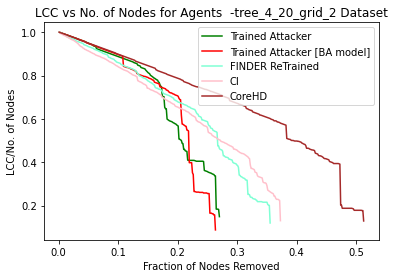

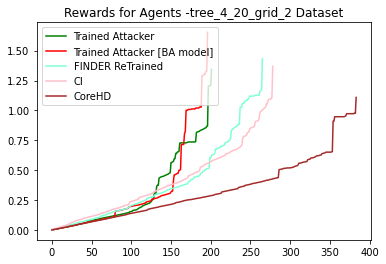

tree_4_30_grid_3
[433, 320, 1084, 185, 393, 179, 190, 184, 583, 172, 182, 174, 169, 497, 388, 576, 923, 401, 274, 164, 129, 724, 887, 356, 475, 133, 574, 230, 587, 192, 206, 715, 1080, 509, 565, 69, 499, 110, 115, 992, 93, 902, 903, 735, 732, 998, 183, 86, 437, 99, 96, 333, 102, 730, 106, 91, 92, 18, 98, 5, 593, 191, 78, 708, 719, 526, 60, 414, 135, 655, 21, 533, 542, 353, 275, 54, 188, 783, 378, 801, 71, 396, 153, 151, 381, 123, 120, 836, 741, 156, 520, 7, 251, 440, 602, 254, 612, 653, 698, 670, 525, 335, 465, 235, 1005, 302, 916, 689, 862, 376, 871, 463, 215, 225, 305, 911, 306, 447, 365, 358, 313, 472, 486, 476, 470, 1011, 217, 868, 1008, 373, 456, 1009, 46, 949, 611, 1012, 1013, 680, 1020, 1019, 1031, 1028, 1035, 478, 1024, 277, 898, 312, 298, 963, 301, 328, 310, 316, 661, 645, 658, 659, 665, 663, 667, 651, 656, 321, 409, 386, 1037, 1026, 19, 12, 467, 88, 77, 95, 368, 569, 394, 11, 1000, 995, 991, 549, 568, 578, 872, 1075, 1078, 1073, 1067, 774, 751, 22, 195, 398, 407, 405, 384, 44

In [18]:
file_list = ['tree_4_10_house_1', 'tree_4_20_house_2', 'tree_4_30_house_3', 'tree_4_10_fan_1', 'tree_4_20_fan_2', 'tree_4_30_fan_3', 'tree_4_10_clique_1', 'tree_4_20_clique_2', 'tree_4_30_clique_3', 'tree_4_10_diamond_1', 'tree_4_20_diamond_2', 'tree_4_30_diamond_3', 'tree_4_10_cycle_1', 'tree_4_20_cycle_2', 'tree_4_30_cycle_3', 'tree_4_10_star_1', 'tree_4_20_star_2', 'tree_4_30_star_3', 'tree_4_10_grid_1', 'tree_4_20_grid_2', 'tree_4_30_grid_3']
graph_path = "./Dataset/Validation/GNNexplanation/New/"
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])

In [19]:
file = ['differentGraph','BAGraph','FinderReTrained','CI','CoreHD']
print('Test Name','\t\t','Mix','\t','BA','\t','FIN','\t','CI''\t','CoreHD''\t','BEST')
for i, element in enumerate(AUC):
    for nested_tem in element:
        if isinstance(nested_tem, str): 
            print(nested_tem, end=" => \t")
        else:
            print("{:.2f}".format(nested_tem), end=" \t")
    
    best = np.argmin(np.array(element[1:]).astype(float))
    print(file[best])
    print("")
print("===============================")

Test Name 		 Mix 	 BA 	 FIN 	 CoreHD	 BEST
tree_4_10_house_1 => 	12.33 	10.75 	27.40 	BAGraph

tree_4_20_house_2 => 	14.61 	16.45 	41.99 	differentGraph

tree_4_30_house_3 => 	22.80 	19.58 	49.92 	BAGraph

tree_4_10_fan_1 => 	4.66 	4.85 	9.40 	differentGraph

tree_4_20_fan_2 => 	4.98 	5.25 	9.62 	differentGraph

tree_4_30_fan_3 => 	5.52 	6.60 	11.54 	differentGraph

tree_4_10_clique_1 => 	5.06 	6.38 	12.34 	differentGraph

tree_4_20_clique_2 => 	6.02 	6.95 	12.23 	differentGraph

tree_4_30_clique_3 => 	5.97 	6.53 	15.75 	differentGraph

tree_4_10_diamond_1 => 	15.03 	14.40 	27.93 	BAGraph

tree_4_20_diamond_2 => 	33.35 	27.84 	47.11 	BAGraph

tree_4_30_diamond_3 => 	49.70 	42.18 	54.91 	BAGraph

tree_4_10_cycle_1 => 	6.18 	5.93 	19.29 	BAGraph

tree_4_20_cycle_2 => 	9.08 	8.20 	21.61 	BAGraph

tree_4_30_cycle_3 => 	9.01 	11.21 	21.16 	differentGraph

tree_4_10_star_1 => 	4.57 	4.37 	11.13 	BAGraph

tree_4_20_star_2 => 	5.36 	5.21 	10.73 	BAGraph

tree_4_30_star_3 => 	6.07 	6.82 	10.68 

# Gene DataSet

COAD
[319, 297, 457, 566, 346, 819, 2, 490, 902, 437, 8, 1184, 321, 388, 349, 296, 2445, 1166, 443, 6, 2100, 292, 7, 300, 909, 982, 413, 420, 2447, 2145, 403, 341, 4189, 229, 1927, 1168, 1621, 803, 4, 1363, 2147, 330, 18, 970, 626, 283, 1, 1362, 38, 1284, 1015, 1321, 13, 2639, 897, 438, 1955, 2149, 5, 445, 450, 497, 384, 3, 742, 1882, 2887, 2161, 431, 694, 969, 304, 595, 1541, 2171, 1335, 94, 439, 701, 2656, 2877, 352, 2069, 309, 1028, 2627, 2157, 735, 1532, 121, 446, 345, 462, 386, 2151, 541, 2501, 1497, 930, 305, 1392, 293, 2165, 2175, 805, 383, 653, 1200, 145, 646, 755, 1194, 278, 2167, 972, 88, 239, 814, 3168, 1083, 954, 1530, 597, 2628, 521, 3235, 2172, 436, 799, 79, 2624, 2141, 1062, 338, 3482, 40, 2160, 402, 113, 442, 227, 728, 651, 1135, 85, 2204, 427, 2189, 289, 157, 1698, 61, 372, 357, 747, 693, 307, 2148, 2156, 587, 2059, 1986, 411, 794, 894, 493, 948, 2616, 453, 779, 1975, 665, 652, 756, 1187, 1599, 406, 2637, 957, 1982, 316, 713, 27, 422, 1098, 124, 354, 455, 888, 147, 284

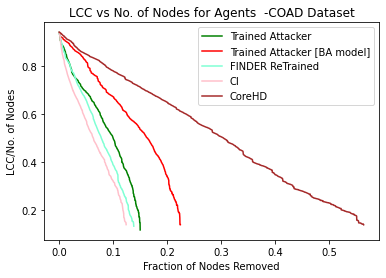

HNSC
[1465, 1470, 1474, 1475, 1488, 1489, 1490, 1494, 1795, 1797, 753, 830, 1219, 3141, 1483, 1463, 1468, 1476, 1495, 1814, 1484, 1491, 1498, 1482, 1481, 1466, 1627, 1747, 1464, 1531, 1672, 1485, 1493, 1790, 1492, 1480, 1798, 1784, 25, 1722, 1702, 1756, 404, 468, 101, 1680, 1694, 1774, 1670, 1635, 1781, 1687, 1799, 1686, 1714, 1607, 1479, 1633, 1723, 1755, 1761, 1583, 1708, 1595, 1752, 1762, 1471, 1530, 1742, 1789, 14, 1043, 2097, 3088, 1277, 678, 2081, 1767, 3091, 485, 2659, 2111, 45, 2658, 450, 2080, 2251, 743, 2115, 2099, 2679, 1496, 2571, 2826, 1757, 2684, 71, 1698, 147, 3051, 3624, 1668, 1472, 1707, 1602, 1681, 3905, 469, 21, 2625, 3732, 124, 5048, 5140, 1590, 208, 4360, 27, 1620, 305, 1487, 13, 1477, 151, 1154, 8, 107, 1000, 471, 2899, 1313, 1547, 1603, 1579, 1677, 1636, 1704, 1728, 1169, 39, 1469, 1727, 281, 762, 188, 1610, 720, 1621, 1766, 1701, 1497, 273, 1499, 1678, 106, 1615, 1703, 1710, 380, 1273, 193, 164, 100, 2422, 1587, 1630, 1345, 754, 1622, 1473, 1563, 1740, 2798, 454

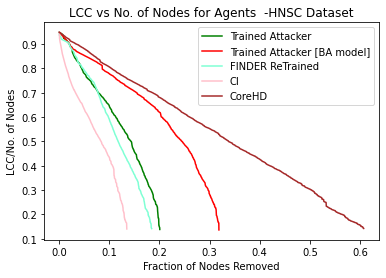

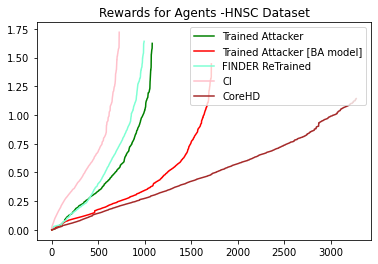

KICH
[106, 103, 773, 105, 660, 526, 123, 368, 339, 104, 1523, 1649, 387, 679, 378, 1102, 225, 423, 274, 1104, 610, 273, 50, 1094, 145, 31, 2236, 1628, 242, 1263, 2248, 309, 98, 1126, 83, 687, 424, 1571, 1878, 1300, 1024, 210, 745, 609, 1216, 1101, 887, 96, 840, 951, 1462, 24, 1240, 1966, 1406, 340, 1891, 78, 2523, 674, 2040, 1058, 1235, 945, 1332, 4, 1014, 1142, 1614, 523, 631, 867, 1613, 72, 804, 601, 1611, 422, 179, 1097, 1667, 1643, 1756, 1612, 1427, 23, 1404, 81, 153, 1310, 1299, 1306, 453, 831, 1544, 1387, 1095, 1543, 1422, 436, 909, 1057, 1647, 1555, 1227, 380, 57, 1145, 939, 249, 1671, 613, 1236, 34, 285, 377, 886, 775, 35, 1378, 839, 1220, 1457, 664, 491, 427, 833, 957, 1697, 1119, 1114, 1333, 2013, 90, 1788, 85, 941, 16, 2060, 1489, 843, 91, 1495, 7, 953, 702, 844, 62, 955, 1347, 924, 1736, 2251, 432, 1305, 640, 437, 661, 600, 8, 1652]
[106, 103, 773, 105, 660, 526, 123, 387, 368, 31, 273, 339, 1126, 104, 609, 625, 687, 423, 610, 316, 317, 318, 319, 320, 321, 1240, 1014, 322, 

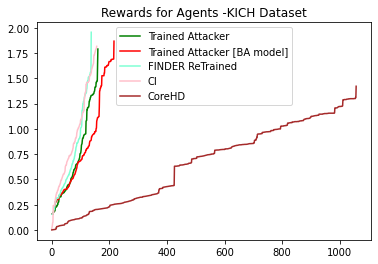

KIRC
[4298, 4305, 1814, 1764, 65, 32, 283, 157, 248, 1093, 586, 638, 64, 621, 609, 1510, 3238, 2079, 159, 513, 639, 636, 6325, 165, 557, 2437, 4490, 3020, 679, 499, 3808, 926, 3059, 5220, 43, 814, 1467, 5221, 1783, 3245, 5237, 870, 460, 660, 1069, 4195, 2690, 221, 779, 878, 3088, 931, 470, 325, 41, 358, 737, 1209, 790, 225, 3990, 2639, 3170, 4770, 475, 3634, 1498, 1358, 3196, 111, 5910, 1175, 1942, 267, 873, 963, 3482, 1625, 1824, 1809, 1613, 1699, 1718, 1797, 1864, 1684, 1891, 1677, 1592, 1614, 2018, 1620, 751, 1726, 48, 1779, 1545, 1153, 1593, 158, 147, 1711, 3678, 3265, 1759, 1595, 3288, 1669, 2200, 4767, 1721, 6173, 540, 1794, 1640, 5567, 1800, 1690, 6203, 1750, 698, 1786, 145, 562, 170, 635, 2171, 822, 1802, 141, 77, 122, 317, 1782, 1733, 4769, 1796, 5981, 1819, 277, 362, 352, 1232, 851, 3485, 1698, 1580, 4983, 1605, 280, 437, 928, 1065, 1098, 1124, 976, 3672, 1792, 6229, 1673, 552, 559, 605, 653, 3002, 853, 1843, 1878, 503, 1275, 482, 1302, 837, 578, 581, 90, 668, 1307, 584, 320,

FileNotFoundError: ./FINDER/FINDER_ReTrained/KIRC.txt not found.

In [8]:
graph_path = "./Dataset/GeneNetwork/"
file_list =  ["COAD","HNSC","KICH","KIRC","PRAD","UCEC"]
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])
